## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


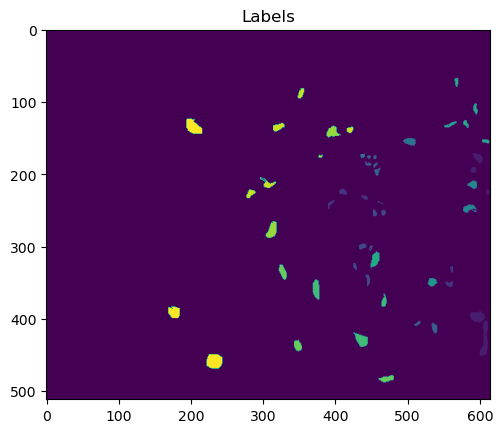

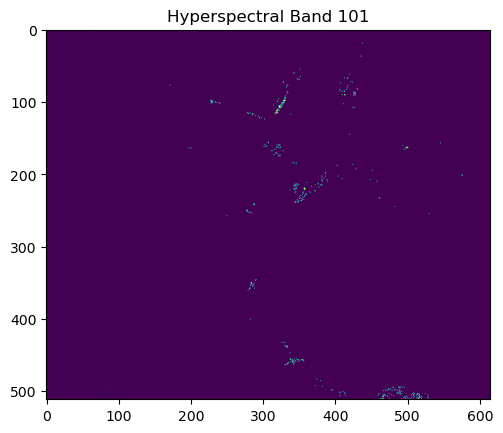

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(260, 5, 5, 176)
(65, 5, 5, 176)
(4886, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2517, PSNR: 5.9909


Epoch [1/50] Training Loss: 0.2400, PSNR: 6.2005
	[Val]   Batch [1/17] Loss: 0.2260, PSNR: 6.4597
	[Val]   Batch [10/17] Loss: 0.2263, PSNR: 6.4536
Epoch [1/50] Validation Loss: 0.2261, PSNR: 6.4562

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2192, PSNR: 6.5917


Epoch [2/50] Training Loss: 0.2040, PSNR: 6.9086
	[Val]   Batch [1/17] Loss: 0.1813, PSNR: 7.4150
	[Val]   Batch [10/17] Loss: 0.1834, PSNR: 7.3662
Epoch [2/50] Validation Loss: 0.1828, PSNR: 7.3805

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1812, PSNR: 7.4191


Epoch [3/50] Training Loss: 0.1669, PSNR: 7.7833
	[Val]   Batch [1/17] Loss: 0.1444, PSNR: 8.4048
	[Val]   Batch [10/17] Loss: 0.1484, PSNR: 8.2843
Epoch [3/50] Validation Loss: 0.1472, PSNR: 8.3226

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1460, PSNR: 8.3557


Epoch [4/50] Training Loss: 0.1344, PSNR: 8.7236
	[Val]   Batch [1/17] Loss: 0.1160, PSNR: 9.3547
	[Val]   Batch [10/17] Loss: 0.1182, PSNR: 9.2740
Epoch [4/50] Validation Loss: 0.1177, PSNR: 9.2917

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1167, PSNR: 9.3278


Epoch [5/50] Training Loss: 0.1072, PSNR: 9.7059
	[Val]   Batch [1/17] Loss: 0.0937, PSNR: 10.2814
	[Val]   Batch [10/17] Loss: 0.0958, PSNR: 10.1882
Epoch [5/50] Validation Loss: 0.0953, PSNR: 10.2100

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0935, PSNR: 10.2913


Epoch [6/50] Training Loss: 0.0857, PSNR: 10.6796
	[Val]   Batch [1/17] Loss: 0.0758, PSNR: 11.2054
	[Val]   Batch [10/17] Loss: 0.0769, PSNR: 11.1415
Epoch [6/50] Validation Loss: 0.0766, PSNR: 11.1559

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0750, PSNR: 11.2485


Epoch [7/50] Training Loss: 0.0690, PSNR: 11.6159
	[Val]   Batch [1/17] Loss: 0.0621, PSNR: 12.0663
	[Val]   Batch [10/17] Loss: 0.0629, PSNR: 12.0108
Epoch [7/50] Validation Loss: 0.0627, PSNR: 12.0260

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0610, PSNR: 12.1444


Epoch [8/50] Training Loss: 0.0564, PSNR: 12.4896
	[Val]   Batch [1/17] Loss: 0.0514, PSNR: 12.8875
	[Val]   Batch [10/17] Loss: 0.0519, PSNR: 12.8468
Epoch [8/50] Validation Loss: 0.0517, PSNR: 12.8647

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0502, PSNR: 12.9933


Epoch [9/50] Training Loss: 0.0470, PSNR: 12.6175
	[Val]   Batch [1/17] Loss: 0.0439, PSNR: 13.5708
	[Val]   Batch [10/17] Loss: 0.0445, PSNR: 13.5165
Epoch [9/50] Validation Loss: 0.0443, PSNR: 13.5397

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0424, PSNR: 13.7252


Epoch [10/50] Training Loss: 0.0397, PSNR: 14.0208
	[Val]   Batch [1/17] Loss: 0.0368, PSNR: 14.3395
	[Val]   Batch [10/17] Loss: 0.0370, PSNR: 14.3233
Epoch [10/50] Validation Loss: 0.0369, PSNR: 14.3328

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0361, PSNR: 14.4289


Epoch [11/50] Training Loss: 0.0341, PSNR: 14.6819
	[Val]   Batch [1/17] Loss: 0.0318, PSNR: 14.9813
	[Val]   Batch [10/17] Loss: 0.0320, PSNR: 14.9521
Epoch [11/50] Validation Loss: 0.0319, PSNR: 14.9611

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0312, PSNR: 15.0559


Epoch [12/50] Training Loss: 0.0296, PSNR: 15.2933
	[Val]   Batch [1/17] Loss: 0.0281, PSNR: 15.5065
	[Val]   Batch [10/17] Loss: 0.0284, PSNR: 15.4663
Epoch [12/50] Validation Loss: 0.0283, PSNR: 15.4843

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0271, PSNR: 15.6705


Epoch [13/50] Training Loss: 0.0259, PSNR: 15.8660
	[Val]   Batch [1/17] Loss: 0.0248, PSNR: 16.0545
	[Val]   Batch [10/17] Loss: 0.0251, PSNR: 16.0117
Epoch [13/50] Validation Loss: 0.0249, PSNR: 16.0332

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0244, PSNR: 16.1330


Epoch [14/50] Training Loss: 0.0230, PSNR: 16.3851
	[Val]   Batch [1/17] Loss: 0.0219, PSNR: 16.5997
	[Val]   Batch [10/17] Loss: 0.0221, PSNR: 16.5525
Epoch [14/50] Validation Loss: 0.0220, PSNR: 16.5734

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0216, PSNR: 16.6631


Epoch [15/50] Training Loss: 0.0206, PSNR: 16.1822
	[Val]   Batch [1/17] Loss: 0.0202, PSNR: 16.9410
	[Val]   Batch [10/17] Loss: 0.0205, PSNR: 16.8817
Epoch [15/50] Validation Loss: 0.0204, PSNR: 16.9041

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0195, PSNR: 17.0890


Epoch [16/50] Training Loss: 0.0185, PSNR: 17.3279
	[Val]   Batch [1/17] Loss: 0.0178, PSNR: 17.4910
	[Val]   Batch [10/17] Loss: 0.0180, PSNR: 17.4494
Epoch [16/50] Validation Loss: 0.0179, PSNR: 17.4634

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0172, PSNR: 17.6349


Epoch [17/50] Training Loss: 0.0168, PSNR: 17.7542
	[Val]   Batch [1/17] Loss: 0.0164, PSNR: 17.8559
	[Val]   Batch [10/17] Loss: 0.0166, PSNR: 17.7968
Epoch [17/50] Validation Loss: 0.0165, PSNR: 17.8168

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0158, PSNR: 18.0001


Epoch [18/50] Training Loss: 0.0153, PSNR: 18.1553
	[Val]   Batch [1/17] Loss: 0.0148, PSNR: 18.3099
	[Val]   Batch [10/17] Loss: 0.0150, PSNR: 18.2473
Epoch [18/50] Validation Loss: 0.0149, PSNR: 18.2691

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0146, PSNR: 18.3694


Epoch [19/50] Training Loss: 0.0140, PSNR: 18.5251
	[Val]   Batch [1/17] Loss: 0.0138, PSNR: 18.5964
	[Val]   Batch [10/17] Loss: 0.0140, PSNR: 18.5279
Epoch [19/50] Validation Loss: 0.0140, PSNR: 18.5508

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0133, PSNR: 18.7576


Epoch [20/50] Training Loss: 0.0129, PSNR: 18.9007
	[Val]   Batch [1/17] Loss: 0.0126, PSNR: 19.0068
	[Val]   Batch [10/17] Loss: 0.0128, PSNR: 18.9444
Epoch [20/50] Validation Loss: 0.0127, PSNR: 18.9640

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0121, PSNR: 19.1579


Epoch [21/50] Training Loss: 0.0119, PSNR: 19.2441
	[Val]   Batch [1/17] Loss: 0.0118, PSNR: 19.2687
	[Val]   Batch [10/17] Loss: 0.0120, PSNR: 19.2029
Epoch [21/50] Validation Loss: 0.0120, PSNR: 19.2261

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0112, PSNR: 19.4968


Epoch [22/50] Training Loss: 0.0110, PSNR: 18.9041
	[Val]   Batch [1/17] Loss: 0.0109, PSNR: 19.6151
	[Val]   Batch [10/17] Loss: 0.0111, PSNR: 19.5324
Epoch [22/50] Validation Loss: 0.0111, PSNR: 19.5618

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0105, PSNR: 19.8014


Epoch [23/50] Training Loss: 0.0103, PSNR: 19.2072
	[Val]   Batch [1/17] Loss: 0.0102, PSNR: 19.8934
	[Val]   Batch [10/17] Loss: 0.0104, PSNR: 19.8133
Epoch [23/50] Validation Loss: 0.0104, PSNR: 19.8418

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0097, PSNR: 20.1433


Epoch [24/50] Training Loss: 0.0096, PSNR: 20.1848
	[Val]   Batch [1/17] Loss: 0.0094, PSNR: 20.2588
	[Val]   Batch [10/17] Loss: 0.0096, PSNR: 20.1843
Epoch [24/50] Validation Loss: 0.0095, PSNR: 20.2094

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0090, PSNR: 20.4625


Epoch [25/50] Training Loss: 0.0089, PSNR: 20.4864
	[Val]   Batch [1/17] Loss: 0.0088, PSNR: 20.5428
	[Val]   Batch [10/17] Loss: 0.0090, PSNR: 20.4540
Epoch [25/50] Validation Loss: 0.0089, PSNR: 20.4872

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0086, PSNR: 20.6750


Epoch [26/50] Training Loss: 0.0084, PSNR: 20.7641
	[Val]   Batch [1/17] Loss: 0.0084, PSNR: 20.7760
	[Val]   Batch [10/17] Loss: 0.0085, PSNR: 20.6829
Epoch [26/50] Validation Loss: 0.0085, PSNR: 20.7171

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0082, PSNR: 20.8641


Epoch [27/50] Training Loss: 0.0079, PSNR: 21.0268
	[Val]   Batch [1/17] Loss: 0.0079, PSNR: 21.0487
	[Val]   Batch [10/17] Loss: 0.0080, PSNR: 20.9504
Epoch [27/50] Validation Loss: 0.0080, PSNR: 20.9856

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0075, PSNR: 21.2486


Epoch [28/50] Training Loss: 0.0074, PSNR: 21.2933
	[Val]   Batch [1/17] Loss: 0.0074, PSNR: 21.3120
	[Val]   Batch [10/17] Loss: 0.0076, PSNR: 21.2126
Epoch [28/50] Validation Loss: 0.0075, PSNR: 21.2509

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0071, PSNR: 21.4857


Epoch [29/50] Training Loss: 0.0070, PSNR: 21.5524
	[Val]   Batch [1/17] Loss: 0.0069, PSNR: 21.5848
	[Val]   Batch [10/17] Loss: 0.0071, PSNR: 21.4814
Epoch [29/50] Validation Loss: 0.0070, PSNR: 21.5204

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0066, PSNR: 21.8108


Epoch [30/50] Training Loss: 0.0066, PSNR: 21.7957
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8405
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7301
Epoch [30/50] Validation Loss: 0.0067, PSNR: 21.7702

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 22.0104


Epoch [31/50] Training Loss: 0.0063, PSNR: 22.0368
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 22.0218
	[Val]   Batch [10/17] Loss: 0.0064, PSNR: 21.9098
Epoch [31/50] Validation Loss: 0.0064, PSNR: 21.9511

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0060, PSNR: 22.2365


Epoch [32/50] Training Loss: 0.0059, PSNR: 22.2670
	[Val]   Batch [1/17] Loss: 0.0059, PSNR: 22.3086
	[Val]   Batch [10/17] Loss: 0.0060, PSNR: 22.1879
Epoch [32/50] Validation Loss: 0.0060, PSNR: 22.2333

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0058, PSNR: 22.3588


Epoch [33/50] Training Loss: 0.0056, PSNR: 21.8072
	[Val]   Batch [1/17] Loss: 0.0058, PSNR: 22.3926
	[Val]   Batch [10/17] Loss: 0.0059, PSNR: 22.2697
Epoch [33/50] Validation Loss: 0.0059, PSNR: 22.3155

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7760


Epoch [34/50] Training Loss: 0.0054, PSNR: 22.7002
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7423
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.6091
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6596

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0054, PSNR: 22.6692


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.9008
	[Val]   Batch [1/17] Loss: 0.0052, PSNR: 22.8749
	[Val]   Batch [10/17] Loss: 0.0053, PSNR: 22.7373
Epoch [35/50] Validation Loss: 0.0053, PSNR: 22.7902

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.0984


Epoch [36/50] Training Loss: 0.0049, PSNR: 23.1250
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.1124
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 22.9731
Epoch [36/50] Validation Loss: 0.0050, PSNR: 23.0252

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0048, PSNR: 23.2077


Epoch [37/50] Training Loss: 0.0047, PSNR: 23.3151
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3540
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.2035
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2599

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0045, PSNR: 23.4728


Epoch [38/50] Training Loss: 0.0045, PSNR: 22.8498
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5524
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.4127
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4636

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6740


Epoch [39/50] Training Loss: 0.0043, PSNR: 23.7124
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7722
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.6097
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6695

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7793


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.8884
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9517
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7928
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8515

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8761


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.0824
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1365
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9734
Epoch [41/50] Validation Loss: 0.0040, PSNR: 24.0319

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0547


Epoch [42/50] Training Loss: 0.0038, PSNR: 24.2442
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.2947
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.1259
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.1886

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4848


Epoch [43/50] Training Loss: 0.0036, PSNR: 23.7273
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.3961
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.2215
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.2853

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6409


Epoch [44/50] Training Loss: 0.0035, PSNR: 24.5700
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.6063
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4205
Epoch [44/50] Validation Loss: 0.0036, PSNR: 24.4890

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6554


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7522
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.8255
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6307
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.7025

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9280


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.9154
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9669
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.7698
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8429

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1269


Epoch [47/50] Training Loss: 0.0031, PSNR: 25.0726
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1094
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9124
Epoch [47/50] Validation Loss: 0.0032, PSNR: 24.9860

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2773


Epoch [48/50] Training Loss: 0.0030, PSNR: 25.2315
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2326
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0247
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.1028

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.4363


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3636
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3938
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.1818
Epoch [49/50] Validation Loss: 0.0030, PSNR: 25.2608

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.6065


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.5121
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5647
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3383
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.4211


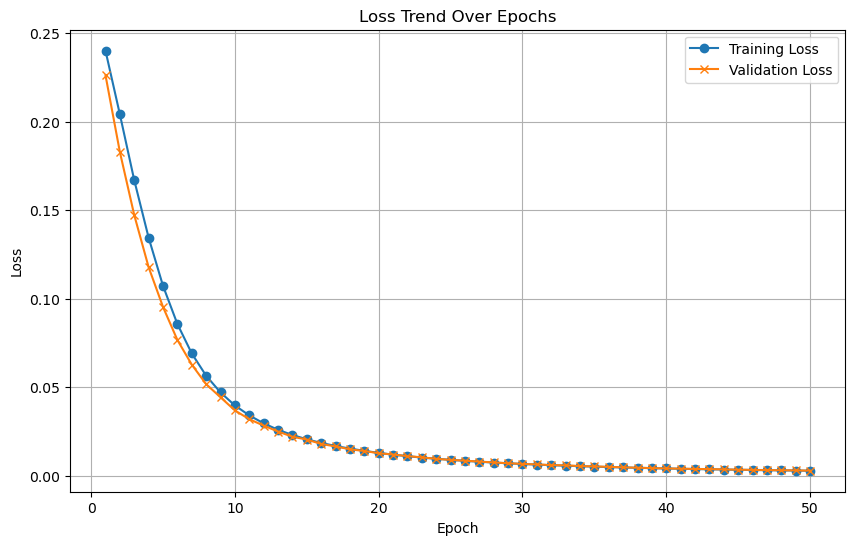

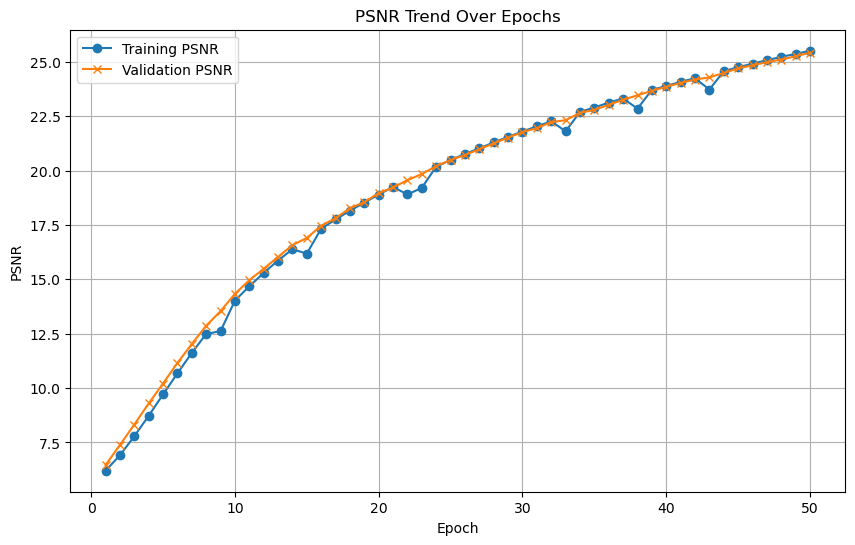

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5770
    Validation Batch [1/1], Loss: 2.5678
Validation Loss: 2.5678, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5678. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5556
    Validation Batch [1/1], Loss: 2.5678
Validation Loss: 2.5678, Validation Accuracy: 7.69%
Validation loss improved from 2.5678 to 2.5678. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5453
    Validation Batch [1/1], Loss: 2.5678
Validation Loss: 2.5678, Validation Accuracy: 7.69%
Validation loss improved from 2.5678 to 2.5678. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5340
    Validation Batch [1/1], Loss: 2.5678
Validation Loss: 2.5678, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training
Epoch 

Epoch [18/1000] completed, Average Training Loss: 2.4433
    Validation Batch [1/1], Loss: 2.5676
Validation Loss: 2.5676, Validation Accuracy: 7.69%
Validation loss improved from 2.5676 to 2.5676. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.4393
    Validation Batch [1/1], Loss: 2.5676
Validation Loss: 2.5676, Validation Accuracy: 7.69%
Validation loss improved from 2.5676 to 2.5676. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4336
    Validation Batch [1/1], Loss: 2.5675
Validation Loss: 2.5675, Validation Accuracy: 7.69%
Validation loss improved from 2.5676 to 2.5675. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4377
    Validation Batch [1/1], Loss: 2.5675
Validation Loss: 2.5675, Validation Accuracy: 7.69%
Validation loss improved from 2.5675 to 2.5675. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/10

Epoch [41/1000] completed, Average Training Loss: 2.2629
    Validation Batch [1/1], Loss: 2.5667
Validation Loss: 2.5667, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.2452
    Validation Batch [1/1], Loss: 2.5669
Validation Loss: 2.5669, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.2563
    Validation Batch [1/1], Loss: 2.5670
Validation Loss: 2.5670, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.2455
    Validation Batch [1/1], Loss: 2.5671
Validation Loss: 2.5671, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 2.2372
    Validation 

Epoch [66/1000] completed, Average Training Loss: 2.0621
    Validation Batch [1/1], Loss: 2.5438
Validation Loss: 2.5438, Validation Accuracy: 9.23%
Validation loss improved from 2.5463 to 2.5438. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.0506
    Validation Batch [1/1], Loss: 2.5407
Validation Loss: 2.5407, Validation Accuracy: 9.23%
Validation loss improved from 2.5438 to 2.5407. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 2.0449
    Validation Batch [1/1], Loss: 2.5376
Validation Loss: 2.5376, Validation Accuracy: 9.23%
Validation loss improved from 2.5407 to 2.5376. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 2.0374
    Validation Batch [1/1], Loss: 2.5340
Validation Loss: 2.5340, Validation Accuracy: 9.23%
Validation loss improved from 2.5376 to 2.5340. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/10

    Validation Batch [1/1], Loss: 2.2287
Validation Loss: 2.2287, Validation Accuracy: 33.85%
Validation loss improved from 2.2531 to 2.2287. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.8381
    Validation Batch [1/1], Loss: 2.2063
Validation Loss: 2.2063, Validation Accuracy: 35.38%
Validation loss improved from 2.2287 to 2.2063. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.8391
    Validation Batch [1/1], Loss: 2.1874
Validation Loss: 2.1874, Validation Accuracy: 35.38%
Validation loss improved from 2.2063 to 2.1874. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.8387
    Validation Batch [1/1], Loss: 2.1702
Validation Loss: 2.1702, Validation Accuracy: 38.46%
Validation loss improved from 2.1874 to 2.1702. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.8375
    Vali

    Validation Batch [1/1], Loss: 1.8430
Validation Loss: 1.8430, Validation Accuracy: 58.46%
Validation loss improved from 1.8579 to 1.8430. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.6542
    Validation Batch [1/1], Loss: 1.8436
Validation Loss: 1.8436, Validation Accuracy: 56.92%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.6391
    Validation Batch [1/1], Loss: 1.8459
Validation Loss: 1.8459, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.6190
    Validation Batch [1/1], Loss: 1.8301
Validation Loss: 1.8301, Validation Accuracy: 60.00%
Validation loss improved from 1.8430 to 1.8301. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.5931
    Validation Batch [1/1], Lo

Epoch [143/1000] completed, Average Training Loss: 1.4238
    Validation Batch [1/1], Loss: 1.5965
Validation Loss: 1.5965, Validation Accuracy: 67.69%
Validation loss improved from 1.6120 to 1.5965. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.4094
    Validation Batch [1/1], Loss: 1.5809
Validation Loss: 1.5809, Validation Accuracy: 69.23%
Validation loss improved from 1.5965 to 1.5809. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.4133
    Validation Batch [1/1], Loss: 1.5724
Validation Loss: 1.5724, Validation Accuracy: 69.23%
Validation loss improved from 1.5809 to 1.5724. Saving model...

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.4125
    Validation Batch [1/1], Loss: 1.5818
Validation Loss: 1.5818, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000

    Validation Batch [1/1], Loss: 1.3784
Validation Loss: 1.3784, Validation Accuracy: 73.85%
Validation loss improved from 1.3897 to 1.3784. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.1542
    Validation Batch [1/1], Loss: 1.3734
Validation Loss: 1.3734, Validation Accuracy: 73.85%
Validation loss improved from 1.3784 to 1.3734. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.1603
    Validation Batch [1/1], Loss: 1.3658
Validation Loss: 1.3658, Validation Accuracy: 73.85%
Validation loss improved from 1.3734 to 1.3658. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.1612
    Validation Batch [1/1], Loss: 1.3573
Validation Loss: 1.3573, Validation Accuracy: 73.85%
Validation loss improved from 1.3658 to 1.3573. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.1406



LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.9249
    Validation Batch [1/1], Loss: 1.1777
Validation Loss: 1.1777, Validation Accuracy: 73.85%
Validation loss improved from 1.1850 to 1.1777. Saving model...

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 0.9322
    Validation Batch [1/1], Loss: 1.1719
Validation Loss: 1.1719, Validation Accuracy: 73.85%
Validation loss improved from 1.1777 to 1.1719. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.9181
    Validation Batch [1/1], Loss: 1.1574
Validation Loss: 1.1574, Validation Accuracy: 80.00%
Validation loss improved from 1.1719 to 1.1574. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.9081
    Validation Batch [1/1], Loss: 1.1481
Validation Loss: 1.1481, Validation Accuracy: 78.46%
Validation loss improved from 1.1574 to 1.1481. Saving model...


    Validation Batch [1/1], Loss: 1.0045
Validation Loss: 1.0045, Validation Accuracy: 80.00%
Validation loss improved from 1.0141 to 1.0045. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.7340
    Validation Batch [1/1], Loss: 1.0048
Validation Loss: 1.0048, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.7329
    Validation Batch [1/1], Loss: 1.0111
Validation Loss: 1.0111, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.7048
    Validation Batch [1/1], Loss: 0.9923
Validation Loss: 0.9923, Validation Accuracy: 78.46%
Validation loss improved from 1.0045 to 0.9923. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.7120
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.8810
Validation Loss: 0.8810, Validation Accuracy: 81.54%
Validation loss improved from 0.8869 to 0.8810. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.5806
    Validation Batch [1/1], Loss: 0.8752
Validation Loss: 0.8752, Validation Accuracy: 83.08%
Validation loss improved from 0.8810 to 0.8752. Saving model...

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.5357
    Validation Batch [1/1], Loss: 0.8773
Validation Loss: 0.8773, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.5715
    Validation Batch [1/1], Loss: 0.8729
Validation Loss: 0.8729, Validation Accuracy: 81.54%
Validation loss improved from 0.8752 to 0.8729. Saving model...

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.5763
    Validation 

Epoch [269/1000] completed, Average Training Loss: 0.4251
    Validation Batch [1/1], Loss: 0.7738
Validation Loss: 0.7738, Validation Accuracy: 81.54%
Validation loss improved from 0.7812 to 0.7738. Saving model...

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.4099
    Validation Batch [1/1], Loss: 0.7632
Validation Loss: 0.7632, Validation Accuracy: 81.54%
Validation loss improved from 0.7738 to 0.7632. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.4070
    Validation Batch [1/1], Loss: 0.7547
Validation Loss: 0.7547, Validation Accuracy: 81.54%
Validation loss improved from 0.7632 to 0.7547. Saving model...

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.3873
    Validation Batch [1/1], Loss: 0.7487
Validation Loss: 0.7487, Validation Accuracy: 80.00%
Validation loss improved from 0.7547 to 0.7487. Saving model...

LOG: Epoch [273/1000] - Training


Epoch [294/1000] completed, Average Training Loss: 0.3259
    Validation Batch [1/1], Loss: 0.6754
Validation Loss: 0.6754, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.3276
    Validation Batch [1/1], Loss: 0.6798
Validation Loss: 0.6798, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.3012
    Validation Batch [1/1], Loss: 0.6804
Validation Loss: 0.6804, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.2966
    Validation Batch [1/1], Loss: 0.6651
Validation Loss: 0.6651, Validation Accuracy: 83.08%
Validation loss improved from 0.6743 to 0.6651. Saving model...

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training 

Epoch [320/1000] completed, Average Training Loss: 0.2419
    Validation Batch [1/1], Loss: 0.6355
Validation Loss: 0.6355, Validation Accuracy: 83.08%
Validation loss improved from 0.6442 to 0.6355. Saving model...

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.2521
    Validation Batch [1/1], Loss: 0.6341
Validation Loss: 0.6341, Validation Accuracy: 83.08%
Validation loss improved from 0.6355 to 0.6341. Saving model...

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.2472
    Validation Batch [1/1], Loss: 0.6518
Validation Loss: 0.6518, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.2661
    Validation Batch [1/1], Loss: 0.6595
Validation Loss: 0.6595, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Av

    Validation Batch [1/1], Loss: 0.5961
Validation Loss: 0.5961, Validation Accuracy: 83.08%
Validation loss improved from 0.6009 to 0.5961. Saving model...

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.2024
    Validation Batch [1/1], Loss: 0.5997
Validation Loss: 0.5997, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.1725
    Validation Batch [1/1], Loss: 0.6040
Validation Loss: 0.6040, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.1930
    Validation Batch [1/1], Loss: 0.6032
Validation Loss: 0.6032, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.2004
    Validation Batch [1/1], Loss: 0.5872
Vali

Epoch [370/1000] completed, Average Training Loss: 0.1537
    Validation Batch [1/1], Loss: 0.5840
Validation Loss: 0.5840, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.1526
    Validation Batch [1/1], Loss: 0.5811
Validation Loss: 0.5811, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.1527
    Validation Batch [1/1], Loss: 0.5781
Validation Loss: 0.5781, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.1586
    Validation Batch [1/1], Loss: 0.5762
Validation Loss: 0.5762, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.136

Epoch [395/1000] completed, Average Training Loss: 0.1300
    Validation Batch [1/1], Loss: 0.5939
Validation Loss: 0.5939, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.1255
    Validation Batch [1/1], Loss: 0.6182
Validation Loss: 0.6182, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1282
    Validation Batch [1/1], Loss: 0.6300
Validation Loss: 0.6300, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1380
    Validation Batch [1/1], Loss: 0.6023
Validation Loss: 0.6023, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1370
  

Epoch [417/1000] completed, Average Training Loss: 0.1025
    Validation Batch [1/1], Loss: 0.5775
Validation Loss: 0.5775, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1076
    Validation Batch [1/1], Loss: 0.5615
Validation Loss: 0.5615, Validation Accuracy: 83.08%
Validation loss improved from 0.5626 to 0.5615. Saving model...

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1022
    Validation Batch [1/1], Loss: 0.5589
Validation Loss: 0.5589, Validation Accuracy: 83.08%
Validation loss improved from 0.5615 to 0.5589. Saving model...

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.0994
    Validation Batch [1/1], Loss: 0.5799
Validation Loss: 0.5799, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, A

Epoch [442/1000] completed, Average Training Loss: 0.0994
    Validation Batch [1/1], Loss: 0.5541
Validation Loss: 0.5541, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.0991
    Validation Batch [1/1], Loss: 0.5488
Validation Loss: 0.5488, Validation Accuracy: 83.08%
Validation loss improved from 0.5504 to 0.5488. Saving model...

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0976
    Validation Batch [1/1], Loss: 0.5829
Validation Loss: 0.5829, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0852
    Validation Batch [1/1], Loss: 0.6263
Validation Loss: 0.6263, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.5732
Validation Loss: 0.5732, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 0.5821
Validation Loss: 0.5821, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.5844
Validation Loss: 0.5844, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0752
    Validation Batch [1/1], Loss: 0.5943
Validation Loss: 0.5943, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0829
    Validation Batch [1/1], Loss: 0.6186
Validation Loss

Epoch [492/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.5815
Validation Loss: 0.5815, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0670
    Validation Batch [1/1], Loss: 0.5812
Validation Loss: 0.5812, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0706
    Validation Batch [1/1], Loss: 0.5743
Validation Loss: 0.5743, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0707
    Validation Batch [1/1], Loss: 0.5832
Validation Loss: 0.5832, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.067

    Validation Batch [1/1], Loss: 0.5823
Validation Loss: 0.5823, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0652
    Validation Batch [1/1], Loss: 0.5758
Validation Loss: 0.5758, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0490
    Validation Batch [1/1], Loss: 0.5811
Validation Loss: 0.5811, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0572
    Validation Batch [1/1], Loss: 0.5868
Validation Loss: 0.5868, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.5871
Validation Loss

Epoch [545/1000] completed, Average Training Loss: 0.0511
    Validation Batch [1/1], Loss: 0.5510
Validation Loss: 0.5510, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0535
    Validation Batch [1/1], Loss: 0.5325
Validation Loss: 0.5325, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0491
    Validation Batch [1/1], Loss: 0.5204
Validation Loss: 0.5204, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.5212
Validation Loss: 0.5212, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0587
  

    Validation Batch [1/1], Loss: 0.5542
Validation Loss: 0.5542, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0459
    Validation Batch [1/1], Loss: 0.5648
Validation Loss: 0.5648, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0579
    Validation Batch [1/1], Loss: 0.5558
Validation Loss: 0.5558, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0469
    Validation Batch [1/1], Loss: 0.5371
Validation Loss: 0.5371, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.5281
Validation Loss

Epoch [594/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.6007
Validation Loss: 0.6007, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0424
    Validation Batch [1/1], Loss: 0.6187
Validation Loss: 0.6187, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.6129
Validation Loss: 0.6129, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.5981
Validation Loss: 0.5981, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.044

Epoch [621/1000] completed, Average Training Loss: 0.0435
    Validation Batch [1/1], Loss: 0.5221
Validation Loss: 0.5221, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.5133
Validation Loss: 0.5133, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.5194
Validation Loss: 0.5194, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0348
    Validation Batch [1/1], Loss: 0.5416
Validation Loss: 0.5416, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.037

Epoch [646/1000] completed, Average Training Loss: 0.0358
    Validation Batch [1/1], Loss: 0.5468
Validation Loss: 0.5468, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.0365
    Validation Batch [1/1], Loss: 0.5468
Validation Loss: 0.5468, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.5437
Validation Loss: 0.5437, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.0356
    Validation Batch [1/1], Loss: 0.5443
Validation Loss: 0.5443, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.031

Epoch [668/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.5478
Validation Loss: 0.5478, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [669/1000] - Training
Epoch [669/1000] completed, Average Training Loss: 0.0323
    Validation Batch [1/1], Loss: 0.5847
Validation Loss: 0.5847, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [670/1000] - Training
Epoch [670/1000] completed, Average Training Loss: 0.0360
    Validation Batch [1/1], Loss: 0.6027
Validation Loss: 0.6027, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0303
    Validation Batch [1/1], Loss: 0.6095
Validation Loss: 0.6095, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.029

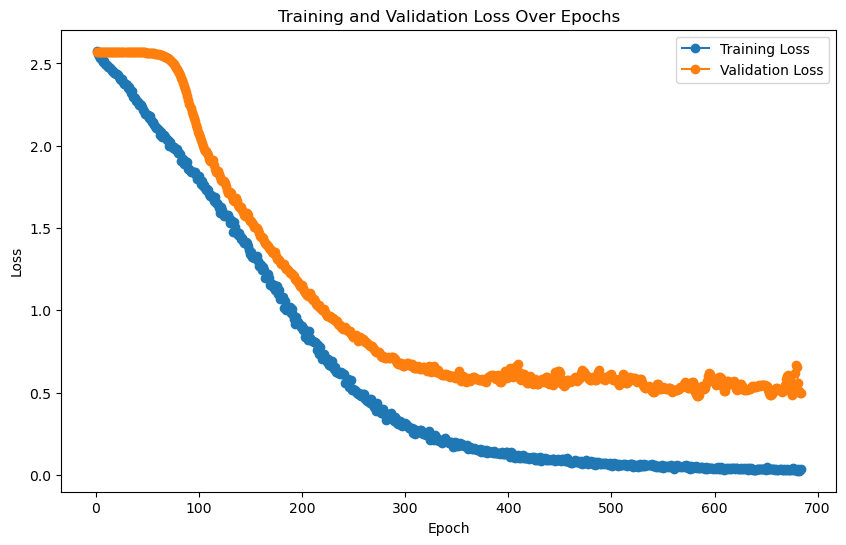

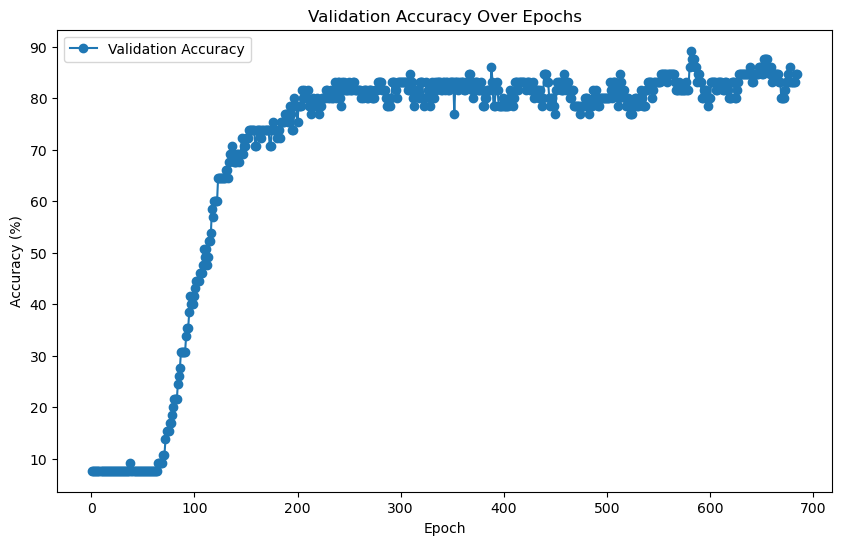


Evaluating on the test set...
    Test Batch [1/20], Loss: 0.5608

Final Test Loss: 0.9647, Test Accuracy: 82.11%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)

LOG: Training features shape: (260, 64), Training labels shape: (260,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4886, 64), Test labels shape: (4886,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 47.69%

Validation Classification Report:
               precision    recall  f1

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)
Train reps shape: (260, 64)
Train labels shape: (260,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4886, 64)
Test labels shape: (4886,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6317  |  Val Loss: 2.5692
Validation loss improved from inf to 2.5692.
[Epoch 2/1000] Train Loss: 2.5495  |  Val Loss: 2.5323
Validation loss improved from 2.5692 to 2.5323.
[Epoch 3/1000] Train Loss: 2.5216  |  Val Loss: 2.5203
Validation loss improved from 2.5323 to 2.5203.
[Epoch 4/1000] Train Loss: 2.5041  |  Val Loss: 2.5158
Validation loss improved from 2.5203 to 2.5158.
[Epoch 5/1000] Train Loss: 2.4962  |  Val Loss: 2.5128
Validation loss improved from 2.5158 to 2.5128.
[Epoch 6/1000] Train Loss: 2.4851  |  Val Loss: 2.5003
Validation loss improved from 2.5128 to 2.5003.
[Epoch 7/1000] Train Loss: 2.4656  |  Val Loss: 2.4922
Validation loss improved from 2.5003 to 2.4922.
[Epoch 8/1000] Train Loss: 2.4582  |  Val Loss: 2.4881
Validation loss improved from 2.4922 to 2.4881.
[Epoch 9/1000] Train Loss: 2.4496  |  Val Loss: 2.4806
Validation loss improved from 2.4881 to 2.4806.
[Epoch 10/1000] Train Loss: 2.4409  |  Val Loss: 2.4748
Validation loss impr

[Epoch 16/1000] Train Loss: 2.4153  |  Val Loss: 2.4477
Validation loss improved from 2.4503 to 2.4477.
[Epoch 17/1000] Train Loss: 2.4094  |  Val Loss: 2.4507
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 18/1000] Train Loss: 2.4046  |  Val Loss: 2.4465
Validation loss improved from 2.4477 to 2.4465.
[Epoch 19/1000] Train Loss: 2.3985  |  Val Loss: 2.4439
Validation loss improved from 2.4465 to 2.4439.


[Epoch 20/1000] Train Loss: 2.3993  |  Val Loss: 2.4474
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 21/1000] Train Loss: 2.3996  |  Val Loss: 2.4497
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 22/1000] Train Loss: 2.4038  |  Val Loss: 2.4543
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 23/1000] Train Loss: 2.4055  |  Val Loss: 2.4555
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 24/1000] Train Loss: 2.4021  |  Val Loss: 2.4524
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 25/1000] Train Loss: 2.4005  |  Val Loss: 2.4585
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 26/1000] Train Loss: 2.3985  |  Val Loss: 2.4456
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 27/1000] Train Loss: 2.3850  |  Val Loss: 2.4407
Validation loss improved from 2.4439 to 2.4407.
[Epoch 28/1000] Train Loss: 2.3788  |  Val Loss: 2.4391
Validation loss improved from 2.4407 to 2.4391.
[Epoch 29/1000] Train 

[Epoch 36/1000] Train Loss: 2.3673  |  Val Loss: 2.4379
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 37/1000] Train Loss: 2.3575  |  Val Loss: 2.4304
Validation loss improved from 2.4324 to 2.4304.
[Epoch 38/1000] Train Loss: 2.3494  |  Val Loss: 2.4296
Validation loss improved from 2.4304 to 2.4296.
[Epoch 39/1000] Train Loss: 2.3465  |  Val Loss: 2.4202
Validation loss improved from 2.4296 to 2.4202.
[Epoch 40/1000] Train Loss: 2.3360  |  Val Loss: 2.4118
Validation loss improved from 2.4202 to 2.4118.
[Epoch 41/1000] Train Loss: 2.3329  |  Val Loss: 2.4153
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 2.3383  |  Val Loss: 2.4420
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 43/1000] Train Loss: 2.3479  |  Val Loss: 2.4137
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 44/1000] Train Loss: 2.3461  |  Val Loss: 2.4196
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 45/1000] Train Loss: 2.3430

[Epoch 58/1000] Train Loss: 2.2472  |  Val Loss: 2.3363
Validation loss improved from 2.3493 to 2.3363.
[Epoch 59/1000] Train Loss: 2.2430  |  Val Loss: 2.3316
Validation loss improved from 2.3363 to 2.3316.
[Epoch 60/1000] Train Loss: 2.2397  |  Val Loss: 2.3259
Validation loss improved from 2.3316 to 2.3259.
[Epoch 61/1000] Train Loss: 2.2759  |  Val Loss: 2.3100
Validation loss improved from 2.3259 to 2.3100.
[Epoch 62/1000] Train Loss: 2.2437  |  Val Loss: 2.3656
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 2.2266  |  Val Loss: 2.3936
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 64/1000] Train Loss: 2.3550  |  Val Loss: 2.2910
Validation loss improved from 2.3100 to 2.2910.
[Epoch 65/1000] Train Loss: 2.2259  |  Val Loss: 2.4099
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 2.2805  |  Val Loss: 2.3011
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 2.2022  |  V

[Epoch 77/1000] Train Loss: 2.1086  |  Val Loss: 2.2109
Validation loss improved from 2.2306 to 2.2109.
[Epoch 78/1000] Train Loss: 2.1025  |  Val Loss: 2.2161
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 2.0992  |  Val Loss: 2.2026
Validation loss improved from 2.2109 to 2.2026.
[Epoch 80/1000] Train Loss: 2.1113  |  Val Loss: 2.2112
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 81/1000] Train Loss: 2.1181  |  Val Loss: 2.1855
Validation loss improved from 2.2026 to 2.1855.
[Epoch 82/1000] Train Loss: 2.0755  |  Val Loss: 2.1669
Validation loss improved from 2.1855 to 2.1669.
[Epoch 83/1000] Train Loss: 2.0741  |  Val Loss: 2.1836
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 84/1000] Train Loss: 2.0511  |  Val Loss: 2.1636
Validation loss improved from 2.1669 to 2.1636.
[Epoch 85/1000] Train Loss: 2.0453  |  Val Loss: 2.1673
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 2.0826  |  V

[Epoch 97/1000] Train Loss: 1.9803  |  Val Loss: 2.0762
Validation loss improved from 2.0955 to 2.0762.
[Epoch 98/1000] Train Loss: 1.9484  |  Val Loss: 2.0669
Validation loss improved from 2.0762 to 2.0669.
[Epoch 99/1000] Train Loss: 1.9653  |  Val Loss: 2.0809
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 100/1000] Train Loss: 1.9825  |  Val Loss: 2.0652
Validation loss improved from 2.0669 to 2.0652.
[Epoch 101/1000] Train Loss: 1.9794  |  Val Loss: 2.1157
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 2.0211  |  Val Loss: 2.1001
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 1.9573  |  Val Loss: 2.0733
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1000] Train Loss: 1.9553  |  Val Loss: 2.1439
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 105/1000] Train Loss: 1.9439  |  Val Loss: 2.0632
Validation loss improved from 2.0652 to 2.0632.
[Epoch 106/1000] Train Loss:

[Epoch 118/1000] Train Loss: 1.9951  |  Val Loss: 2.0453
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 119/1000] Train Loss: 1.8791  |  Val Loss: 2.0678
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 120/1000] Train Loss: 1.8720  |  Val Loss: 2.0637
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 121/1000] Train Loss: 1.8685  |  Val Loss: 2.0187
Validation loss improved from 2.0301 to 2.0187.
[Epoch 122/1000] Train Loss: 1.8432  |  Val Loss: 2.0003
Validation loss improved from 2.0187 to 2.0003.
[Epoch 123/1000] Train Loss: 1.8391  |  Val Loss: 2.0048
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1000] Train Loss: 1.8367  |  Val Loss: 2.0260
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 125/1000] Train Loss: 1.8465  |  Val Loss: 2.0558
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 126/1000] Train Loss: 1.8880  |  Val Loss: 2.0687
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 127

[Epoch 136/1000] Train Loss: 1.8674  |  Val Loss: 2.0216
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 137/1000] Train Loss: 1.8350  |  Val Loss: 2.0620
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 138/1000] Train Loss: 1.8448  |  Val Loss: 2.0018
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 139/1000] Train Loss: 1.8423  |  Val Loss: 1.9817
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 140/1000] Train Loss: 1.8075  |  Val Loss: 1.9638
Validation loss improved from 1.9726 to 1.9638.
[Epoch 141/1000] Train Loss: 1.8103  |  Val Loss: 1.9624
Validation loss improved from 1.9638 to 1.9624.
[Epoch 142/1000] Train Loss: 1.8278  |  Val Loss: 2.0316
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 143/1000] Train Loss: 1.8566  |  Val Loss: 1.9573
Validation loss improved from 1.9624 to 1.9573.
[Epoch 144/1000] Train Loss: 1.7852  |  Val Loss: 1.9559
Validation loss improved from 1.9573 to 1.9559.
[Epoch 145/1000] Train Lo

[Epoch 156/1000] Train Loss: 1.7576  |  Val Loss: 1.9879
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 1.7657  |  Val Loss: 1.9766
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/1000] Train Loss: 1.7743  |  Val Loss: 1.9349
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 159/1000] Train Loss: 1.7732  |  Val Loss: 1.9845
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 160/1000] Train Loss: 1.7810  |  Val Loss: 1.9626
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 161/1000] Train Loss: 1.7562  |  Val Loss: 1.9490
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 162/1000] Train Loss: 1.7352  |  Val Loss: 1.9269
Validation loss improved from 1.9339 to 1.9269.
[Epoch 163/1000] Train Loss: 1.7241  |  Val Loss: 1.9168
Validation loss improved from 1.9269 to 1.9168.
[Epoch 164/1000] Train Loss: 1.7163  |  Val Loss: 1.9370
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 165/10

[Epoch 177/1000] Train Loss: 1.8916  |  Val Loss: 1.9189
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 178/1000] Train Loss: 1.7506  |  Val Loss: 1.9369
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 179/1000] Train Loss: 1.7715  |  Val Loss: 1.9244
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 180/1000] Train Loss: 1.7414  |  Val Loss: 1.9395
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 181/1000] Train Loss: 1.7397  |  Val Loss: 1.9302
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 182/1000] Train Loss: 1.7201  |  Val Loss: 1.9257
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 183/1000] Train Loss: 1.7139  |  Val Loss: 1.9568
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 184/1000] Train Loss: 1.8041  |  Val Loss: 1.9496
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 185/1000] Train Loss: 1.7334  |  Val Loss: 1.9130
Validation loss improved from 1.9168 to 1.9130.

[Epoch 198/1000] Train Loss: 2.1624  |  Val Loss: 1.9027
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 199/1000] Train Loss: 1.9693  |  Val Loss: 1.9500
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 200/1000] Train Loss: 1.8531  |  Val Loss: 2.1919
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 201/1000] Train Loss: 1.7565  |  Val Loss: 2.0027
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 202/1000] Train Loss: 1.7104  |  Val Loss: 2.0286
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 203/1000] Train Loss: 1.7555  |  Val Loss: 1.9362
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 204/1000] Train Loss: 1.7248  |  Val Loss: 1.9432
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 205/1000] Train Loss: 1.6775  |  Val Loss: 1.9715
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 206/1000] Train Loss: 1.6696  |  Val Loss: 1.9229
!! Validation loss did NOT improve !! Patience:

[Epoch 217/1000] Train Loss: 1.6248  |  Val Loss: 1.9065
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 218/1000] Train Loss: 1.6316  |  Val Loss: 1.9438
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 219/1000] Train Loss: 1.6311  |  Val Loss: 1.9166
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 220/1000] Train Loss: 1.6040  |  Val Loss: 1.9377
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 221/1000] Train Loss: 1.6483  |  Val Loss: 1.9061
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 222/1000] Train Loss: 1.6494  |  Val Loss: 1.9448
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 223/1000] Train Loss: 1.6387  |  Val Loss: 1.9492
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 224/1000] Train Loss: 1.6828  |  Val Loss: 1.9112
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 225/1000] Train Loss: 1.6681  |  Val Loss: 1.9446
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 237/1000] Train Loss: 1.6033  |  Val Loss: 1.9678
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 238/1000] Train Loss: 1.6800  |  Val Loss: 1.9333
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 239/1000] Train Loss: 1.6075  |  Val Loss: 1.8984
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 240/1000] Train Loss: 1.6109  |  Val Loss: 1.9274
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 241/1000] Train Loss: 1.6007  |  Val Loss: 1.8769
Validation loss improved from 1.8848 to 1.8769.
[Epoch 242/1000] Train Loss: 1.5779  |  Val Loss: 1.8934
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 243/1000] Train Loss: 1.5841  |  Val Loss: 1.8975
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 244/1000] Train Loss: 1.5783  |  Val Loss: 1.9169
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 245/1000] Train Loss: 1.5775  |  Val Loss: 1.9312
!! Validation loss did NOT improve !! Patience: 4/100
[Epo

[Epoch 257/1000] Train Loss: 1.6208  |  Val Loss: 1.9495
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 258/1000] Train Loss: 1.5648  |  Val Loss: 1.9542
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 259/1000] Train Loss: 1.6087  |  Val Loss: 2.0275
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 260/1000] Train Loss: 1.6655  |  Val Loss: 1.9212
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 261/1000] Train Loss: 1.6571  |  Val Loss: 1.9074
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 262/1000] Train Loss: 1.5607  |  Val Loss: 1.8820
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 263/1000] Train Loss: 1.5520  |  Val Loss: 1.9052
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 264/1000] Train Loss: 1.5646  |  Val Loss: 1.8954
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 265/1000] Train Loss: 1.5539  |  Val Loss: 1.9168
!! Validation loss did NOT improve !! Patience:

[Epoch 275/1000] Train Loss: 1.6060  |  Val Loss: 1.9590
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 276/1000] Train Loss: 1.5425  |  Val Loss: 1.9359
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 277/1000] Train Loss: 1.5358  |  Val Loss: 2.0197
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 278/1000] Train Loss: 1.6693  |  Val Loss: 1.9060
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 279/1000] Train Loss: 1.5341  |  Val Loss: 1.9337
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 280/1000] Train Loss: 1.5729  |  Val Loss: 1.9338
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 281/1000] Train Loss: 1.5342  |  Val Loss: 1.9458
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 282/1000] Train Loss: 1.6029  |  Val Loss: 2.0006
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 283/1000] Train Loss: 1.5770  |  Val Loss: 1.9638
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 295/1000] Train Loss: 1.8242  |  Val Loss: 1.9542
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 296/1000] Train Loss: 1.7434  |  Val Loss: 2.0948
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 297/1000] Train Loss: 1.6322  |  Val Loss: 2.1250
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 298/1000] Train Loss: 1.6216  |  Val Loss: 2.0104
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 299/1000] Train Loss: 1.6288  |  Val Loss: 1.9949
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 300/1000] Train Loss: 1.6069  |  Val Loss: 1.9828
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 301/1000] Train Loss: 1.6416  |  Val Loss: 1.9828
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 302/1000] Train Loss: 1.6248  |  Val Loss: 2.0224
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 303/1000] Train Loss: 1.6946  |  Val Loss: 2.0184
!! Validation loss did NOT improve !! Patience:

[Epoch 313/1000] Train Loss: 1.4917  |  Val Loss: 1.9272
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 314/1000] Train Loss: 1.4891  |  Val Loss: 1.9242
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 315/1000] Train Loss: 1.4998  |  Val Loss: 1.9773
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 316/1000] Train Loss: 1.5385  |  Val Loss: 1.9651
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 317/1000] Train Loss: 1.5773  |  Val Loss: 1.9481
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 318/1000] Train Loss: 1.4943  |  Val Loss: 1.9497
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 319/1000] Train Loss: 1.4899  |  Val Loss: 1.9479
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 320/1000] Train Loss: 1.4871  |  Val Loss: 1.9805
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 321/1000] Train Loss: 1.5101  |  Val Loss: 1.9295
!! Validation loss did NOT improve !! Patience:

[Epoch 335/1000] Train Loss: 1.5310  |  Val Loss: 1.9812
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 336/1000] Train Loss: 1.5440  |  Val Loss: 2.0376
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 337/1000] Train Loss: 1.6019  |  Val Loss: 2.0008
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 338/1000] Train Loss: 1.6095  |  Val Loss: 2.0756
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 339/1000] Train Loss: 1.5885  |  Val Loss: 2.0102
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 340/1000] Train Loss: 1.5945  |  Val Loss: 1.9815
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 341/1000] Train Loss: 1.5717  |  Val Loss: 1.9064
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 342/1000] Train Loss: 1.6293  |  Val Loss: 1.9489
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 343/1000] Train Loss: 1.6557  |  Val Loss: 1.8898
!! Validation loss did NOT improve !! Patience:

[Epoch 354/1000] Train Loss: 1.5455  |  Val Loss: 1.9690
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 355/1000] Train Loss: 1.5672  |  Val Loss: 2.0144
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 356/1000] Train Loss: 1.5089  |  Val Loss: 2.0089
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 357/1000] Train Loss: 1.4966  |  Val Loss: 1.9876
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 358/1000] Train Loss: 1.4656  |  Val Loss: 1.9654
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 359/1000] Train Loss: 1.4521  |  Val Loss: 1.9472
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 360/1000] Train Loss: 1.4374  |  Val Loss: 1.9390
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 361/1000] Train Loss: 1.4453  |  Val Loss: 1.9567
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 362/1000] Train Loss: 1.4440  |  Val Loss: 1.9411
!! Validation loss did NOT improve !! Patience:

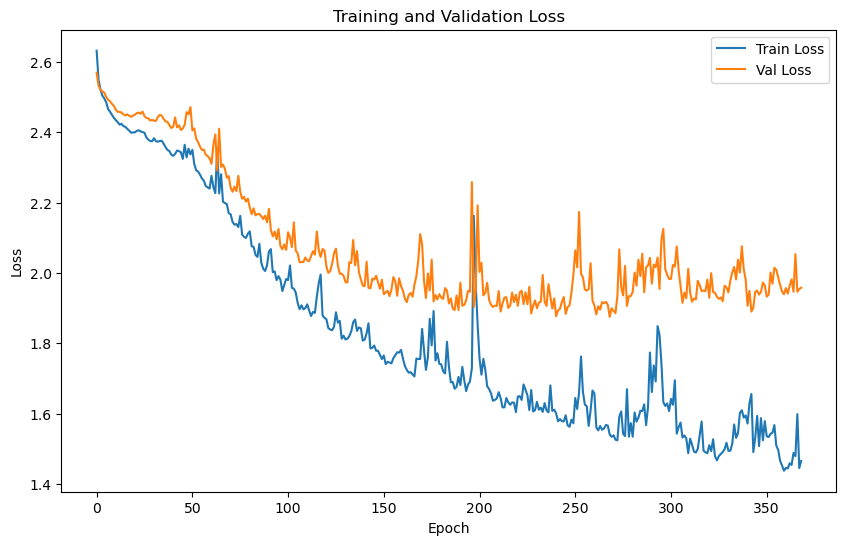

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.8187 | Test Accuracy: 37.54%


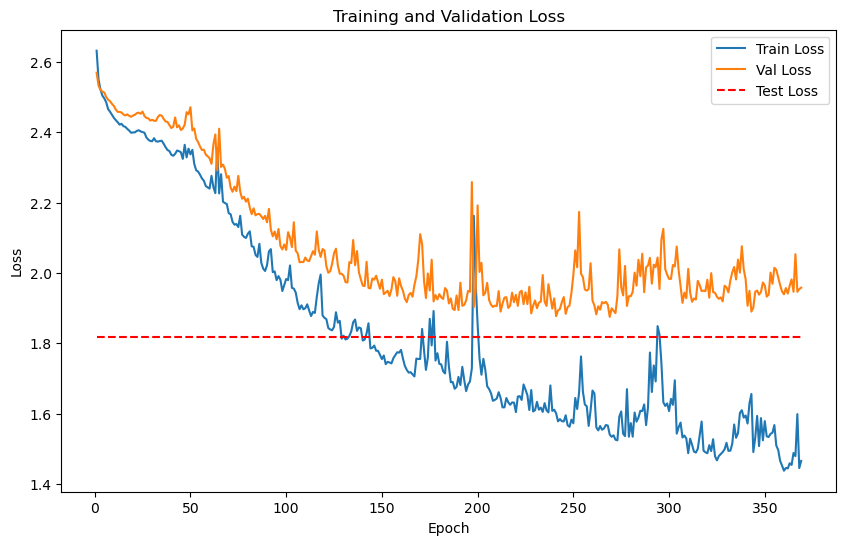

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.7266
Epoch [1/2000], Avg Train Loss: 8.7266
Epoch [1/2000], Avg Val Loss: 5.4949
Validation loss improved from inf to 5.4949. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.4321
Epoch [2/2000], Avg Train Loss: 8.4321
Epoch [2/2000], Avg Val Loss: 5.4637
Validation loss improved from 5.4949 to 5.4637. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.5638
Epoch [3/2000], Avg Train Loss: 8.5638
Epoch [3/2000], Avg Val Loss: 5.4328
Validation loss improved from 5.4637 to 5.4328. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.4247
Epoch [4/2000], Avg Train Loss: 8.4247
Epoch [4/2000], Avg Val Loss: 5.4021
Validation loss improved from 5.4328 to 5.4021. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.3593
Epoch [5/2000], Avg Train Loss: 8.3593
Epoch [5/2000], Avg Val Loss: 5.3712
Validation loss improved from 5.4021 to 5.3712. Saving mode

    Batch [1/1], Train Loss: 7.8938
Epoch [12/2000], Avg Train Loss: 7.8938
Epoch [12/2000], Avg Val Loss: 5.1615
Validation loss improved from 5.1911 to 5.1615. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.9528
Epoch [13/2000], Avg Train Loss: 7.9528
Epoch [13/2000], Avg Val Loss: 5.1323
Validation loss improved from 5.1615 to 5.1323. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.7257
Epoch [14/2000], Avg Train Loss: 7.7257
Epoch [14/2000], Avg Val Loss: 5.1030
Validation loss improved from 5.1323 to 5.1030. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.6595
Epoch [15/2000], Avg Train Loss: 7.6595
Epoch [15/2000], Avg Val Loss: 5.0739
Validation loss improved from 5.1030 to 5.0739. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.5932
Epoch [16/2000], Avg Train Loss: 7.5932


Epoch [16/2000], Avg Val Loss: 5.0448
Validation loss improved from 5.0739 to 5.0448. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.5512
Epoch [17/2000], Avg Train Loss: 7.5512
Epoch [17/2000], Avg Val Loss: 5.0162
Validation loss improved from 5.0448 to 5.0162. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.5510
Epoch [18/2000], Avg Train Loss: 7.5510
Epoch [18/2000], Avg Val Loss: 4.9877
Validation loss improved from 5.0162 to 4.9877. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.5662
Epoch [19/2000], Avg Train Loss: 7.5662
Epoch [19/2000], Avg Val Loss: 4.9592
Validation loss improved from 4.9877 to 4.9592. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.3757
Epoch [20/2000], Avg Train Loss: 7.3757
Epoch [20/2000], Avg Val Loss: 4.9308
Validation loss improved from 4.9592 to 4.9308. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.9764
Epoch [30/2000], Avg Train Loss: 6.9764
Epoch [30/2000], Avg Val Loss: 4.6555
Validation loss improved from 4.6818 to 4.6555. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.8204
Epoch [31/2000], Avg Train Loss: 6.8204
Epoch [31/2000], Avg Val Loss: 4.6296
Validation loss improved from 4.6555 to 4.6296. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.8560
Epoch [32/2000], Avg Train Loss: 6.8560
Epoch [32/2000], Avg Val Loss: 4.6041
Validation loss improved from 4.6296 to 4.6041. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.8458
Epoch [33/2000], Avg Train Loss: 6.8458
Epoch [33/2000], Avg Val Loss: 4.5791
Validation loss improved from 4.6041 to 4.5791. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.7738
Epoch [34/2000], Avg Train Loss: 6.7738
Epoch [34/2000], Avg Val Loss: 4.5545
Validation loss improved from 4.5791 to 4.

    Batch [1/1], Train Loss: 6.5422
Epoch [42/2000], Avg Train Loss: 6.5422
Epoch [42/2000], Avg Val Loss: 4.3732
Validation loss improved from 4.3943 to 4.3732. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 6.5383
Epoch [43/2000], Avg Train Loss: 6.5383
Epoch [43/2000], Avg Val Loss: 4.3527
Validation loss improved from 4.3732 to 4.3527. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.5442
Epoch [44/2000], Avg Train Loss: 6.5442
Epoch [44/2000], Avg Val Loss: 4.3327
Validation loss improved from 4.3527 to 4.3327. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 6.4447
Epoch [45/2000], Avg Train Loss: 6.4447
Epoch [45/2000], Avg Val Loss: 4.3131
Validation loss improved from 4.3327 to 4.3131. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.3536
Epoch [46/2000], Avg Train Loss: 6.3536
Epoch [46/2000], Avg Val Loss: 4.2940
Validation loss improved from 4.3131 to 4.

    Batch [1/1], Train Loss: 6.1906
Epoch [50/2000], Avg Train Loss: 6.1906
Epoch [50/2000], Avg Val Loss: 4.2231
Validation loss improved from 4.2401 to 4.2231. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.2681
Epoch [51/2000], Avg Train Loss: 6.2681
Epoch [51/2000], Avg Val Loss: 4.2067
Validation loss improved from 4.2231 to 4.2067. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.2284
Epoch [52/2000], Avg Train Loss: 6.2284
Epoch [52/2000], Avg Val Loss: 4.1908
Validation loss improved from 4.2067 to 4.1908. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 6.1991
Epoch [53/2000], Avg Train Loss: 6.1991
Epoch [53/2000], Avg Val Loss: 4.1754
Validation loss improved from 4.1908 to 4.1754. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 6.1684
Epoch [54/2000], Avg Train Loss: 6.1684
Epoch [54/2000], Avg Val Loss: 4.1605
Validation loss improved from 4.1754 to 4.

    Batch [1/1], Train Loss: 5.8810
Epoch [68/2000], Avg Train Loss: 5.8810
Epoch [68/2000], Avg Val Loss: 3.9962
Validation loss improved from 4.0054 to 3.9962. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.8843
Epoch [69/2000], Avg Train Loss: 5.8843
Epoch [69/2000], Avg Val Loss: 3.9873
Validation loss improved from 3.9962 to 3.9873. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.8683
Epoch [70/2000], Avg Train Loss: 5.8683
Epoch [70/2000], Avg Val Loss: 3.9787
Validation loss improved from 3.9873 to 3.9787. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.8566
Epoch [71/2000], Avg Train Loss: 5.8566
Epoch [71/2000], Avg Val Loss: 3.9704
Validation loss improved from 3.9787 to 3.9704. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.8545
Epoch [72/2000], Avg Train Loss: 5.8545
Epoch [72/2000], Avg Val Loss: 3.9624
Validation loss improved from 3.9704 to 3.

    Batch [1/1], Train Loss: 5.7527
Epoch [81/2000], Avg Train Loss: 5.7527
Epoch [81/2000], Avg Val Loss: 3.9033
Validation loss improved from 3.9089 to 3.9033. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.6922
Epoch [82/2000], Avg Train Loss: 5.6922
Epoch [82/2000], Avg Val Loss: 3.8979
Validation loss improved from 3.9033 to 3.8979. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.7045
Epoch [83/2000], Avg Train Loss: 5.7045
Epoch [83/2000], Avg Val Loss: 3.8927
Validation loss improved from 3.8979 to 3.8927. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.6992
Epoch [84/2000], Avg Train Loss: 5.6992
Epoch [84/2000], Avg Val Loss: 3.8877
Validation loss improved from 3.8927 to 3.8877. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.6826
Epoch [85/2000], Avg Train Loss: 5.6826
Epoch [85/2000], Avg Val Loss: 3.8828
Validation loss improved from 3.8877 to 3.

Epoch [104/2000], Avg Val Loss: 3.8131
Validation loss improved from 3.8159 to 3.8131. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 5.5229
Epoch [105/2000], Avg Train Loss: 5.5229
Epoch [105/2000], Avg Val Loss: 3.8103
Validation loss improved from 3.8131 to 3.8103. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.5105
Epoch [106/2000], Avg Train Loss: 5.5105
Epoch [106/2000], Avg Val Loss: 3.8076
Validation loss improved from 3.8103 to 3.8076. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 5.5240
Epoch [107/2000], Avg Train Loss: 5.5240
Epoch [107/2000], Avg Val Loss: 3.8050
Validation loss improved from 3.8076 to 3.8050. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.5460
Epoch [108/2000], Avg Train Loss: 5.5460
Epoch [108/2000], Avg Val Loss: 3.8024
Validation loss improved from 3.8050 to 3.8024. Saving model...

LOG: Epoch [109/2000] - Training
    Bat

Epoch [117/2000], Avg Val Loss: 3.7813
Validation loss improved from 3.7835 to 3.7813. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 5.4829
Epoch [118/2000], Avg Train Loss: 5.4829
Epoch [118/2000], Avg Val Loss: 3.7792
Validation loss improved from 3.7813 to 3.7792. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 5.5031
Epoch [119/2000], Avg Train Loss: 5.5031
Epoch [119/2000], Avg Val Loss: 3.7770
Validation loss improved from 3.7792 to 3.7770. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 5.4458
Epoch [120/2000], Avg Train Loss: 5.4458
Epoch [120/2000], Avg Val Loss: 3.7750
Validation loss improved from 3.7770 to 3.7750. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 5.4628
Epoch [121/2000], Avg Train Loss: 5.4628
Epoch [121/2000], Avg Val Loss: 3.7729
Validation loss improved from 3.7750 to 3.7729. Saving model...

LOG: Epoch [122/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.4261
Epoch [141/2000], Avg Train Loss: 5.4261
Epoch [141/2000], Avg Val Loss: 3.7381
Validation loss improved from 3.7396 to 3.7381. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 5.4104
Epoch [142/2000], Avg Train Loss: 5.4104
Epoch [142/2000], Avg Val Loss: 3.7366
Validation loss improved from 3.7381 to 3.7366. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 5.3742
Epoch [143/2000], Avg Train Loss: 5.3742
Epoch [143/2000], Avg Val Loss: 3.7352
Validation loss improved from 3.7366 to 3.7352. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 5.3380
Epoch [144/2000], Avg Train Loss: 5.3380
Epoch [144/2000], Avg Val Loss: 3.7337
Validation loss improved from 3.7352 to 3.7337. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.3060
Epoch [145/2000], Avg Train Loss: 5.3060
Epoch [145/2000], Avg Val Loss: 3.7323
Validation loss improved fro

Epoch [156/2000], Avg Val Loss: 3.7177
Validation loss improved from 3.7189 to 3.7177. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 5.3143
Epoch [157/2000], Avg Train Loss: 5.3143
Epoch [157/2000], Avg Val Loss: 3.7165
Validation loss improved from 3.7177 to 3.7165. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 5.3311
Epoch [158/2000], Avg Train Loss: 5.3311
Epoch [158/2000], Avg Val Loss: 3.7153
Validation loss improved from 3.7165 to 3.7153. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 5.3326
Epoch [159/2000], Avg Train Loss: 5.3326
Epoch [159/2000], Avg Val Loss: 3.7141
Validation loss improved from 3.7153 to 3.7141. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 5.2939
Epoch [160/2000], Avg Train Loss: 5.2939
Epoch [160/2000], Avg Val Loss: 3.7129
Validation loss improved from 3.7141 to 3.7129. Saving model...

LOG: Epoch [161/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.2732
Epoch [180/2000], Avg Train Loss: 5.2732
Epoch [180/2000], Avg Val Loss: 3.6919
Validation loss improved from 3.6929 to 3.6919. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 5.2684
Epoch [181/2000], Avg Train Loss: 5.2684
Epoch [181/2000], Avg Val Loss: 3.6910
Validation loss improved from 3.6919 to 3.6910. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 5.2696
Epoch [182/2000], Avg Train Loss: 5.2696
Epoch [182/2000], Avg Val Loss: 3.6901
Validation loss improved from 3.6910 to 3.6901. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 5.2481
Epoch [183/2000], Avg Train Loss: 5.2481
Epoch [183/2000], Avg Val Loss: 3.6891
Validation loss improved from 3.6901 to 3.6891. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 5.2496
Epoch [184/2000], Avg Train Loss: 5.2496
Epoch [184/2000], Avg Val Loss: 3.6882
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2462
Epoch [195/2000], Avg Train Loss: 5.2462
Epoch [195/2000], Avg Val Loss: 3.6778
Validation loss improved from 3.6788 to 3.6778. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 5.2392
Epoch [196/2000], Avg Train Loss: 5.2392
Epoch [196/2000], Avg Val Loss: 3.6769
Validation loss improved from 3.6778 to 3.6769. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 5.2555
Epoch [197/2000], Avg Train Loss: 5.2555
Epoch [197/2000], Avg Val Loss: 3.6760
Validation loss improved from 3.6769 to 3.6760. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 5.2676
Epoch [198/2000], Avg Train Loss: 5.2676
Epoch [198/2000], Avg Val Loss: 3.6750
Validation loss improved from 3.6760 to 3.6750. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 5.2405
Epoch [199/2000], Avg Train Loss: 5.2405
Epoch [199/2000], Avg Val Loss: 3.6741
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2201
Epoch [218/2000], Avg Train Loss: 5.2201
Epoch [218/2000], Avg Val Loss: 3.6579
Validation loss improved from 3.6587 to 3.6579. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 5.2164
Epoch [219/2000], Avg Train Loss: 5.2164
Epoch [219/2000], Avg Val Loss: 3.6571
Validation loss improved from 3.6579 to 3.6571. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 5.2093
Epoch [220/2000], Avg Train Loss: 5.2093
Epoch [220/2000], Avg Val Loss: 3.6563
Validation loss improved from 3.6571 to 3.6563. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 5.1857
Epoch [221/2000], Avg Train Loss: 5.1857
Epoch [221/2000], Avg Val Loss: 3.6555
Validation loss improved from 3.6563 to 3.6555. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 5.2157
Epoch [222/2000], Avg Train Loss: 5.2157
Epoch [222/2000], Avg Val Loss: 3.6548
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1460
Epoch [231/2000], Avg Train Loss: 5.1460
Epoch [231/2000], Avg Val Loss: 3.6481
Validation loss improved from 3.6489 to 3.6481. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 5.1844
Epoch [232/2000], Avg Train Loss: 5.1844
Epoch [232/2000], Avg Val Loss: 3.6474
Validation loss improved from 3.6481 to 3.6474. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 5.1831
Epoch [233/2000], Avg Train Loss: 5.1831
Epoch [233/2000], Avg Val Loss: 3.6466
Validation loss improved from 3.6474 to 3.6466. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 5.1887
Epoch [234/2000], Avg Train Loss: 5.1887
Epoch [234/2000], Avg Val Loss: 3.6458
Validation loss improved from 3.6466 to 3.6458. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 5.1764
Epoch [235/2000], Avg Train Loss: 5.1764
Epoch [235/2000], Avg Val Loss: 3.6450
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1329
Epoch [257/2000], Avg Train Loss: 5.1329
Epoch [257/2000], Avg Val Loss: 3.6270
Validation loss improved from 3.6279 to 3.6270. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 5.1289
Epoch [258/2000], Avg Train Loss: 5.1289
Epoch [258/2000], Avg Val Loss: 3.6260
Validation loss improved from 3.6270 to 3.6260. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 5.1403
Epoch [259/2000], Avg Train Loss: 5.1403
Epoch [259/2000], Avg Val Loss: 3.6251
Validation loss improved from 3.6260 to 3.6251. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 5.1463
Epoch [260/2000], Avg Train Loss: 5.1463
Epoch [260/2000], Avg Val Loss: 3.6242
Validation loss improved from 3.6251 to 3.6242. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 5.1422
Epoch [261/2000], Avg Train Loss: 5.1422
Epoch [261/2000], Avg Val Loss: 3.6233
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1293
Epoch [271/2000], Avg Train Loss: 5.1293
Epoch [271/2000], Avg Val Loss: 3.6150
Validation loss improved from 3.6158 to 3.6150. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 5.1209
Epoch [272/2000], Avg Train Loss: 5.1209
Epoch [272/2000], Avg Val Loss: 3.6142
Validation loss improved from 3.6150 to 3.6142. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 5.1572
Epoch [273/2000], Avg Train Loss: 5.1572
Epoch [273/2000], Avg Val Loss: 3.6134
Validation loss improved from 3.6142 to 3.6134. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 5.1249
Epoch [274/2000], Avg Train Loss: 5.1249
Epoch [274/2000], Avg Val Loss: 3.6127
Validation loss improved from 3.6134 to 3.6127. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 5.1157
Epoch [275/2000], Avg Train Loss: 5.1157
Epoch [275/2000], Avg Val Loss: 3.6118
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0624
Epoch [295/2000], Avg Train Loss: 5.0624
Epoch [295/2000], Avg Val Loss: 3.5920
Validation loss improved from 3.5930 to 3.5920. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 5.1104
Epoch [296/2000], Avg Train Loss: 5.1104
Epoch [296/2000], Avg Val Loss: 3.5910
Validation loss improved from 3.5920 to 3.5910. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 5.1207
Epoch [297/2000], Avg Train Loss: 5.1207
Epoch [297/2000], Avg Val Loss: 3.5901
Validation loss improved from 3.5910 to 3.5901. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 5.0755
Epoch [298/2000], Avg Train Loss: 5.0755
Epoch [298/2000], Avg Val Loss: 3.5891
Validation loss improved from 3.5901 to 3.5891. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 5.1028
Epoch [299/2000], Avg Train Loss: 5.1028
Epoch [299/2000], Avg Val Loss: 3.5881
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1120
Epoch [309/2000], Avg Train Loss: 5.1120
Epoch [309/2000], Avg Val Loss: 3.5775
Validation loss improved from 3.5786 to 3.5775. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 5.0680
Epoch [310/2000], Avg Train Loss: 5.0680
Epoch [310/2000], Avg Val Loss: 3.5765
Validation loss improved from 3.5775 to 3.5765. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 5.0654
Epoch [311/2000], Avg Train Loss: 5.0654
Epoch [311/2000], Avg Val Loss: 3.5755
Validation loss improved from 3.5765 to 3.5755. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 5.0698
Epoch [312/2000], Avg Train Loss: 5.0698
Epoch [312/2000], Avg Val Loss: 3.5744
Validation loss improved from 3.5755 to 3.5744. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 5.1029
Epoch [313/2000], Avg Train Loss: 5.1029
Epoch [313/2000], Avg Val Loss: 3.5734
Validation loss improved fro

Epoch [333/2000], Avg Val Loss: 3.5531
Validation loss improved from 3.5540 to 3.5531. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 5.0441
Epoch [334/2000], Avg Train Loss: 5.0441
Epoch [334/2000], Avg Val Loss: 3.5522
Validation loss improved from 3.5531 to 3.5522. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 5.0519
Epoch [335/2000], Avg Train Loss: 5.0519
Epoch [335/2000], Avg Val Loss: 3.5512
Validation loss improved from 3.5522 to 3.5512. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 5.0475
Epoch [336/2000], Avg Train Loss: 5.0475
Epoch [336/2000], Avg Val Loss: 3.5502
Validation loss improved from 3.5512 to 3.5502. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 5.0538
Epoch [337/2000], Avg Train Loss: 5.0538
Epoch [337/2000], Avg Val Loss: 3.5493
Validation loss improved from 3.5502 to 3.5493. Saving model...

LOG: Epoch [338/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0188
Epoch [345/2000], Avg Train Loss: 5.0188
Epoch [345/2000], Avg Val Loss: 3.5416
Validation loss improved from 3.5426 to 3.5416. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 5.0009
Epoch [346/2000], Avg Train Loss: 5.0009
Epoch [346/2000], Avg Val Loss: 3.5407
Validation loss improved from 3.5416 to 3.5407. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 5.0308
Epoch [347/2000], Avg Train Loss: 5.0308
Epoch [347/2000], Avg Val Loss: 3.5398
Validation loss improved from 3.5407 to 3.5398. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 5.0272
Epoch [348/2000], Avg Train Loss: 5.0272
Epoch [348/2000], Avg Val Loss: 3.5389
Validation loss improved from 3.5398 to 3.5389. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 5.0135
Epoch [349/2000], Avg Train Loss: 5.0135
Epoch [349/2000], Avg Val Loss: 3.5378
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0007
Epoch [373/2000], Avg Train Loss: 5.0007
Epoch [373/2000], Avg Val Loss: 3.5157
Validation loss improved from 3.5165 to 3.5157. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.9967
Epoch [374/2000], Avg Train Loss: 4.9967
Epoch [374/2000], Avg Val Loss: 3.5147
Validation loss improved from 3.5157 to 3.5147. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.9790
Epoch [375/2000], Avg Train Loss: 4.9790
Epoch [375/2000], Avg Val Loss: 3.5139
Validation loss improved from 3.5147 to 3.5139. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.9969
Epoch [376/2000], Avg Train Loss: 4.9969
Epoch [376/2000], Avg Val Loss: 3.5130
Validation loss improved from 3.5139 to 3.5130. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.9791
Epoch [377/2000], Avg Train Loss: 4.9791
Epoch [377/2000], Avg Val Loss: 3.5120
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9788
Epoch [383/2000], Avg Train Loss: 4.9788
Epoch [383/2000], Avg Val Loss: 3.5060
Validation loss improved from 3.5071 to 3.5060. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.9395
Epoch [384/2000], Avg Train Loss: 4.9395
Epoch [384/2000], Avg Val Loss: 3.5049
Validation loss improved from 3.5060 to 3.5049. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.9926
Epoch [385/2000], Avg Train Loss: 4.9926
Epoch [385/2000], Avg Val Loss: 3.5038
Validation loss improved from 3.5049 to 3.5038. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.9711
Epoch [386/2000], Avg Train Loss: 4.9711
Epoch [386/2000], Avg Val Loss: 3.5028
Validation loss improved from 3.5038 to 3.5028. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.9836
Epoch [387/2000], Avg Train Loss: 4.9836
Epoch [387/2000], Avg Val Loss: 3.5017
Validation loss improved fro

Epoch [410/2000], Avg Val Loss: 3.4838
Validation loss improved from 3.4845 to 3.4838. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.9557
Epoch [411/2000], Avg Train Loss: 4.9557
Epoch [411/2000], Avg Val Loss: 3.4831
Validation loss improved from 3.4838 to 3.4831. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.9604
Epoch [412/2000], Avg Train Loss: 4.9604
Epoch [412/2000], Avg Val Loss: 3.4824
Validation loss improved from 3.4831 to 3.4824. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.9606
Epoch [413/2000], Avg Train Loss: 4.9606
Epoch [413/2000], Avg Val Loss: 3.4817
Validation loss improved from 3.4824 to 3.4817. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.9310
Epoch [414/2000], Avg Train Loss: 4.9310
Epoch [414/2000], Avg Val Loss: 3.4810
Validation loss improved from 3.4817 to 3.4810. Saving model...

LOG: Epoch [415/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9539
Epoch [422/2000], Avg Train Loss: 4.9539
Epoch [422/2000], Avg Val Loss: 3.4757
Validation loss improved from 3.4764 to 3.4757. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 4.9127
Epoch [423/2000], Avg Train Loss: 4.9127
Epoch [423/2000], Avg Val Loss: 3.4749
Validation loss improved from 3.4757 to 3.4749. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 4.9032
Epoch [424/2000], Avg Train Loss: 4.9032
Epoch [424/2000], Avg Val Loss: 3.4741
Validation loss improved from 3.4749 to 3.4741. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 4.9334
Epoch [425/2000], Avg Train Loss: 4.9334
Epoch [425/2000], Avg Val Loss: 3.4734
Validation loss improved from 3.4741 to 3.4734. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.9130
Epoch [426/2000], Avg Train Loss: 4.9130
Epoch [426/2000], Avg Val Loss: 3.4726
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9064
Epoch [447/2000], Avg Train Loss: 4.9064
Epoch [447/2000], Avg Val Loss: 3.4605
Validation loss improved from 3.4609 to 3.4605. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.8760
Epoch [448/2000], Avg Train Loss: 4.8760
Epoch [448/2000], Avg Val Loss: 3.4600
Validation loss improved from 3.4605 to 3.4600. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.9199
Epoch [449/2000], Avg Train Loss: 4.9199
Epoch [449/2000], Avg Val Loss: 3.4596
Validation loss improved from 3.4600 to 3.4596. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.9339
Epoch [450/2000], Avg Train Loss: 4.9339
Epoch [450/2000], Avg Val Loss: 3.4590
Validation loss improved from 3.4596 to 3.4590. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 4.8760
Epoch [451/2000], Avg Train Loss: 4.8760
Epoch [451/2000], Avg Val Loss: 3.4584
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8700
Epoch [461/2000], Avg Train Loss: 4.8700
Epoch [461/2000], Avg Val Loss: 3.4523
Validation loss improved from 3.4529 to 3.4523. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.9139
Epoch [462/2000], Avg Train Loss: 4.9139
Epoch [462/2000], Avg Val Loss: 3.4519
Validation loss improved from 3.4523 to 3.4519. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.9046
Epoch [463/2000], Avg Train Loss: 4.9046
Epoch [463/2000], Avg Val Loss: 3.4513
Validation loss improved from 3.4519 to 3.4513. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 4.8954
Epoch [464/2000], Avg Train Loss: 4.8954
Epoch [464/2000], Avg Val Loss: 3.4508
Validation loss improved from 3.4513 to 3.4508. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 4.8845
Epoch [465/2000], Avg Train Loss: 4.8845
Epoch [465/2000], Avg Val Loss: 3.4502
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8601
Epoch [485/2000], Avg Train Loss: 4.8601
Epoch [485/2000], Avg Val Loss: 3.4395
Validation loss improved from 3.4401 to 3.4395. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.8873
Epoch [486/2000], Avg Train Loss: 4.8873
Epoch [486/2000], Avg Val Loss: 3.4389
Validation loss improved from 3.4395 to 3.4389. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.8825
Epoch [487/2000], Avg Train Loss: 4.8825
Epoch [487/2000], Avg Val Loss: 3.4382
Validation loss improved from 3.4389 to 3.4382. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.8479
Epoch [488/2000], Avg Train Loss: 4.8479
Epoch [488/2000], Avg Val Loss: 3.4375
Validation loss improved from 3.4382 to 3.4375. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.8495
Epoch [489/2000], Avg Train Loss: 4.8495
Epoch [489/2000], Avg Val Loss: 3.4367
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8521
Epoch [500/2000], Avg Train Loss: 4.8521
Epoch [500/2000], Avg Val Loss: 3.4300
Validation loss improved from 3.4306 to 3.4300. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 4.8424
Epoch [501/2000], Avg Train Loss: 4.8424
Epoch [501/2000], Avg Val Loss: 3.4294
Validation loss improved from 3.4300 to 3.4294. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 4.8377
Epoch [502/2000], Avg Train Loss: 4.8377
Epoch [502/2000], Avg Val Loss: 3.4288
Validation loss improved from 3.4294 to 3.4288. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 4.8412
Epoch [503/2000], Avg Train Loss: 4.8412
Epoch [503/2000], Avg Val Loss: 3.4283
Validation loss improved from 3.4288 to 3.4283. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 4.8573
Epoch [504/2000], Avg Train Loss: 4.8573
Epoch [504/2000], Avg Val Loss: 3.4278
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8281
Epoch [524/2000], Avg Train Loss: 4.8281
Epoch [524/2000], Avg Val Loss: 3.4230
Validation loss improved from 3.4233 to 3.4230. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.8386
Epoch [525/2000], Avg Train Loss: 4.8386
Epoch [525/2000], Avg Val Loss: 3.4227
Validation loss improved from 3.4230 to 3.4227. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 4.8106
Epoch [526/2000], Avg Train Loss: 4.8106
Epoch [526/2000], Avg Val Loss: 3.4222
Validation loss improved from 3.4227 to 3.4222. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.8176
Epoch [527/2000], Avg Train Loss: 4.8176
Epoch [527/2000], Avg Val Loss: 3.4220
Validation loss improved from 3.4222 to 3.4220. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 4.8221
Epoch [528/2000], Avg Train Loss: 4.8221
Epoch [528/2000], Avg Val Loss: 3.4217
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8139
Epoch [536/2000], Avg Train Loss: 4.8139
Epoch [536/2000], Avg Val Loss: 3.4189
Validation loss improved from 3.4192 to 3.4189. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 4.8013
Epoch [537/2000], Avg Train Loss: 4.8013
Epoch [537/2000], Avg Val Loss: 3.4184
Validation loss improved from 3.4189 to 3.4184. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.8459
Epoch [538/2000], Avg Train Loss: 4.8459
Epoch [538/2000], Avg Val Loss: 3.4180
Validation loss improved from 3.4184 to 3.4180. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 4.7975
Epoch [539/2000], Avg Train Loss: 4.7975
Epoch [539/2000], Avg Val Loss: 3.4176
Validation loss improved from 3.4180 to 3.4176. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 4.8275
Epoch [540/2000], Avg Train Loss: 4.8275
Epoch [540/2000], Avg Val Loss: 3.4172
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7737
Epoch [565/2000], Avg Train Loss: 4.7737
Epoch [565/2000], Avg Val Loss: 3.4074
Validation loss improved from 3.4079 to 3.4074. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.7953
Epoch [566/2000], Avg Train Loss: 4.7953
Epoch [566/2000], Avg Val Loss: 3.4068
Validation loss improved from 3.4074 to 3.4068. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.7873
Epoch [567/2000], Avg Train Loss: 4.7873
Epoch [567/2000], Avg Val Loss: 3.4062
Validation loss improved from 3.4068 to 3.4062. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.7951
Epoch [568/2000], Avg Train Loss: 4.7951
Epoch [568/2000], Avg Val Loss: 3.4058
Validation loss improved from 3.4062 to 3.4058. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 4.7944
Epoch [569/2000], Avg Train Loss: 4.7944
Epoch [569/2000], Avg Val Loss: 3.4053
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7693
Epoch [574/2000], Avg Train Loss: 4.7693
Epoch [574/2000], Avg Val Loss: 3.4028
Validation loss improved from 3.4033 to 3.4028. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 4.8130
Epoch [575/2000], Avg Train Loss: 4.8130
Epoch [575/2000], Avg Val Loss: 3.4025
Validation loss improved from 3.4028 to 3.4025. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 4.7761
Epoch [576/2000], Avg Train Loss: 4.7761
Epoch [576/2000], Avg Val Loss: 3.4022
Validation loss improved from 3.4025 to 3.4022. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 4.8348
Epoch [577/2000], Avg Train Loss: 4.8348
Epoch [577/2000], Avg Val Loss: 3.4018
Validation loss improved from 3.4022 to 3.4018. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 4.8090
Epoch [578/2000], Avg Train Loss: 4.8090
Epoch [578/2000], Avg Val Loss: 3.4016
Validation loss improved fro

Epoch [604/2000], Avg Val Loss: 3.3931
Validation loss improved from 3.3935 to 3.3931. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 4.7646
Epoch [605/2000], Avg Train Loss: 4.7646
Epoch [605/2000], Avg Val Loss: 3.3927
Validation loss improved from 3.3931 to 3.3927. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 4.7927
Epoch [606/2000], Avg Train Loss: 4.7927
Epoch [606/2000], Avg Val Loss: 3.3924
Validation loss improved from 3.3927 to 3.3924. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 4.7878
Epoch [607/2000], Avg Train Loss: 4.7878
Epoch [607/2000], Avg Val Loss: 3.3921
Validation loss improved from 3.3924 to 3.3921. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 4.7809
Epoch [608/2000], Avg Train Loss: 4.7809
Epoch [608/2000], Avg Val Loss: 3.3918
Validation loss improved from 3.3921 to 3.3918. Saving model...

LOG: Epoch [609/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7483
Epoch [615/2000], Avg Train Loss: 4.7483
Epoch [615/2000], Avg Val Loss: 3.3907
Validation loss improved from 3.3908 to 3.3907. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 4.7530
Epoch [616/2000], Avg Train Loss: 4.7530
Epoch [616/2000], Avg Val Loss: 3.3907
Validation loss did not improve. Patience: 1/100

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 4.7331
Epoch [617/2000], Avg Train Loss: 4.7331
Epoch [617/2000], Avg Val Loss: 3.3907
Validation loss did not improve. Patience: 2/100

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.7661
Epoch [618/2000], Avg Train Loss: 4.7661
Epoch [618/2000], Avg Val Loss: 3.3906
Validation loss improved from 3.3907 to 3.3906. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.7561
Epoch [619/2000], Avg Train Loss: 4.7561
Epoch [619/2000], Avg Val Loss: 3.3904
Validation loss improved from 3.3906 to 3.3904. Saving mod

    Batch [1/1], Train Loss: 4.7307
Epoch [642/2000], Avg Train Loss: 4.7307
Epoch [642/2000], Avg Val Loss: 3.3846
Validation loss improved from 3.3849 to 3.3846. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 4.7327
Epoch [643/2000], Avg Train Loss: 4.7327
Epoch [643/2000], Avg Val Loss: 3.3843
Validation loss improved from 3.3846 to 3.3843. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 4.7504
Epoch [644/2000], Avg Train Loss: 4.7504
Epoch [644/2000], Avg Val Loss: 3.3840
Validation loss improved from 3.3843 to 3.3840. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 4.7300
Epoch [645/2000], Avg Train Loss: 4.7300
Epoch [645/2000], Avg Val Loss: 3.3838
Validation loss improved from 3.3840 to 3.3838. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 4.7490
Epoch [646/2000], Avg Train Loss: 4.7490
Epoch [646/2000], Avg Val Loss: 3.3835
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7350
Epoch [653/2000], Avg Train Loss: 4.7350
Epoch [653/2000], Avg Val Loss: 3.3814
Validation loss improved from 3.3816 to 3.3814. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 4.7631
Epoch [654/2000], Avg Train Loss: 4.7631
Epoch [654/2000], Avg Val Loss: 3.3812
Validation loss improved from 3.3814 to 3.3812. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.7463
Epoch [655/2000], Avg Train Loss: 4.7463
Epoch [655/2000], Avg Val Loss: 3.3811
Validation loss improved from 3.3812 to 3.3811. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.7234
Epoch [656/2000], Avg Train Loss: 4.7234
Epoch [656/2000], Avg Val Loss: 3.3810
Validation loss improved from 3.3811 to 3.3810. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.7355
Epoch [657/2000], Avg Train Loss: 4.7355
Epoch [657/2000], Avg Val Loss: 3.3809
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7337
Epoch [682/2000], Avg Train Loss: 4.7337
Epoch [682/2000], Avg Val Loss: 3.3751
Validation loss did not improve. Patience: 1/100

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 4.6840
Epoch [683/2000], Avg Train Loss: 4.6840
Epoch [683/2000], Avg Val Loss: 3.3750
Validation loss improved from 3.3750 to 3.3750. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 4.7352
Epoch [684/2000], Avg Train Loss: 4.7352
Epoch [684/2000], Avg Val Loss: 3.3748
Validation loss improved from 3.3750 to 3.3748. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 4.7104
Epoch [685/2000], Avg Train Loss: 4.7104
Epoch [685/2000], Avg Val Loss: 3.3745
Validation loss improved from 3.3748 to 3.3745. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 4.6707
Epoch [686/2000], Avg Train Loss: 4.6707
Epoch [686/2000], Avg Val Loss: 3.3741
Validation loss improved from 3.3745 to 3.3

    Batch [1/1], Train Loss: 4.7090
Epoch [695/2000], Avg Train Loss: 4.7090
Epoch [695/2000], Avg Val Loss: 3.3724
Validation loss did not improve. Patience: 1/100

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.7050
Epoch [696/2000], Avg Train Loss: 4.7050
Epoch [696/2000], Avg Val Loss: 3.3725
Validation loss did not improve. Patience: 2/100

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 4.6893
Epoch [697/2000], Avg Train Loss: 4.6893
Epoch [697/2000], Avg Val Loss: 3.3726
Validation loss did not improve. Patience: 3/100

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 4.6818
Epoch [698/2000], Avg Train Loss: 4.6818
Epoch [698/2000], Avg Val Loss: 3.3728
Validation loss did not improve. Patience: 4/100

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 4.6690
Epoch [699/2000], Avg Train Loss: 4.6690
Epoch [699/2000], Avg Val Loss: 3.3730
Validation loss did not improve. Patience: 5/100

LOG: Epoch [700/2000] - Training
    B

    Batch [1/1], Train Loss: 4.6854
Epoch [725/2000], Avg Train Loss: 4.6854
Epoch [725/2000], Avg Val Loss: 3.3693
Validation loss improved from 3.3697 to 3.3693. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 4.6625
Epoch [726/2000], Avg Train Loss: 4.6625
Epoch [726/2000], Avg Val Loss: 3.3688
Validation loss improved from 3.3693 to 3.3688. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 4.7212
Epoch [727/2000], Avg Train Loss: 4.7212
Epoch [727/2000], Avg Val Loss: 3.3683
Validation loss improved from 3.3688 to 3.3683. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 4.6895
Epoch [728/2000], Avg Train Loss: 4.6895
Epoch [728/2000], Avg Val Loss: 3.3678
Validation loss improved from 3.3683 to 3.3678. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 4.6953
Epoch [729/2000], Avg Train Loss: 4.6953
Epoch [729/2000], Avg Val Loss: 3.3673
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6875
Epoch [735/2000], Avg Train Loss: 4.6875
Epoch [735/2000], Avg Val Loss: 3.3657
Validation loss improved from 3.3658 to 3.3657. Saving model...

LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 4.6560
Epoch [736/2000], Avg Train Loss: 4.6560
Epoch [736/2000], Avg Val Loss: 3.3655
Validation loss improved from 3.3657 to 3.3655. Saving model...

LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 4.6580
Epoch [737/2000], Avg Train Loss: 4.6580
Epoch [737/2000], Avg Val Loss: 3.3655
Validation loss did not improve. Patience: 1/100

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 4.6093
Epoch [738/2000], Avg Train Loss: 4.6093
Epoch [738/2000], Avg Val Loss: 3.3655
Validation loss improved from 3.3655 to 3.3655. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 4.6508
Epoch [739/2000], Avg Train Loss: 4.6508
Epoch [739/2000], Avg Val Loss: 3.3655
Validation loss improved from 3.3655 to 3.3

    Batch [1/1], Train Loss: 4.6773
Epoch [766/2000], Avg Train Loss: 4.6773
Epoch [766/2000], Avg Val Loss: 3.3610
Validation loss improved from 3.3614 to 3.3610. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 4.6859
Epoch [767/2000], Avg Train Loss: 4.6859
Epoch [767/2000], Avg Val Loss: 3.3603
Validation loss improved from 3.3610 to 3.3603. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 4.6087
Epoch [768/2000], Avg Train Loss: 4.6087
Epoch [768/2000], Avg Val Loss: 3.3597
Validation loss improved from 3.3603 to 3.3597. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 4.6810
Epoch [769/2000], Avg Train Loss: 4.6810
Epoch [769/2000], Avg Val Loss: 3.3592
Validation loss improved from 3.3597 to 3.3592. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 4.6542
Epoch [770/2000], Avg Train Loss: 4.6542
Epoch [770/2000], Avg Val Loss: 3.3586
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6660
Epoch [775/2000], Avg Train Loss: 4.6660
Epoch [775/2000], Avg Val Loss: 3.3579
Validation loss did not improve. Patience: 1/100

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 4.6665
Epoch [776/2000], Avg Train Loss: 4.6665
Epoch [776/2000], Avg Val Loss: 3.3580
Validation loss did not improve. Patience: 2/100

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 4.6559
Epoch [777/2000], Avg Train Loss: 4.6559
Epoch [777/2000], Avg Val Loss: 3.3581
Validation loss did not improve. Patience: 3/100

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 4.6573
Epoch [778/2000], Avg Train Loss: 4.6573
Epoch [778/2000], Avg Val Loss: 3.3583
Validation loss did not improve. Patience: 4/100

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 4.6487
Epoch [779/2000], Avg Train Loss: 4.6487
Epoch [779/2000], Avg Val Loss: 3.3584
Validation loss did not improve. Patience: 5/100

LOG: Epoch [780/2000] - Training
    B

    Batch [1/1], Train Loss: 4.6504
Epoch [807/2000], Avg Train Loss: 4.6504
Epoch [807/2000], Avg Val Loss: 3.3565
Validation loss improved from 3.3566 to 3.3565. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 4.6364
Epoch [808/2000], Avg Train Loss: 4.6364
Epoch [808/2000], Avg Val Loss: 3.3564
Validation loss improved from 3.3565 to 3.3564. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 4.6400
Epoch [809/2000], Avg Train Loss: 4.6400
Epoch [809/2000], Avg Val Loss: 3.3563
Validation loss improved from 3.3564 to 3.3563. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 4.6694
Epoch [810/2000], Avg Train Loss: 4.6694
Epoch [810/2000], Avg Val Loss: 3.3563
Validation loss improved from 3.3563 to 3.3563. Saving model...

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 4.6345
Epoch [811/2000], Avg Train Loss: 4.6345
Epoch [811/2000], Avg Val Loss: 3.3563
Validation loss did not impr

    Batch [1/1], Train Loss: 4.6169
Epoch [816/2000], Avg Train Loss: 4.6169
Epoch [816/2000], Avg Val Loss: 3.3568
Validation loss did not improve. Patience: 4/100

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 4.6391
Epoch [817/2000], Avg Train Loss: 4.6391
Epoch [817/2000], Avg Val Loss: 3.3567
Validation loss did not improve. Patience: 5/100

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 4.6147
Epoch [818/2000], Avg Train Loss: 4.6147
Epoch [818/2000], Avg Val Loss: 3.3566
Validation loss did not improve. Patience: 6/100

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 4.6471
Epoch [819/2000], Avg Train Loss: 4.6471
Epoch [819/2000], Avg Val Loss: 3.3566
Validation loss did not improve. Patience: 7/100

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 4.6387
Epoch [820/2000], Avg Train Loss: 4.6387
Epoch [820/2000], Avg Val Loss: 3.3566
Validation loss did not improve. Patience: 8/100

LOG: Epoch [821/2000] - Training
    B

    Batch [1/1], Train Loss: 4.6083
Epoch [847/2000], Avg Train Loss: 4.6083
Epoch [847/2000], Avg Val Loss: 3.3501
Validation loss improved from 3.3502 to 3.3501. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 4.6150
Epoch [848/2000], Avg Train Loss: 4.6150
Epoch [848/2000], Avg Val Loss: 3.3501
Validation loss improved from 3.3501 to 3.3501. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 4.6017
Epoch [849/2000], Avg Train Loss: 4.6017
Epoch [849/2000], Avg Val Loss: 3.3500
Validation loss improved from 3.3501 to 3.3500. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 4.5854
Epoch [850/2000], Avg Train Loss: 4.5854
Epoch [850/2000], Avg Val Loss: 3.3501
Validation loss did not improve. Patience: 1/100

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 4.6111
Epoch [851/2000], Avg Train Loss: 4.6111
Epoch [851/2000], Avg Val Loss: 3.3502
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 4.5563
Epoch [855/2000], Avg Train Loss: 4.5563
Epoch [855/2000], Avg Val Loss: 3.3494
Validation loss improved from 3.3498 to 3.3494. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 4.6009
Epoch [856/2000], Avg Train Loss: 4.6009
Epoch [856/2000], Avg Val Loss: 3.3491
Validation loss improved from 3.3494 to 3.3491. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 4.6421
Epoch [857/2000], Avg Train Loss: 4.6421
Epoch [857/2000], Avg Val Loss: 3.3489
Validation loss improved from 3.3491 to 3.3489. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 4.5968
Epoch [858/2000], Avg Train Loss: 4.5968
Epoch [858/2000], Avg Val Loss: 3.3485
Validation loss improved from 3.3489 to 3.3485. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 4.5937
Epoch [859/2000], Avg Train Loss: 4.5937
Epoch [859/2000], Avg Val Loss: 3.3479
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6078
Epoch [886/2000], Avg Train Loss: 4.6078
Epoch [886/2000], Avg Val Loss: 3.3493
Validation loss did not improve. Patience: 23/100

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 4.5935
Epoch [887/2000], Avg Train Loss: 4.5935
Epoch [887/2000], Avg Val Loss: 3.3494
Validation loss did not improve. Patience: 24/100

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 4.5373
Epoch [888/2000], Avg Train Loss: 4.5373
Epoch [888/2000], Avg Val Loss: 3.3496
Validation loss did not improve. Patience: 25/100

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 4.5554
Epoch [889/2000], Avg Train Loss: 4.5554
Epoch [889/2000], Avg Val Loss: 3.3496
Validation loss did not improve. Patience: 26/100

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 4.5222
Epoch [890/2000], Avg Train Loss: 4.5222
Epoch [890/2000], Avg Val Loss: 3.3497
Validation loss did not improve. Patience: 27/100

LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 4.5588
Epoch [894/2000], Avg Train Loss: 4.5588
Epoch [894/2000], Avg Val Loss: 3.3493
Validation loss did not improve. Patience: 31/100

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 4.5854
Epoch [895/2000], Avg Train Loss: 4.5854
Epoch [895/2000], Avg Val Loss: 3.3492
Validation loss did not improve. Patience: 32/100

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 4.5469
Epoch [896/2000], Avg Train Loss: 4.5469
Epoch [896/2000], Avg Val Loss: 3.3491
Validation loss did not improve. Patience: 33/100

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 4.6076
Epoch [897/2000], Avg Train Loss: 4.6076
Epoch [897/2000], Avg Val Loss: 3.3490
Validation loss did not improve. Patience: 34/100

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 4.5740
Epoch [898/2000], Avg Train Loss: 4.5740
Epoch [898/2000], Avg Val Loss: 3.3486
Validation loss did not improve. Patience: 35/100

LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 4.5552
Epoch [922/2000], Avg Train Loss: 4.5552
Epoch [922/2000], Avg Val Loss: 3.3504
Validation loss did not improve. Patience: 59/100

LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 4.5548
Epoch [923/2000], Avg Train Loss: 4.5548
Epoch [923/2000], Avg Val Loss: 3.3501
Validation loss did not improve. Patience: 60/100

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 4.5398
Epoch [924/2000], Avg Train Loss: 4.5398
Epoch [924/2000], Avg Val Loss: 3.3497
Validation loss did not improve. Patience: 61/100

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 4.5966
Epoch [925/2000], Avg Train Loss: 4.5966
Epoch [925/2000], Avg Val Loss: 3.3496
Validation loss did not improve. Patience: 62/100

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 4.5704
Epoch [926/2000], Avg Train Loss: 4.5704
Epoch [926/2000], Avg Val Loss: 3.3495
Validation loss did not improve. Patience: 63/100

LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 4.5691
Epoch [930/2000], Avg Train Loss: 4.5691
Epoch [930/2000], Avg Val Loss: 3.3494
Validation loss did not improve. Patience: 67/100

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 4.5604
Epoch [931/2000], Avg Train Loss: 4.5604
Epoch [931/2000], Avg Val Loss: 3.3492
Validation loss did not improve. Patience: 68/100

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 4.5404
Epoch [932/2000], Avg Train Loss: 4.5404
Epoch [932/2000], Avg Val Loss: 3.3493
Validation loss did not improve. Patience: 69/100

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 4.5592
Epoch [933/2000], Avg Train Loss: 4.5592
Epoch [933/2000], Avg Val Loss: 3.3490
Validation loss did not improve. Patience: 70/100

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 4.5530
Epoch [934/2000], Avg Train Loss: 4.5530
Epoch [934/2000], Avg Val Loss: 3.3489
Validation loss did not improve. Patience: 71/100

LOG: Epoch [935/2000] - Training


Epoch [959/2000], Avg Val Loss: 3.3505
Validation loss did not improve. Patience: 96/100

LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 4.5298
Epoch [960/2000], Avg Train Loss: 4.5298
Epoch [960/2000], Avg Val Loss: 3.3506
Validation loss did not improve. Patience: 97/100

LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 4.5185
Epoch [961/2000], Avg Train Loss: 4.5185
Epoch [961/2000], Avg Val Loss: 3.3505
Validation loss did not improve. Patience: 98/100

LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 4.5168
Epoch [962/2000], Avg Train Loss: 4.5168
Epoch [962/2000], Avg Val Loss: 3.3503
Validation loss did not improve. Patience: 99/100

LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 4.5204
Epoch [963/2000], Avg Train Loss: 4.5204
Epoch [963/2000], Avg Val Loss: 3.3501
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 963. No improvement for 100 epochs.


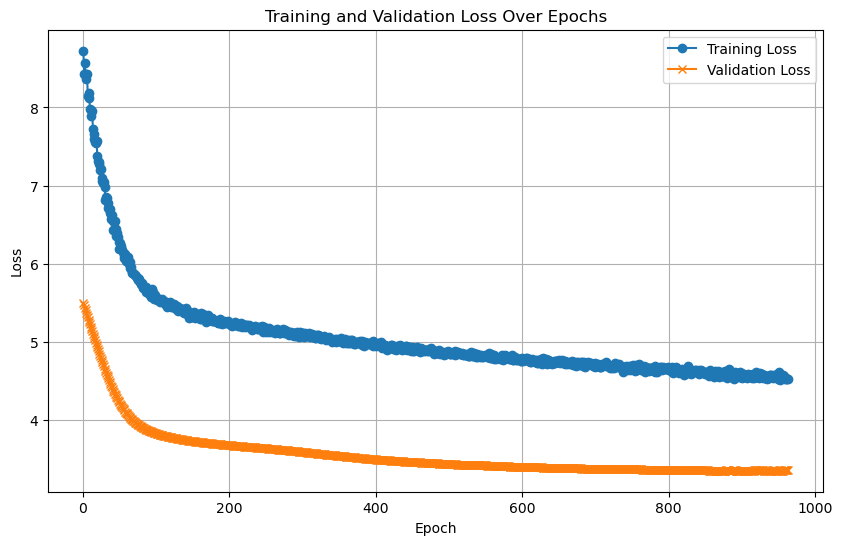

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 7.1978
Test Batch [20/20], Loss: 5.0863

Test Loss: 5.4556


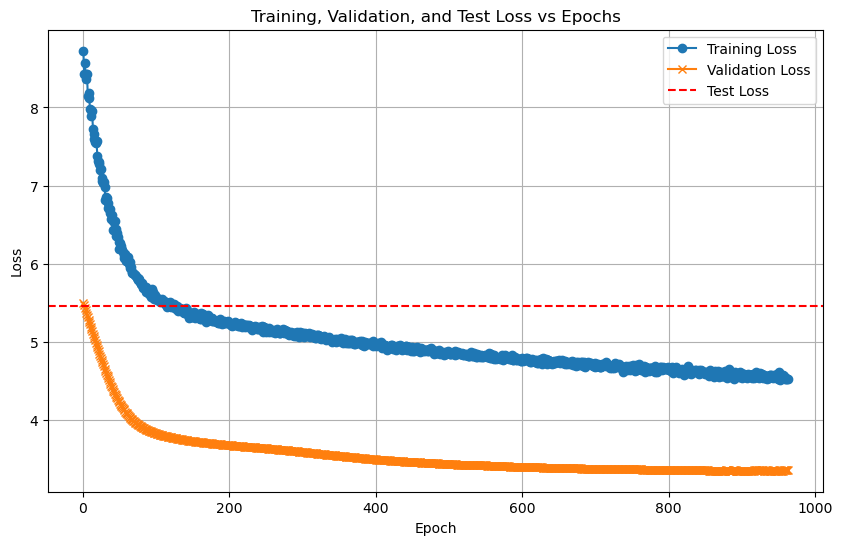

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 61.54%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.50      0.20      0.29         5
           2       0.67      0.40      0.50         5
           3       0.50      0.20      0.29         5
           4       0.75      0.60      0.67         5
           5       0.67      0.40      0.50         5
           6       0.43      0.60      0.50         5
           7       0.43      0.60      0.50         5
           8       0.56      1.00      0.71         5
           9       0.50      0.40      0.44         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       0.80      0.80      0.80         5

    accuracy         

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5687  |  Val Loss: 2.5470
Validation loss improved from inf to 2.5470.
[Epoch 2/1000] Train Loss: 2.5495  |  Val Loss: 2.5336
Validation loss improved from 2.5470 to 2.5336.
[Epoch 3/1000] Train Loss: 2.5356  |  Val Loss: 2.5231
Validation loss improved from 2.5336 to 2.5231.
[Epoch 4/1000] Train Loss: 2.5262  |  Val Loss: 2.5158
Validation loss improved from 2.5231 to 2.5158.
[Epoch 5/1000] Train Loss: 2.5189  |  Val Loss: 2.5092
Validation loss improved from 2.5158 to 2.5092.
[Epoch 6/1000] Train Loss: 2.5108  |  Val Loss: 2.5014
Validation loss improved from 2.5092 to 2.5014.
[Epoch 7/1000] Train Loss: 2.5034  |  Val Loss: 2.4941
Validation loss improved from 2.5014 to 2.4941.
[Epoch 8/1000] Train Loss: 2.4924  |  Val Loss: 2.4884
Validation loss improved from 2.4941 to 2.4884.
[Epoch 9/1000] Train Loss: 2.4837  |  Val Loss: 2.4834
Validation loss improved from 2.4884 to 2.4834.


[Epoch 10/1000] Train Loss: 2.4769  |  Val Loss: 2.4800
Validation loss improved from 2.4834 to 2.4800.
[Epoch 11/1000] Train Loss: 2.4703  |  Val Loss: 2.4778
Validation loss improved from 2.4800 to 2.4778.
[Epoch 12/1000] Train Loss: 2.4654  |  Val Loss: 2.4768
Validation loss improved from 2.4778 to 2.4768.
[Epoch 13/1000] Train Loss: 2.4622  |  Val Loss: 2.4759
Validation loss improved from 2.4768 to 2.4759.
[Epoch 14/1000] Train Loss: 2.4574  |  Val Loss: 2.4739
Validation loss improved from 2.4759 to 2.4739.
[Epoch 15/1000] Train Loss: 2.4541  |  Val Loss: 2.4706
Validation loss improved from 2.4739 to 2.4706.
[Epoch 16/1000] Train Loss: 2.4488  |  Val Loss: 2.4674
Validation loss improved from 2.4706 to 2.4674.
[Epoch 17/1000] Train Loss: 2.4445  |  Val Loss: 2.4641
Validation loss improved from 2.4674 to 2.4641.
[Epoch 18/1000] Train Loss: 2.4391  |  Val Loss: 2.4614
Validation loss improved from 2.4641 to 2.4614.
[Epoch 19/1000] Train Loss: 2.4352  |  Val Loss: 2.4589
Validati

[Epoch 20/1000] Train Loss: 2.4310  |  Val Loss: 2.4569
Validation loss improved from 2.4589 to 2.4569.
[Epoch 21/1000] Train Loss: 2.4286  |  Val Loss: 2.4561
Validation loss improved from 2.4569 to 2.4561.
[Epoch 22/1000] Train Loss: 2.4253  |  Val Loss: 2.4539
Validation loss improved from 2.4561 to 2.4539.
[Epoch 23/1000] Train Loss: 2.4209  |  Val Loss: 2.4506
Validation loss improved from 2.4539 to 2.4506.
[Epoch 24/1000] Train Loss: 2.4159  |  Val Loss: 2.4465
Validation loss improved from 2.4506 to 2.4465.
[Epoch 25/1000] Train Loss: 2.4116  |  Val Loss: 2.4433
Validation loss improved from 2.4465 to 2.4433.
[Epoch 26/1000] Train Loss: 2.4075  |  Val Loss: 2.4397
Validation loss improved from 2.4433 to 2.4397.
[Epoch 27/1000] Train Loss: 2.4042  |  Val Loss: 2.4378
Validation loss improved from 2.4397 to 2.4378.
[Epoch 28/1000] Train Loss: 2.4005  |  Val Loss: 2.4359
Validation loss improved from 2.4378 to 2.4359.
[Epoch 29/1000] Train Loss: 2.3975  |  Val Loss: 2.4337
Validati

[Epoch 30/1000] Train Loss: 2.3939  |  Val Loss: 2.4309
Validation loss improved from 2.4337 to 2.4309.
[Epoch 31/1000] Train Loss: 2.3906  |  Val Loss: 2.4291
Validation loss improved from 2.4309 to 2.4291.
[Epoch 32/1000] Train Loss: 2.3870  |  Val Loss: 2.4283
Validation loss improved from 2.4291 to 2.4283.
[Epoch 33/1000] Train Loss: 2.3855  |  Val Loss: 2.4260
Validation loss improved from 2.4283 to 2.4260.
[Epoch 34/1000] Train Loss: 2.3826  |  Val Loss: 2.4234
Validation loss improved from 2.4260 to 2.4234.
[Epoch 35/1000] Train Loss: 2.3791  |  Val Loss: 2.4209
Validation loss improved from 2.4234 to 2.4209.
[Epoch 36/1000] Train Loss: 2.3754  |  Val Loss: 2.4187
Validation loss improved from 2.4209 to 2.4187.
[Epoch 37/1000] Train Loss: 2.3725  |  Val Loss: 2.4167
Validation loss improved from 2.4187 to 2.4167.
[Epoch 38/1000] Train Loss: 2.3701  |  Val Loss: 2.4150
Validation loss improved from 2.4167 to 2.4150.
[Epoch 39/1000] Train Loss: 2.3676  |  Val Loss: 2.4132
Validati

[Epoch 42/1000] Train Loss: 2.3583  |  Val Loss: 2.4062
Validation loss improved from 2.4087 to 2.4062.
[Epoch 43/1000] Train Loss: 2.3550  |  Val Loss: 2.4040
Validation loss improved from 2.4062 to 2.4040.
[Epoch 44/1000] Train Loss: 2.3522  |  Val Loss: 2.4020
Validation loss improved from 2.4040 to 2.4020.
[Epoch 45/1000] Train Loss: 2.3496  |  Val Loss: 2.3999
Validation loss improved from 2.4020 to 2.3999.
[Epoch 46/1000] Train Loss: 2.3469  |  Val Loss: 2.3977
Validation loss improved from 2.3999 to 2.3977.
[Epoch 47/1000] Train Loss: 2.3437  |  Val Loss: 2.3954
Validation loss improved from 2.3977 to 2.3954.
[Epoch 48/1000] Train Loss: 2.3409  |  Val Loss: 2.3930
Validation loss improved from 2.3954 to 2.3930.


[Epoch 49/1000] Train Loss: 2.3371  |  Val Loss: 2.3909
Validation loss improved from 2.3930 to 2.3909.
[Epoch 50/1000] Train Loss: 2.3343  |  Val Loss: 2.3896
Validation loss improved from 2.3909 to 2.3896.
[Epoch 51/1000] Train Loss: 2.3360  |  Val Loss: 2.3901
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 52/1000] Train Loss: 2.3354  |  Val Loss: 2.3891
Validation loss improved from 2.3896 to 2.3891.
[Epoch 53/1000] Train Loss: 2.3316  |  Val Loss: 2.3859
Validation loss improved from 2.3891 to 2.3859.
[Epoch 54/1000] Train Loss: 2.3274  |  Val Loss: 2.3846
Validation loss improved from 2.3859 to 2.3846.
[Epoch 55/1000] Train Loss: 2.3239  |  Val Loss: 2.3816
Validation loss improved from 2.3846 to 2.3816.
[Epoch 56/1000] Train Loss: 2.3189  |  Val Loss: 2.3786
Validation loss improved from 2.3816 to 2.3786.
[Epoch 57/1000] Train Loss: 2.3143  |  Val Loss: 2.3746
Validation loss improved from 2.3786 to 2.3746.
[Epoch 58/1000] Train Loss: 2.3102  |  Val Loss: 2.3721
Va

[Epoch 64/1000] Train Loss: 2.2918  |  Val Loss: 2.3624
Validation loss improved from 2.3638 to 2.3624.
[Epoch 65/1000] Train Loss: 2.2887  |  Val Loss: 2.3601
Validation loss improved from 2.3624 to 2.3601.
[Epoch 66/1000] Train Loss: 2.2857  |  Val Loss: 2.3571
Validation loss improved from 2.3601 to 2.3571.
[Epoch 67/1000] Train Loss: 2.2829  |  Val Loss: 2.3543
Validation loss improved from 2.3571 to 2.3543.
[Epoch 68/1000] Train Loss: 2.2801  |  Val Loss: 2.3527
Validation loss improved from 2.3543 to 2.3527.
[Epoch 69/1000] Train Loss: 2.2774  |  Val Loss: 2.3508
Validation loss improved from 2.3527 to 2.3508.
[Epoch 70/1000] Train Loss: 2.2734  |  Val Loss: 2.3480
Validation loss improved from 2.3508 to 2.3480.


[Epoch 71/1000] Train Loss: 2.2686  |  Val Loss: 2.3455
Validation loss improved from 2.3480 to 2.3455.
[Epoch 72/1000] Train Loss: 2.2649  |  Val Loss: 2.3444
Validation loss improved from 2.3455 to 2.3444.
[Epoch 73/1000] Train Loss: 2.2617  |  Val Loss: 2.3443
Validation loss improved from 2.3444 to 2.3443.
[Epoch 74/1000] Train Loss: 2.2595  |  Val Loss: 2.3419
Validation loss improved from 2.3443 to 2.3419.
[Epoch 75/1000] Train Loss: 2.2548  |  Val Loss: 2.3388
Validation loss improved from 2.3419 to 2.3388.
[Epoch 76/1000] Train Loss: 2.2508  |  Val Loss: 2.3357
Validation loss improved from 2.3388 to 2.3357.
[Epoch 77/1000] Train Loss: 2.2468  |  Val Loss: 2.3330
Validation loss improved from 2.3357 to 2.3330.
[Epoch 78/1000] Train Loss: 2.2431  |  Val Loss: 2.3305
Validation loss improved from 2.3330 to 2.3305.
[Epoch 79/1000] Train Loss: 2.2393  |  Val Loss: 2.3277
Validation loss improved from 2.3305 to 2.3277.
[Epoch 80/1000] Train Loss: 2.2352  |  Val Loss: 2.3250
Validati

[Epoch 87/1000] Train Loss: 2.2048  |  Val Loss: 2.3060
Validation loss improved from 2.3076 to 2.3060.
[Epoch 88/1000] Train Loss: 2.2015  |  Val Loss: 2.3067
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 89/1000] Train Loss: 2.1987  |  Val Loss: 2.3057
Validation loss improved from 2.3060 to 2.3057.
[Epoch 90/1000] Train Loss: 2.1942  |  Val Loss: 2.3029
Validation loss improved from 2.3057 to 2.3029.
[Epoch 91/1000] Train Loss: 2.1884  |  Val Loss: 2.2991
Validation loss improved from 2.3029 to 2.2991.


[Epoch 92/1000] Train Loss: 2.1832  |  Val Loss: 2.2950
Validation loss improved from 2.2991 to 2.2950.
[Epoch 93/1000] Train Loss: 2.1780  |  Val Loss: 2.2928
Validation loss improved from 2.2950 to 2.2928.
[Epoch 94/1000] Train Loss: 2.1738  |  Val Loss: 2.2898
Validation loss improved from 2.2928 to 2.2898.
[Epoch 95/1000] Train Loss: 2.1684  |  Val Loss: 2.2859
Validation loss improved from 2.2898 to 2.2859.
[Epoch 96/1000] Train Loss: 2.1642  |  Val Loss: 2.2807
Validation loss improved from 2.2859 to 2.2807.
[Epoch 97/1000] Train Loss: 2.1572  |  Val Loss: 2.2769
Validation loss improved from 2.2807 to 2.2769.
[Epoch 98/1000] Train Loss: 2.1519  |  Val Loss: 2.2739
Validation loss improved from 2.2769 to 2.2739.
[Epoch 99/1000] Train Loss: 2.1460  |  Val Loss: 2.2710
Validation loss improved from 2.2739 to 2.2710.
[Epoch 100/1000] Train Loss: 2.1394  |  Val Loss: 2.2694
Validation loss improved from 2.2710 to 2.2694.
[Epoch 101/1000] Train Loss: 2.1335  |  Val Loss: 2.2678
Valida

[Epoch 105/1000] Train Loss: 2.1098  |  Val Loss: 2.2605
Validation loss improved from 2.2638 to 2.2605.
[Epoch 106/1000] Train Loss: 2.1035  |  Val Loss: 2.2575
Validation loss improved from 2.2605 to 2.2575.
[Epoch 107/1000] Train Loss: 2.0973  |  Val Loss: 2.2545
Validation loss improved from 2.2575 to 2.2545.
[Epoch 108/1000] Train Loss: 2.0920  |  Val Loss: 2.2523
Validation loss improved from 2.2545 to 2.2523.
[Epoch 109/1000] Train Loss: 2.0866  |  Val Loss: 2.2501
Validation loss improved from 2.2523 to 2.2501.


[Epoch 110/1000] Train Loss: 2.0792  |  Val Loss: 2.2494
Validation loss improved from 2.2501 to 2.2494.
[Epoch 111/1000] Train Loss: 2.0735  |  Val Loss: 2.2644
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 2.0805  |  Val Loss: 2.2650
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 2.0730  |  Val Loss: 2.2467
Validation loss improved from 2.2494 to 2.2467.
[Epoch 114/1000] Train Loss: 2.0583  |  Val Loss: 2.2372
Validation loss improved from 2.2467 to 2.2372.
[Epoch 115/1000] Train Loss: 2.0527  |  Val Loss: 2.2334
Validation loss improved from 2.2372 to 2.2334.
[Epoch 116/1000] Train Loss: 2.0487  |  Val Loss: 2.2322
Validation loss improved from 2.2334 to 2.2322.
[Epoch 117/1000] Train Loss: 2.0409  |  Val Loss: 2.2328
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118/1000] Train Loss: 2.0340  |  Val Loss: 2.2349
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 119/1000] Train Loss: 2.

[Epoch 124/1000] Train Loss: 2.0092  |  Val Loss: 2.2319
Validation loss improved from 2.2322 to 2.2319.
[Epoch 125/1000] Train Loss: 2.0011  |  Val Loss: 2.2242
Validation loss improved from 2.2319 to 2.2242.
[Epoch 126/1000] Train Loss: 1.9924  |  Val Loss: 2.2231
Validation loss improved from 2.2242 to 2.2231.
[Epoch 127/1000] Train Loss: 1.9907  |  Val Loss: 2.2243
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 1.9872  |  Val Loss: 2.2230
Validation loss improved from 2.2231 to 2.2230.


[Epoch 129/1000] Train Loss: 1.9814  |  Val Loss: 2.2203
Validation loss improved from 2.2230 to 2.2203.
[Epoch 130/1000] Train Loss: 1.9739  |  Val Loss: 2.2199
Validation loss improved from 2.2203 to 2.2199.
[Epoch 131/1000] Train Loss: 1.9685  |  Val Loss: 2.2241
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 1.9632  |  Val Loss: 2.2269
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 133/1000] Train Loss: 1.9581  |  Val Loss: 2.2312
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 134/1000] Train Loss: 1.9545  |  Val Loss: 2.2306
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 135/1000] Train Loss: 1.9519  |  Val Loss: 2.2290
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 136/1000] Train Loss: 1.9488  |  Val Loss: 2.2229
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 137/1000] Train Loss: 1.9438  |  Val Loss: 2.2140
Validation loss improved from 2.2199 to 2.2140.
[Epoch 138/1000] Tr

[Epoch 141/1000] Train Loss: 1.9195  |  Val Loss: 2.1924
Validation loss improved from 2.1955 to 2.1924.
[Epoch 142/1000] Train Loss: 1.9154  |  Val Loss: 2.1926
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 143/1000] Train Loss: 1.9143  |  Val Loss: 2.2053
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 144/1000] Train Loss: 1.9169  |  Val Loss: 2.2124
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 145/1000] Train Loss: 1.9190  |  Val Loss: 2.2180
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 146/1000] Train Loss: 1.9164  |  Val Loss: 2.2097
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 147/1000] Train Loss: 1.9025  |  Val Loss: 2.1906
Validation loss improved from 2.1924 to 2.1906.
[Epoch 148/1000] Train Loss: 1.8900  |  Val Loss: 2.1788
Validation loss improved from 2.1906 to 2.1788.


[Epoch 149/1000] Train Loss: 1.8846  |  Val Loss: 2.1724
Validation loss improved from 2.1788 to 2.1724.
[Epoch 150/1000] Train Loss: 1.8819  |  Val Loss: 2.1711
Validation loss improved from 2.1724 to 2.1711.
[Epoch 151/1000] Train Loss: 1.8777  |  Val Loss: 2.1707
Validation loss improved from 2.1711 to 2.1707.
[Epoch 152/1000] Train Loss: 1.8736  |  Val Loss: 2.1658
Validation loss improved from 2.1707 to 2.1658.
[Epoch 153/1000] Train Loss: 1.8694  |  Val Loss: 2.1636
Validation loss improved from 2.1658 to 2.1636.
[Epoch 154/1000] Train Loss: 1.8652  |  Val Loss: 2.1610
Validation loss improved from 2.1636 to 2.1610.
[Epoch 155/1000] Train Loss: 1.8598  |  Val Loss: 2.1625
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 1.8544  |  Val Loss: 2.1658
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 1.8491  |  Val Loss: 2.1683
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/1000] Train Loss: 1.8447  

[Epoch 163/1000] Train Loss: 1.8270  |  Val Loss: 2.1839
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 164/1000] Train Loss: 1.8247  |  Val Loss: 2.1863
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 165/1000] Train Loss: 1.8199  |  Val Loss: 2.1797
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 166/1000] Train Loss: 1.8154  |  Val Loss: 2.1718
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 167/1000] Train Loss: 1.8103  |  Val Loss: 2.1639
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 168/1000] Train Loss: 1.8074  |  Val Loss: 2.1610
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 169/1000] Train Loss: 1.8033  |  Val Loss: 2.1601
Validation loss improved from 2.1610 to 2.1601.


[Epoch 170/1000] Train Loss: 1.7966  |  Val Loss: 2.1629
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 171/1000] Train Loss: 1.7930  |  Val Loss: 2.1659
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 172/1000] Train Loss: 1.7885  |  Val Loss: 2.1653
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 173/1000] Train Loss: 1.7839  |  Val Loss: 2.1599
Validation loss improved from 2.1601 to 2.1599.
[Epoch 174/1000] Train Loss: 1.7785  |  Val Loss: 2.1551
Validation loss improved from 2.1599 to 2.1551.
[Epoch 175/1000] Train Loss: 1.7749  |  Val Loss: 2.1513
Validation loss improved from 2.1551 to 2.1513.
[Epoch 176/1000] Train Loss: 1.7722  |  Val Loss: 2.1523
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 1.7654  |  Val Loss: 2.1636
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 1.7705  |  Val Loss: 2.1698
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Tr

[Epoch 183/1000] Train Loss: 1.7461  |  Val Loss: 2.1365
Validation loss improved from 2.1419 to 2.1365.
[Epoch 184/1000] Train Loss: 1.7453  |  Val Loss: 2.1341
Validation loss improved from 2.1365 to 2.1341.
[Epoch 185/1000] Train Loss: 1.7428  |  Val Loss: 2.1333
Validation loss improved from 2.1341 to 2.1333.
[Epoch 186/1000] Train Loss: 1.7388  |  Val Loss: 2.1326
Validation loss improved from 2.1333 to 2.1326.
[Epoch 187/1000] Train Loss: 1.7340  |  Val Loss: 2.1345
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 1.7283  |  Val Loss: 2.1380
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 189/1000] Train Loss: 1.7228  |  Val Loss: 2.1406
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 190/1000] Train Loss: 1.7176  |  Val Loss: 2.1425
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 191/1000] Train Loss: 1.7174  |  Val Loss: 2.1494
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 192/1000] Train Loss: 1.7156  |  Val Loss: 2.1468
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 193/1000] Train Loss: 1.7133  |  Val Loss: 2.1412
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 194/1000] Train Loss: 1.7083  |  Val Loss: 2.1359
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 195/1000] Train Loss: 1.7034  |  Val Loss: 2.1334
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 196/1000] Train Loss: 1.6990  |  Val Loss: 2.1278
Validation loss improved from 2.1326 to 2.1278.
[Epoch 197/1000] Train Loss: 1.6944  |  Val Loss: 2.1236
Validation loss improved from 2.1278 to 2.1236.
[Epoch 198/1000] Train Loss: 1.6898  |  Val Loss: 2.1207
Validation loss improved from 2.1236 to 2.1207.
[Epoch 199/1000] Train Loss: 1.6867  |  Val Loss: 2.1185
Validation loss improved from 2.1207 to 2.1185.
[Epoch 200/1000] Train Loss: 1.6831  |  Val Loss: 2.1190
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 201/1000] Train Loss: 1.6817  |  Val Loss: 2.1279
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 202/1000] Train Loss: 1.6798  |  Val Loss: 2.1325
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 203/1000] Train Loss: 1.6766  |  Val Loss: 2.1297
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 204/1000] Train Loss: 1.6713  |  Val Loss: 2.1268
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 205/1000] Train Loss: 1.6661  |  Val Loss: 2.1215
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 206/1000] Train Loss: 1.6598  |  Val Loss: 2.1165
Validation loss improved from 2.1185 to 2.1165.
[Epoch 207/1000] Train Loss: 1.6588  |  Val Loss: 2.1114
Validation loss improved from 2.1165 to 2.1114.
[Epoch 208/1000] Train Loss: 1.6544  |  Val Loss: 2.1101
Validation loss improved from 2.1114 to 2.1101.
[Epoch 209/1000] Train Loss: 1.6499  |  Val Loss: 2.1107
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 210/1000] Tr

[Epoch 212/1000] Train Loss: 1.6383  |  Val Loss: 2.1052
Validation loss improved from 2.1094 to 2.1052.
[Epoch 213/1000] Train Loss: 1.6348  |  Val Loss: 2.1022
Validation loss improved from 2.1052 to 2.1022.
[Epoch 214/1000] Train Loss: 1.6311  |  Val Loss: 2.0978
Validation loss improved from 2.1022 to 2.0978.
[Epoch 215/1000] Train Loss: 1.6275  |  Val Loss: 2.0956
Validation loss improved from 2.0978 to 2.0956.
[Epoch 216/1000] Train Loss: 1.6232  |  Val Loss: 2.1025
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 217/1000] Train Loss: 1.6268  |  Val Loss: 2.1033
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 218/1000] Train Loss: 1.6283  |  Val Loss: 2.0969
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 1.6226  |  Val Loss: 2.0903
Validation loss improved from 2.0956 to 2.0903.


[Epoch 220/1000] Train Loss: 1.6182  |  Val Loss: 2.0854
Validation loss improved from 2.0903 to 2.0854.
[Epoch 221/1000] Train Loss: 1.6110  |  Val Loss: 2.0844
Validation loss improved from 2.0854 to 2.0844.
[Epoch 222/1000] Train Loss: 1.6057  |  Val Loss: 2.0848
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 223/1000] Train Loss: 1.6022  |  Val Loss: 2.0958
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 224/1000] Train Loss: 1.6059  |  Val Loss: 2.1060
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 225/1000] Train Loss: 1.6047  |  Val Loss: 2.1022
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 226/1000] Train Loss: 1.5983  |  Val Loss: 2.0967
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 227/1000] Train Loss: 1.5921  |  Val Loss: 2.1019
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 228/1000] Train Loss: 1.5883  |  Val Loss: 2.0924
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 229/10

[Epoch 231/1000] Train Loss: 1.5816  |  Val Loss: 2.0742
Validation loss improved from 2.0788 to 2.0742.
[Epoch 232/1000] Train Loss: 1.5761  |  Val Loss: 2.0702
Validation loss improved from 2.0742 to 2.0702.
[Epoch 233/1000] Train Loss: 1.5684  |  Val Loss: 2.0762
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 1.5722  |  Val Loss: 2.0799
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 1.5721  |  Val Loss: 2.0770
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 236/1000] Train Loss: 1.5668  |  Val Loss: 2.0684
Validation loss improved from 2.0702 to 2.0684.
[Epoch 237/1000] Train Loss: 1.5593  |  Val Loss: 2.0595
Validation loss improved from 2.0684 to 2.0595.
[Epoch 238/1000] Train Loss: 1.5543  |  Val Loss: 2.0631
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 239/1000] Train Loss: 1.5565  |  Val Loss: 2.0644
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 240/1000] Train Loss: 1.5511  |  Val Loss: 2.0554
Validation loss improved from 2.0595 to 2.0554.
[Epoch 241/1000] Train Loss: 1.5447  |  Val Loss: 2.0588
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 242/1000] Train Loss: 1.5426  |  Val Loss: 2.0585
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 243/1000] Train Loss: 1.5399  |  Val Loss: 2.0552
Validation loss improved from 2.0554 to 2.0552.
[Epoch 244/1000] Train Loss: 1.5354  |  Val Loss: 2.0514
Validation loss improved from 2.0552 to 2.0514.
[Epoch 245/1000] Train Loss: 1.5313  |  Val Loss: 2.0477
Validation loss improved from 2.0514 to 2.0477.
[Epoch 246/1000] Train Loss: 1.5272  |  Val Loss: 2.0459
Validation loss improved from 2.0477 to 2.0459.
[Epoch 247/1000] Train Loss: 1.5235  |  Val Loss: 2.0452
Validation loss improved from 2.0459 to 2.0452.
[Epoch 248/1000] Train Loss: 1.5201  

[Epoch 250/1000] Train Loss: 1.5134  |  Val Loss: 2.0456
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 251/1000] Train Loss: 1.5123  |  Val Loss: 2.0461
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 252/1000] Train Loss: 1.5096  |  Val Loss: 2.0430
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 253/1000] Train Loss: 1.5055  |  Val Loss: 2.0410
Validation loss improved from 2.0427 to 2.0410.
[Epoch 254/1000] Train Loss: 1.5016  |  Val Loss: 2.0397
Validation loss improved from 2.0410 to 2.0397.
[Epoch 255/1000] Train Loss: 1.4974  |  Val Loss: 2.0362
Validation loss improved from 2.0397 to 2.0362.
[Epoch 256/1000] Train Loss: 1.4944  |  Val Loss: 2.0265
Validation loss improved from 2.0362 to 2.0265.


[Epoch 257/1000] Train Loss: 1.4929  |  Val Loss: 2.0220
Validation loss improved from 2.0265 to 2.0220.
[Epoch 258/1000] Train Loss: 1.4908  |  Val Loss: 2.0191
Validation loss improved from 2.0220 to 2.0191.
[Epoch 259/1000] Train Loss: 1.4871  |  Val Loss: 2.0202
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 1.4844  |  Val Loss: 2.0237
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 1.4822  |  Val Loss: 2.0243
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 262/1000] Train Loss: 1.4809  |  Val Loss: 2.0219
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 263/1000] Train Loss: 1.4776  |  Val Loss: 2.0211
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 264/1000] Train Loss: 1.4734  |  Val Loss: 2.0272
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 265/1000] Train Loss: 1.4733  |  Val Loss: 2.0269
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 266/10

[Epoch 272/1000] Train Loss: 1.4571  |  Val Loss: 1.9929
Validation loss improved from 1.9934 to 1.9929.
[Epoch 273/1000] Train Loss: 1.4470  |  Val Loss: 1.9955
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 274/1000] Train Loss: 1.4410  |  Val Loss: 1.9995
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 275/1000] Train Loss: 1.4378  |  Val Loss: 2.0033
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 276/1000] Train Loss: 1.4357  |  Val Loss: 2.0047
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 277/1000] Train Loss: 1.4315  |  Val Loss: 2.0042
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 278/1000] Train Loss: 1.4297  |  Val Loss: 2.0020
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 279/1000] Train Loss: 1.4273  |  Val Loss: 1.9996
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 280/1000] Train Loss: 1.4239  |  Val Loss: 1.9980
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 281/1000] Train Loss: 1.4204  |  Val Loss: 1.9947
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 282/1000] Train Loss: 1.4171  |  Val Loss: 1.9868
Validation loss improved from 1.9929 to 1.9868.
[Epoch 283/1000] Train Loss: 1.4184  |  Val Loss: 1.9998
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 284/1000] Train Loss: 1.4215  |  Val Loss: 2.0163
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 285/1000] Train Loss: 1.4324  |  Val Loss: 2.0267
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 286/1000] Train Loss: 1.4357  |  Val Loss: 2.0194
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 290/1000] Train Loss: 1.3954  |  Val Loss: 1.9849
Validation loss improved from 1.9858 to 1.9849.
[Epoch 291/1000] Train Loss: 1.4016  |  Val Loss: 1.9841
Validation loss improved from 1.9849 to 1.9841.
[Epoch 292/1000] Train Loss: 1.3997  |  Val Loss: 1.9780
Validation loss improved from 1.9841 to 1.9780.
[Epoch 293/1000] Train Loss: 1.3943  |  Val Loss: 1.9727
Validation loss improved from 1.9780 to 1.9727.
[Epoch 294/1000] Train Loss: 1.3886  |  Val Loss: 1.9718
Validation loss improved from 1.9727 to 1.9718.
[Epoch 295/1000] Train Loss: 1.3831  |  Val Loss: 1.9729
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 296/1000] Train Loss: 1.3807  |  Val Loss: 1.9761
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 297/1000] Train Loss: 1.3765  |  Val Loss: 1.9772
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 298/1000] Train Loss: 1.3731  |  Val Loss: 1.9765
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 299/1000] Train Loss: 1.3694  |  Val Loss: 1.9742
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 300/1000] Train Loss: 1.3669  |  Val Loss: 1.9738
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 301/1000] Train Loss: 1.3641  |  Val Loss: 1.9738
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 302/1000] Train Loss: 1.3629  |  Val Loss: 1.9834
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 303/1000] Train Loss: 1.3643  |  Val Loss: 1.9857
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 304/1000] Train Loss: 1.3618  |  Val Loss: 1.9800
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 305/1000] Train Loss: 1.3555  |  Val Loss: 1.9744
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 311/1000] Train Loss: 1.3421  |  Val Loss: 1.9652
Validation loss improved from 1.9703 to 1.9652.
[Epoch 312/1000] Train Loss: 1.3380  |  Val Loss: 1.9615
Validation loss improved from 1.9652 to 1.9615.
[Epoch 313/1000] Train Loss: 1.3341  |  Val Loss: 1.9603
Validation loss improved from 1.9615 to 1.9603.
[Epoch 314/1000] Train Loss: 1.3312  |  Val Loss: 1.9627
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 315/1000] Train Loss: 1.3280  |  Val Loss: 1.9647
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 316/1000] Train Loss: 1.3250  |  Val Loss: 1.9638
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 317/1000] Train Loss: 1.3227  |  Val Loss: 1.9579
Validation loss improved from 1.9603 to 1.9579.
[Epoch 318/1000] Train Loss: 1.3217  |  Val Loss: 1.9563
Validation loss improved from 1.9579 to 1.9563.
[Epoch 319/1000] Train Loss: 1.3200  |  Val Loss: 1.9705
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 320/1000] Train Loss: 1.3235  |  Val Loss: 1.9757
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 321/1000] Train Loss: 1.3247  |  Val Loss: 1.9705
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 322/1000] Train Loss: 1.3188  |  Val Loss: 1.9613
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 323/1000] Train Loss: 1.3122  |  Val Loss: 1.9564
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 324/1000] Train Loss: 1.3072  |  Val Loss: 1.9570
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 325/1000] Train Loss: 1.3046  |  Val Loss: 1.9573
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 326/10

[Epoch 330/1000] Train Loss: 1.2929  |  Val Loss: 1.9649
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 331/1000] Train Loss: 1.2892  |  Val Loss: 1.9668
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 332/1000] Train Loss: 1.2857  |  Val Loss: 1.9675
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 333/1000] Train Loss: 1.2833  |  Val Loss: 1.9675
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 334/1000] Train Loss: 1.2821  |  Val Loss: 1.9784
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 335/1000] Train Loss: 1.2850  |  Val Loss: 1.9832
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 336/1000] Train Loss: 1.2836  |  Val Loss: 1.9800
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 337/1000] Train Loss: 1.2857  |  Val Loss: 1.9804
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 338/1000] Train Loss: 1.2854  |  Val Loss: 1.9750
!! Validation loss did NOT improve !! Patience:

[Epoch 339/1000] Train Loss: 1.2869  |  Val Loss: 1.9634
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 340/1000] Train Loss: 1.2831  |  Val Loss: 1.9525
Validation loss improved from 1.9563 to 1.9525.
[Epoch 341/1000] Train Loss: 1.2787  |  Val Loss: 1.9442
Validation loss improved from 1.9525 to 1.9442.
[Epoch 342/1000] Train Loss: 1.2713  |  Val Loss: 1.9393
Validation loss improved from 1.9442 to 1.9393.
[Epoch 343/1000] Train Loss: 1.2655  |  Val Loss: 1.9415
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 344/1000] Train Loss: 1.2610  |  Val Loss: 1.9475
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 345/1000] Train Loss: 1.2592  |  Val Loss: 1.9501
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 346/1000] Train Loss: 1.2574  |  Val Loss: 1.9491
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 347/1000] Train Loss: 1.2551  |  Val Loss: 1.9478
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 348/1000] T

[Epoch 349/1000] Train Loss: 1.2487  |  Val Loss: 1.9467
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 350/1000] Train Loss: 1.2468  |  Val Loss: 1.9507
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 351/1000] Train Loss: 1.2444  |  Val Loss: 1.9500
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 352/1000] Train Loss: 1.2431  |  Val Loss: 1.9490
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 353/1000] Train Loss: 1.2428  |  Val Loss: 1.9519
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 354/1000] Train Loss: 1.2408  |  Val Loss: 1.9537
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 355/1000] Train Loss: 1.2366  |  Val Loss: 1.9552
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 356/1000] Train Loss: 1.2343  |  Val Loss: 1.9550
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 357/1000] Train Loss: 1.2308  |  Val Loss: 1.9587
!! Validation loss did NOT improve !! Patience: 15

[Epoch 362/1000] Train Loss: 1.2323  |  Val Loss: 1.9556
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 363/1000] Train Loss: 1.2328  |  Val Loss: 1.9548
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 364/1000] Train Loss: 1.2283  |  Val Loss: 1.9497
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 365/1000] Train Loss: 1.2211  |  Val Loss: 1.9475
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 366/1000] Train Loss: 1.2145  |  Val Loss: 1.9446
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 367/1000] Train Loss: 1.2119  |  Val Loss: 1.9404
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 368/1000] Train Loss: 1.2118  |  Val Loss: 1.9419
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 369/1000] Train Loss: 1.2095  |  Val Loss: 1.9449
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 370/1000] Train Loss: 1.2080  |  Val Loss: 1.9499
!! Validation loss did NOT improve !! Patience:

[Epoch 371/1000] Train Loss: 1.2069  |  Val Loss: 1.9527
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 372/1000] Train Loss: 1.2040  |  Val Loss: 1.9530
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 373/1000] Train Loss: 1.2008  |  Val Loss: 1.9604
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 374/1000] Train Loss: 1.2051  |  Val Loss: 1.9708
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 375/1000] Train Loss: 1.2067  |  Val Loss: 1.9705
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 376/1000] Train Loss: 1.2035  |  Val Loss: 1.9652
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 377/1000] Train Loss: 1.1981  |  Val Loss: 1.9572
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 378/1000] Train Loss: 1.1927  |  Val Loss: 1.9517
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 379/1000] Train Loss: 1.1891  |  Val Loss: 1.9493
!! Validation loss did NOT improve !! Patience:

[Epoch 382/1000] Train Loss: 1.1831  |  Val Loss: 1.9451
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 383/1000] Train Loss: 1.1811  |  Val Loss: 1.9465
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 384/1000] Train Loss: 1.1781  |  Val Loss: 1.9489
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 385/1000] Train Loss: 1.1758  |  Val Loss: 1.9529
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 386/1000] Train Loss: 1.1748  |  Val Loss: 1.9569
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 387/1000] Train Loss: 1.1728  |  Val Loss: 1.9600
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 388/1000] Train Loss: 1.1708  |  Val Loss: 1.9676
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 389/1000] Train Loss: 1.1705  |  Val Loss: 1.9700
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 390/1000] Train Loss: 1.1692  |  Val Loss: 1.9693
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 391/1000] Train Loss: 1.1687  |  Val Loss: 1.9736
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 392/1000] Train Loss: 1.1673  |  Val Loss: 1.9669
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 393/1000] Train Loss: 1.1629  |  Val Loss: 1.9566
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 394/1000] Train Loss: 1.1590  |  Val Loss: 1.9513
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 395/1000] Train Loss: 1.1567  |  Val Loss: 1.9539
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 396/1000] Train Loss: 1.1540  |  Val Loss: 1.9586
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 397/1000] Train Loss: 1.1547  |  Val Loss: 1.9636
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 398/1000] Train Loss: 1.1524  |  Val Loss: 1.9616
!! Validation loss did NOT improve !! Patience:

[Epoch 401/1000] Train Loss: 1.1459  |  Val Loss: 1.9561
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 402/1000] Train Loss: 1.1444  |  Val Loss: 1.9551
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 403/1000] Train Loss: 1.1432  |  Val Loss: 1.9531
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 404/1000] Train Loss: 1.1415  |  Val Loss: 1.9510
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 405/1000] Train Loss: 1.1398  |  Val Loss: 1.9523
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 406/1000] Train Loss: 1.1375  |  Val Loss: 1.9513
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 407/1000] Train Loss: 1.1355  |  Val Loss: 1.9500
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 408/1000] Train Loss: 1.1340  |  Val Loss: 1.9466
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 409/1000] Train Loss: 1.1327  |  Val Loss: 1.9451
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 410/1000] Train Loss: 1.1308  |  Val Loss: 1.9434
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 411/1000] Train Loss: 1.1289  |  Val Loss: 1.9414
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 412/1000] Train Loss: 1.1275  |  Val Loss: 1.9423
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 413/1000] Train Loss: 1.1255  |  Val Loss: 1.9458
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 414/1000] Train Loss: 1.1234  |  Val Loss: 1.9503
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 415/1000] Train Loss: 1.1216  |  Val Loss: 1.9609
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 416/1000] Train Loss: 1.1253  |  Val Loss: 1.9914
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 417/1000] Train Loss: 1.1344  |  Val Loss: 2.0041
!! Validation loss did NOT improve !! Patience:

[Epoch 423/1000] Train Loss: 1.1112  |  Val Loss: 1.9558
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 424/1000] Train Loss: 1.1089  |  Val Loss: 1.9576
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 425/1000] Train Loss: 1.1088  |  Val Loss: 1.9572
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 426/1000] Train Loss: 1.1104  |  Val Loss: 1.9578
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 427/1000] Train Loss: 1.1115  |  Val Loss: 1.9589
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 428/1000] Train Loss: 1.1088  |  Val Loss: 1.9527
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 429/1000] Train Loss: 1.1040  |  Val Loss: 1.9422
!! Validation loss did NOT improve !! Patience: 87/100


[Epoch 430/1000] Train Loss: 1.0984  |  Val Loss: 1.9657
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 431/1000] Train Loss: 1.1121  |  Val Loss: 1.9806
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 432/1000] Train Loss: 1.1110  |  Val Loss: 1.9856
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 433/1000] Train Loss: 1.1033  |  Val Loss: 1.9838
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 434/1000] Train Loss: 1.1017  |  Val Loss: 1.9793
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 435/1000] Train Loss: 1.0972  |  Val Loss: 1.9724
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 436/1000] Train Loss: 1.0925  |  Val Loss: 1.9669
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 437/1000] Train Loss: 1.0895  |  Val Loss: 1.9643
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 438/1000] Train Loss: 1.0877  |  Val Loss: 1.9657
!! Validation loss did NOT improve !! Patience:

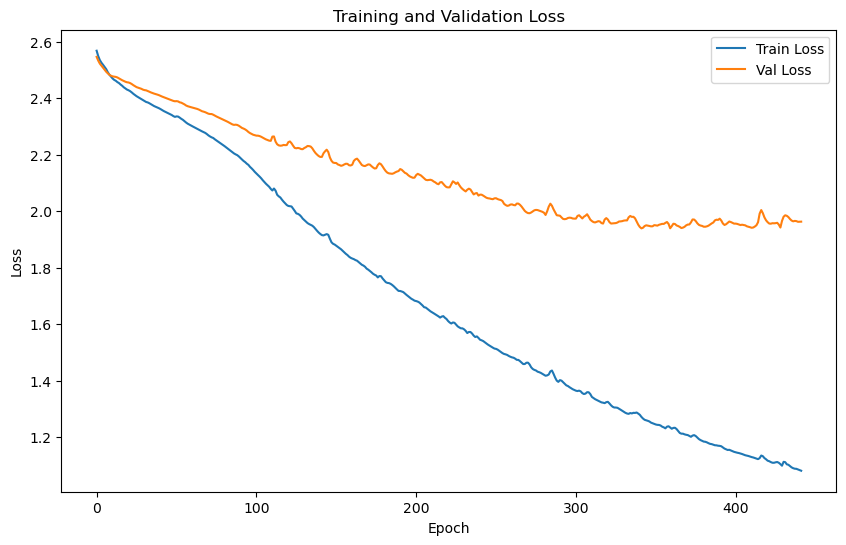

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.8335 | Test Accuracy: 53.50%


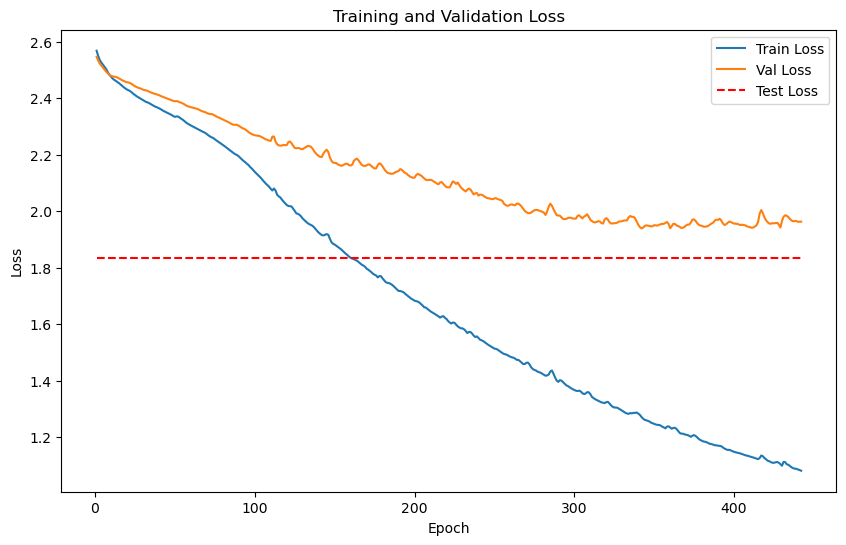

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5384
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6105
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5384, Avg Val Loss: 0.5552

Validation loss improved from inf to 0.5552. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5358
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.6092
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5358, Avg Val Loss: 0.5546

Validation loss improved from 0.5552 to 0.5546. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5346
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.6080
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5346, Avg Val Loss: 0.5540

Validation loss improved from 0.5546 to 0.5540. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5371
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6067
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5371, Avg Val Loss: 0.5533

Validation loss improved from 0.5540 to 0.5533. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5320
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6055
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5320, Avg Val Loss: 0.5527

Validation loss improved from 0.5533 to 0.5527. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.5358
LOG: Epoch [6/2000] - Validation


    Batch [1/2], Val Loss: 0.6040
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5358, Avg Val Loss: 0.5520

Validation loss improved from 0.5527 to 0.5520. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5308
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.6027


    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5308, Avg Val Loss: 0.5514

Validation loss improved from 0.5520 to 0.5514. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5300
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.6011
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5300, Avg Val Loss: 0.5506

Validation loss improved from 0.5514 to 0.5506. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5292
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5992
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5292, Avg Val Loss: 0.5496

Validation loss improved from 0.5506 to 0.5496. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5291
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5976
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5291, Avg Val Loss: 0.5488

Validation loss improved from 0.5496 to 0.5488. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.5286
LOG: Epoch [11/2000] - Validation


    Batch [1/2], Val Loss: 0.5953
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5286, Avg Val Loss: 0.5477

Validation loss improved from 0.5488 to 0.5477. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5273
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.5927
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5273, Avg Val Loss: 0.5463

Validation loss improved from 0.5477 to 0.5463. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5265
LOG: Epoch [13/2000] - Validation


    Batch [1/2], Val Loss: 0.5895
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5265, Avg Val Loss: 0.5448

Validation loss improved from 0.5463 to 0.5448. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5262
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5865


    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5262, Avg Val Loss: 0.5432

Validation loss improved from 0.5448 to 0.5432. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5256
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5836
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5256, Avg Val Loss: 0.5418

Validation loss improved from 0.5432 to 0.5418. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5214
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5805
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5214, Avg Val Loss: 0.5403

Validation loss improved from 0.5418 to 0.5403. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5230
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.5776
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5230, Avg Val Loss: 0.5388

Validation loss improved from 0.5403 to 0.5388. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5204
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5746
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5204, Avg Val Loss: 0.5373

Validation loss improved from 0.5388 to 0.5373. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5223
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5712
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5223, Avg Val Loss: 0.5356

Validation loss improved from 0.5373 to 0.5356. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5226
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5670
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5226, Avg Val Loss: 0.5335

Validation loss improved from 0.5356 to 0.5335. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.5212
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.5626
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5212, Avg Val Loss: 0.5313

Validation loss improved from 0.5335 to 0.5313. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5195
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5596
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5195, Avg Val Loss: 0.5298

Validation loss improved from 0.5313 to 0.5298. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.5181
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5563
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5181, Avg Val Loss: 0.5282

Validation loss improved from 0.5298 to 0.5282. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.5201
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5535
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5201, Avg Val Loss: 0.5267

Validation loss improved from 0.5282 to 0.5267. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5142
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.5508
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5254

Validation loss improved from 0.5267 to 0.5254. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5164
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5476
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5164, Avg Val Loss: 0.5238

Validation loss improved from 0.5254 to 0.5238. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.5165
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5445
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5165, Avg Val Loss: 0.5222

Validation loss improved from 0.5238 to 0.5222. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.5160
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5412
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5160, Avg Val Loss: 0.5206

Validation loss improved from 0.5222 to 0.5206. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5379
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.5189

Validation loss improved from 0.5206 to 0.5189. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5158
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5352
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5158, Avg Val Loss: 0.5176

Validation loss improved from 0.5189 to 0.5176. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.5124
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5328
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5124, Avg Val Loss: 0.5164

Validation loss improved from 0.5176 to 0.5164. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5104
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.5302
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5104, Avg Val Loss: 0.5151

Validation loss improved from 0.5164 to 0.5151. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5103
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5277
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5103, Avg Val Loss: 0.5138

Validation loss improved from 0.5151 to 0.5138. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.5118
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5118, Avg Val Loss: 0.5128

Validation loss improved from 0.5138 to 0.5128. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.5120
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.5236
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5120, Avg Val Loss: 0.5118

Validation loss improved from 0.5128 to 0.5118. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5128
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5128, Avg Val Loss: 0.5109

Validation loss improved from 0.5118 to 0.5109. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.5098
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5202
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5098, Avg Val Loss: 0.5101

Validation loss improved from 0.5109 to 0.5101. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.5096
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5184
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5096, Avg Val Loss: 0.5092

Validation loss improved from 0.5101 to 0.5092. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5097
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5086

Validation loss improved from 0.5092 to 0.5086. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5100
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5100, Avg Val Loss: 0.5081

Validation loss improved from 0.5086 to 0.5081. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5076

Validation loss improved from 0.5081 to 0.5076. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5086
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5086, Avg Val Loss: 0.5072

Validation loss improved from 0.5076 to 0.5072. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5090
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5090, Avg Val Loss: 0.5068

Validation loss improved from 0.5072 to 0.5068. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.5059
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5059, Avg Val Loss: 0.5064

Validation loss improved from 0.5068 to 0.5064. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.5063
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.5060

Validation loss improved from 0.5064 to 0.5060. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.5066
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5066, Avg Val Loss: 0.5056

Validation loss improved from 0.5060 to 0.5056. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5075
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5075, Avg Val Loss: 0.5053

Validation loss improved from 0.5056 to 0.5053. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5090
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5090, Avg Val Loss: 0.5049

Validation loss improved from 0.5053 to 0.5049. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5046

Validation loss improved from 0.5049 to 0.5046. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5055
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5055, Avg Val Loss: 0.5043

Validation loss improved from 0.5046 to 0.5043. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5046
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5046, Avg Val Loss: 0.5040

Validation loss improved from 0.5043 to 0.5040. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5037

Validation loss improved from 0.5040 to 0.5037. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.5036
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5036, Avg Val Loss: 0.5034

Validation loss improved from 0.5037 to 0.5034. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5031

Validation loss improved from 0.5034 to 0.5031. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5055
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5027

Validation loss improved from 0.5031 to 0.5027. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5024

Validation loss improved from 0.5027 to 0.5024. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.5023
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.5022

Validation loss improved from 0.5024 to 0.5022. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5019

Validation loss improved from 0.5022 to 0.5019. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5017

Validation loss improved from 0.5019 to 0.5017. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.5043
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5043, Avg Val Loss: 0.5015

Validation loss improved from 0.5017 to 0.5015. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5044
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5044, Avg Val Loss: 0.5012

Validation loss improved from 0.5015 to 0.5012. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.5036
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5021
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5036, Avg Val Loss: 0.5010

Validation loss improved from 0.5012 to 0.5010. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.5011
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.5008

Validation loss improved from 0.5010 to 0.5008. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5013
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5007

Validation loss improved from 0.5008 to 0.5007. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.5016
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5016, Avg Val Loss: 0.5005

Validation loss improved from 0.5007 to 0.5005. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [66/2000] - Validation


    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5003

Validation loss improved from 0.5005 to 0.5003. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.5003
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5002

Validation loss improved from 0.5003 to 0.5002. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5002
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5001

Validation loss improved from 0.5002 to 0.5001. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.5022
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5000
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5022, Avg Val Loss: 0.5000

Validation loss improved from 0.5001 to 0.5000. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.4999

Validation loss improved from 0.5000 to 0.4999. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.4999

Validation loss improved from 0.4999 to 0.4999. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.4998

Validation loss improved from 0.4999 to 0.4998. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.4998

Validation loss improved from 0.4998 to 0.4998. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.4997

Validation loss improved from 0.4998 to 0.4997. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.5019
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5019, Avg Val Loss: 0.4996

Validation loss improved from 0.4997 to 0.4996. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.5004
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.4996

Validation loss improved from 0.4996 to 0.4996. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4992


    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.4996

Validation loss improved from 0.4996 to 0.4996. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4995
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.4996

Validation loss improved from 0.4996 to 0.4996. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.4996

Validation loss improved from 0.4996 to 0.4996. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [82/2000] - Validation


    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4994


    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.4994

Validation loss improved from 0.4996 to 0.4994. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.4993

Validation loss improved from 0.4994 to 0.4993. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.4993

Validation loss improved from 0.4993 to 0.4993. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4983


    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.4992

Validation loss improved from 0.4993 to 0.4992. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.4991

Validation loss improved from 0.4992 to 0.4991. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4981
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.4990

Validation loss improved from 0.4991 to 0.4990. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [96/2000] - Validation


    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.4990

Validation loss improved from 0.4990 to 0.4990. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4995
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.4979
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.4990

Validation loss improved from 0.4990 to 0.4990. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [98/2000] - Validation


    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4989

Validation loss improved from 0.4990 to 0.4989. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.4988

Validation loss improved from 0.4989 to 0.4988. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.4987

Validation loss improved from 0.4988 to 0.4987. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.4986

Validation loss improved from 0.4987 to 0.4986. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.4985

Validation loss improved from 0.4986 to 0.4985. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4984

Validation loss improved from 0.4985 to 0.4984. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.4982

Validation loss improved from 0.4984 to 0.4982. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.4981

Validation loss improved from 0.4982 to 0.4981. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.4980

Validation loss improved from 0.4981 to 0.4980. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4979

Validation loss improved from 0.4980 to 0.4979. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4978

Validation loss improved from 0.4979 to 0.4978. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4977

Validation loss improved from 0.4978 to 0.4977. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4952


    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.4976

Validation loss improved from 0.4977 to 0.4976. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.4975

Validation loss improved from 0.4976 to 0.4975. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4974

Validation loss improved from 0.4975 to 0.4974. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.4974

Validation loss improved from 0.4974 to 0.4974. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.4973

Validation loss improved from 0.4974 to 0.4973. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4973

Validation loss improved from 0.4973 to 0.4973. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.4972

Validation loss improved from 0.4973 to 0.4972. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.4972

Validation loss improved from 0.4972 to 0.4972. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4972

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4971

Validation loss improved from 0.4972 to 0.4971. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4971

Validation loss improved from 0.4971 to 0.4971. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4971

Validation loss improved from 0.4971 to 0.4971. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4971

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4972

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4974

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4974

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.4974

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.4971

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4970

Validation loss improved from 0.4971 to 0.4970. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4969

Validation loss improved from 0.4970 to 0.4969. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4967

Validation loss improved from 0.4969 to 0.4967. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4965

Validation loss improved from 0.4967 to 0.4965. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4962

Validation loss improved from 0.4965 to 0.4962. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4959

Validation loss improved from 0.4962 to 0.4959. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4957

Validation loss improved from 0.4959 to 0.4957. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4955

Validation loss improved from 0.4957 to 0.4955. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [140/2000] - Validation


    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4953

Validation loss improved from 0.4955 to 0.4953. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4953 to 0.4951. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4950

Validation loss improved from 0.4951 to 0.4950. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4948

Validation loss improved from 0.4950 to 0.4948. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4948

Validation loss improved from 0.4948 to 0.4948. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4948

Validation loss improved from 0.4948 to 0.4948. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4949

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4948

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4948

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4948

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4949

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4949

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [167/2000] - Validation


    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4944

Validation loss improved from 0.4948 to 0.4944. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4938

Validation loss improved from 0.4944 to 0.4938. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [172/2000] - Validation


    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4932

Validation loss improved from 0.4938 to 0.4932. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4926

Validation loss improved from 0.4932 to 0.4926. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4921

Validation loss improved from 0.4926 to 0.4921. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4916

Validation loss improved from 0.4921 to 0.4916. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4911

Validation loss improved from 0.4916 to 0.4911. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4908

Validation loss improved from 0.4911 to 0.4908. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4905

Validation loss improved from 0.4908 to 0.4905. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4903

Validation loss improved from 0.4905 to 0.4903. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4901

Validation loss improved from 0.4903 to 0.4901. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4900

Validation loss improved from 0.4901 to 0.4900. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4899

Validation loss improved from 0.4900 to 0.4899. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4898

Validation loss improved from 0.4899 to 0.4898. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4897

Validation loss improved from 0.4898 to 0.4897. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4896

Validation loss improved from 0.4897 to 0.4896. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4895

Validation loss improved from 0.4896 to 0.4895. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4894

Validation loss improved from 0.4895 to 0.4894. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [188/2000] - Validation


    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4894

Validation loss improved from 0.4894 to 0.4894. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4893

Validation loss improved from 0.4894 to 0.4893. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4893

Validation loss improved from 0.4893 to 0.4893. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4893

Validation loss improved from 0.4893 to 0.4893. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4892

Validation loss improved from 0.4893 to 0.4892. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4892

Validation loss improved from 0.4892 to 0.4892. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4892

Validation loss improved from 0.4892 to 0.4892. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4892

Validation loss improved from 0.4892 to 0.4892. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4891

Validation loss improved from 0.4892 to 0.4891. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4891

Validation loss improved from 0.4891 to 0.4891. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4891

Validation loss improved from 0.4891 to 0.4891. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4890

Validation loss improved from 0.4891 to 0.4890. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4890

Validation loss improved from 0.4890 to 0.4890. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4890

Validation loss improved from 0.4890 to 0.4890. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4890

Validation loss improved from 0.4890 to 0.4890. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4890

Validation loss improved from 0.4890 to 0.4890. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4889

Validation loss improved from 0.4890 to 0.4889. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4889

Validation loss improved from 0.4889 to 0.4889. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4889

Validation loss improved from 0.4889 to 0.4889. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4889

Validation loss improved from 0.4889 to 0.4889. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4889

Validation loss improved from 0.4889 to 0.4889. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4889

Validation loss improved from 0.4889 to 0.4889. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4889

Validation loss improved from 0.4889 to 0.4889. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4888

Validation loss improved from 0.4889 to 0.4888. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4889

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4889

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4889

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4889

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4887

Validation loss improved from 0.4888 to 0.4887. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [241/2000] - Validation


    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [259/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4886

Validation loss improved from 0.4887 to 0.4886. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4886

Validation loss improved from 0.4886 to 0.4886. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [271/2000] - Validation


    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4886

Validation loss improved from 0.4886 to 0.4886. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4886

Validation loss improved from 0.4886 to 0.4886. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4886

Validation loss improved from 0.4886 to 0.4886. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4886

Validation loss improved from 0.4886 to 0.4886. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4886

Validation loss improved from 0.4886 to 0.4886. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4885

Validation loss improved from 0.4886 to 0.4885. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [277/2000] - Validation


    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [297/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [303/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4885

Validation loss improved from 0.4885 to 0.4885. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4884

Validation loss improved from 0.4885 to 0.4884. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [318/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [324/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [330/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [336/2000] - Validation


    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [340/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [343/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [344/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [349/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [358/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [364/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [367/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [368/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [375/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [379/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [393/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [403/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [407/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [411/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [414/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [415/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [425/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [434/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [437/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [443/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [447/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [450/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [452/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [453/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [454/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [458/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [461/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [465/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [469/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [473/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [477/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [480/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [484/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [487/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [488/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [492/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [496/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [499/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [503/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [504/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [505/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [513/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [514/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [522/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [526/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [527/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [528/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [529/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [530/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [534/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [538/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [541/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [542/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [543/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [547/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [550/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [553/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [557/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [561/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [565/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [568/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [569/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [570/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [571/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [574/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [577/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [580/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [583/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [590/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [591/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [594/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [595/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [598/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [601/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [601/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [602/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [603/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [604/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [604/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [605/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [606/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [607/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [607/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [608/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [609/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [610/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [610/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [611/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [611/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [612/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [613/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [614/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [615/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [615/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [616/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [617/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [618/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [619/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [619/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [620/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [620/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [621/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [621/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [622/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [623/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [624/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [624/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [625/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [626/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [627/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [627/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [628/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [629/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [630/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [631/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [631/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [632/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [632/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [633/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [634/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [635/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [635/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [636/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [636/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [637/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [638/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [639/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [639/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [640/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [641/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [642/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [643/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [643/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [644/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [645/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [646/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [646/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [647/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [647/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [648/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [649/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [650/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [650/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [651/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [652/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [653/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [654/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [655/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [655/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [656/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [657/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [658/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [658/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [659/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [660/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [661/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [661/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [662/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [662/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [663/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [664/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [665/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [666/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [666/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [667/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [668/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [669/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [669/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [670/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [671/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [672/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [672/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [673/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [674/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [675/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [675/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [676/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [677/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [678/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [678/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [679/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [680/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [681/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [681/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [682/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [683/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [684/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [684/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [685/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [685/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [686/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [687/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [688/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [689/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [689/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [690/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [691/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [692/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [693/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [694/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [695/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [695/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [696/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [696/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [697/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [698/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [699/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [700/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [700/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [701/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [701/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [702/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [703/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [704/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [704/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [705/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [706/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [707/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [708/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [708/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [709/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [710/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [711/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [711/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [712/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [712/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [713/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [713/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [714/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [714/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [715/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [716/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [717/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [717/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [718/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [719/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [720/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [720/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [721/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [722/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [723/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [723/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [724/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [725/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [726/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [727/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [727/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [728/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [728/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [729/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [730/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [731/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [731/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [732/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [732/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [733/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [734/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [735/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [735/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [736/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [737/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [738/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [738/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [739/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [739/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [740/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [740/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [741/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [742/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [743/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [743/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [744/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [745/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [746/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [746/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [747/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [748/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [749/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [750/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [750/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [751/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [751/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [752/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [753/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [754/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [755/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [755/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [756/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [757/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [758/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [758/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [759/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [760/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [761/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [761/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [762/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [763/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [764/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [764/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [765/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [766/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [767/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [767/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [768/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [769/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [770/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [770/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [771/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [771/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [772/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [773/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [774/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [774/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [775/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [776/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [777/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [778/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [779/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [779/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [780/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [781/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [782/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [783/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [783/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [784/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [785/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [786/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [786/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [787/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [788/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [789/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [789/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [790/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [791/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [792/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [793/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [793/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [794/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [795/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [796/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [797/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [797/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [798/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [799/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [800/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [800/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [801/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [802/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [803/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [803/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [804/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [804/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [805/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [806/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [807/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [807/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [808/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [808/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [809/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [810/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [811/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [811/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [812/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [813/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [814/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [815/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [815/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [816/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [816/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [817/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [818/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [819/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [819/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [820/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [821/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [822/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [822/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [823/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [823/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [824/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [825/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [826/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [826/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [827/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [827/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [828/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [829/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [830/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [830/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [831/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [832/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [833/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [834/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [834/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [835/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [836/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [837/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [837/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [838/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [839/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [840/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [841/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [842/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [843/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [843/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [844/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [845/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [846/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [846/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [847/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [848/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [849/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [849/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [850/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [851/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [852/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [853/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [853/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [854/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [855/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [856/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [857/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [857/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [858/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [859/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [860/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [860/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [861/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [862/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [863/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [863/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [864/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [865/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [866/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [867/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [868/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [869/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [869/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [870/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [870/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [871/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [872/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [873/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [873/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [874/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [874/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [875/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [876/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [877/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [877/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [878/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [878/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [879/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [880/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [881/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [881/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [882/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [882/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [883/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [884/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [885/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [885/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [886/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [886/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [887/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [888/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [889/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [890/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [890/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [891/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [891/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [892/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [892/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [893/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [894/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [895/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [895/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [896/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [897/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [898/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [899/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [899/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [900/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [901/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [902/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [902/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [903/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [904/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [905/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [905/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [906/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [906/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [907/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [908/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [909/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [909/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [910/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [911/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [912/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [913/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [913/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [914/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [915/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [916/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [916/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [917/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [917/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [918/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [918/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [919/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [920/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [921/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [922/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [923/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [923/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [924/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [925/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [926/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [926/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [927/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [928/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [929/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [929/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [930/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [931/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [932/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [932/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [933/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [934/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [935/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [935/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [936/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [937/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [938/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [938/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [939/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [939/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [940/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [941/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [942/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [942/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [943/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [944/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [945/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [945/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [946/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [947/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [948/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [948/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [949/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [950/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [951/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [951/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [952/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [953/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [954/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [954/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [955/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [956/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [957/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [957/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [958/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [959/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [960/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [961/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [961/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [962/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [963/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [964/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [964/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [965/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [966/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [966/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [967/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [968/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [969/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [969/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [970/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [970/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [971/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [972/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [973/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [973/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [974/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [974/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [975/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [976/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [977/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [977/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [978/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [979/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [980/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [981/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [981/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [982/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [982/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [983/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [984/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [985/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [985/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [986/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [987/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [988/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [988/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [989/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [989/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [990/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [990/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [991/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [992/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [993/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [993/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [994/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [994/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [995/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [995/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [996/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [997/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [998/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [999/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [999/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1000/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1000/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1001/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1002/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1003/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1003/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1004/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1005/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1006/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1006/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1007/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1008/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1009/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1009/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1010/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1011/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1012/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1012/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1013/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1014/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1015/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1015/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1016/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1016/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1017/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1018/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1019/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1019/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1020/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1021/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1022/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1022/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1023/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1024/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1025/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1026/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1027/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1027/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1028/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1029/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1030/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1030/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1031/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1032/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1033/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1033/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1034/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1035/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1036/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1037/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1037/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [1038/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1038/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1039/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1039/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1040/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1040/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1041/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1041/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1042/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1043/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1044/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1044/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1045/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1046/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1047/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1047/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1048/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1049/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1050/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1051/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1051/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1052/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1052/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1053/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1053/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1054/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1055/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1056/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1056/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1057/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1058/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1059/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1059/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1060/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1061/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1062/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1062/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1063/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1064/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1065/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [1066/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1066/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1067/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1067/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1068/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1068/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1069/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [1070/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1070/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [1071/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1071/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1072/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1072/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1073/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1074/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1075/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1076/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1076/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [1077/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1077/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1078/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1079/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1080/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1080/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1081/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1081/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1082/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1082/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1083/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1083/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1084/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1085/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1086/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1086/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1087/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1088/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1089/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1090/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1091/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1092/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1093/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1093/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [1094/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1094/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1095/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1095/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1096/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1096/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1097/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1097/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1098/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1099/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1100/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1100/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1101/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1102/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1103/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1104/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1105/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1105/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1106/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1106/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1107/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1108/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1109/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1110/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1110/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1111/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1112/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1113/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1113/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1114/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1115/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1116/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1116/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1117/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1118/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1118/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1119/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1119/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1120/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1120/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1121/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1122/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1123/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1123/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [1124/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1124/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1125/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1126/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1127/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1127/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1128/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1129/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1130/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1130/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [1131/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1131/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1132/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1133/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1134/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1135/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1136/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1137/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1137/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1138/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1138/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1139/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1140/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1141/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1141/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1142/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1143/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1144/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1144/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1145/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1146/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1147/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1147/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1148/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1148/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1149/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1150/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1151/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1151/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1152/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1153/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1154/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1154/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1155/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1155/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1156/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1157/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1158/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1158/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1159/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1159/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1160/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1160/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1161/2000] - Training
    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1161/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1162/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1163/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1163/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1164/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1164/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1164/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1165/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1165/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1166/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1166/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [1167/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1167/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1168/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1169/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1170/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1171/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1171/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1172/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1172/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1173/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1174/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1175/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1175/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1176/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1177/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1178/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1179/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1179/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1180/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1180/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1181/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1181/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1182/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1183/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1184/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1185/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [1186/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1186/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1187/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1187/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1188/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1188/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1189/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1189/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1190/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1190/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1191/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1192/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1193/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1193/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1194/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1194/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1195/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1195/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1196/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1197/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1198/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1198/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1199/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1199/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1200/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1201/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1202/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1202/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1203/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1203/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1204/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1205/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [1206/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1206/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1207/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1208/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1209/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1209/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1210/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1211/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1212/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1212/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1213/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1214/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1215/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1216/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1216/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1217/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1217/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [1218/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1218/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1219/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1220/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1221/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1221/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1222/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1222/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1223/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1223/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1224/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1225/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1226/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1227/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1227/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1228/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1229/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1230/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1230/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1230/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1231/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1232/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1233/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1233/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1234/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1234/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1235/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1236/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1237/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1237/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1238/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1238/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1239/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1239/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1240/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1240/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1241/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1241/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1242/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1242/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1243/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1244/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1245/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1245/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1245/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1246/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1246/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1247/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1248/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1249/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1250/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1250/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1251/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1252/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1253/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1254/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1255/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1255/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1256/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1256/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1257/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1258/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1259/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1259/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [1260/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1260/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1261/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1262/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1263/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1263/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1263/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1264/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1265/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1266/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1267/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1268/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1269/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1269/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1270/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1270/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1271/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1272/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1273/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1273/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1274/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1275/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1276/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1277/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1277/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1278/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1278/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1279/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1279/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1280/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1281/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1282/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1283/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1283/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1284/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1285/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1286/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1286/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1287/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1287/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1288/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1289/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1289/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1289/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1290/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1290/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1291/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1292/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1293/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [1293/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1293/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1294/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1295/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1296/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1297/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1298/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1298/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1299/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1300/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1301/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1302/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1302/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1303/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1304/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1305/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1305/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1306/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [1307/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1307/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1308/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1309/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1310/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1310/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1311/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1312/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1313/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1314/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1314/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1315/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1315/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1316/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1316/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1316/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1317/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1317/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1318/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1318/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1319/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1320/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1321/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1321/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1322/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1322/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1323/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1324/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1325/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1325/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1326/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1326/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1327/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1328/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1329/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1329/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1330/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1330/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1331/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1331/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1331/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1332/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1332/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1333/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1333/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1333/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1334/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1334/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1335/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1336/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [1336/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1336/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1337/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1337/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1338/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1338/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1339/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1340/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1341/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1341/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1342/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1343/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1344/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1344/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [1345/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1345/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1346/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1347/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1348/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1349/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1350/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1351/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1352/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1353/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1354/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1355/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1355/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1355/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1356/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1357/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1358/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1359/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1360/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [1360/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1360/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1361/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1361/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1362/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1363/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1364/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1365/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [1366/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1366/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1367/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1368/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1369/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1369/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1370/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1370/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1371/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1371/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1372/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1372/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1373/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1373/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1374/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1374/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1375/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1375/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1376/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1377/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1378/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1378/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1378/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1379/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1379/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1380/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1381/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1382/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1382/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1382/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1383/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1384/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1385/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1386/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1387/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1388/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1389/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1389/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1390/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1391/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1392/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1392/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1392/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1393/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1393/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1394/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1395/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1396/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1397/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1397/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1397/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1398/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1399/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1400/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1401/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1401/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1402/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1403/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1403/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1404/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1405/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1405/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1406/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1407/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1408/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1409/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1409/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1410/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1410/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1411/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1412/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1413/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1413/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1414/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1415/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1416/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1417/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1417/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1417/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1418/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1418/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1419/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1420/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1421/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1421/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1422/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1422/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1423/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1423/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1424/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1425/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1425/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1426/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1427/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1428/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1428/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1429/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1429/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1430/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1431/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1432/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1433/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1433/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1434/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1434/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1435/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1435/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1436/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1437/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [1438/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1438/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1439/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1439/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1440/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1441/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1442/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [1443/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1443/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1444/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1445/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1446/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1447/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1447/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1447/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1448/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1448/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1448/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1449/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1449/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1450/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1451/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1452/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1452/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [1453/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1453/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1454/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1454/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1454/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1455/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1456/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1457/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1458/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1459/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1460/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1461/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1461/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1461/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1462/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1462/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1463/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1464/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1464/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1465/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1465/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1466/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1467/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1467/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1467/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1468/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1468/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1468/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1469/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1469/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1469/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1470/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1470/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1470/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1471/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1472/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1473/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1473/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1474/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1475/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1476/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1477/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1478/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1478/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1479/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1479/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1480/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1481/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1482/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1482/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1483/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1484/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1485/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1486/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1487/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1487/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1488/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1489/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1490/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1490/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1491/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1491/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1491/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1492/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1492/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1493/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1494/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1495/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1495/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1495/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1496/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1496/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1496/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1497/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1497/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1498/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1499/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1499/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1499/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1500/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1500/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1500/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1501/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1502/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1503/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1504/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1504/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1505/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1505/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1506/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1506/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1507/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1507/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1508/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1508/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1509/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1509/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1510/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1510/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1510/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1511/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1511/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1512/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1512/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1513/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1513/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [1514/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1514/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1515/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1516/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1517/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1518/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1519/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1519/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1519/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1520/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1520/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1521/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1522/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1522/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1522/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1523/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1523/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1524/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [1525/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1525/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1526/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1526/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1527/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1527/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1528/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1529/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1530/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1531/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1531/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1532/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1533/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1534/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1534/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1534/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1535/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1535/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1535/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1536/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1536/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1537/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1538/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1539/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1539/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1540/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1541/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1542/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1542/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1543/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1544/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [1545/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1545/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1546/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1547/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1548/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1549/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1549/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1550/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1550/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1551/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1552/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1552/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1552/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1553/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1553/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1554/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1555/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1556/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1557/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1557/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1557/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1558/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1558/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1559/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1560/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1560/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1561/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1562/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1563/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1564/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1564/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1564/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1565/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1565/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1566/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1567/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1567/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1567/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1568/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1568/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1569/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1570/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1570/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1571/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1571/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1572/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1572/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1573/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1574/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1575/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1575/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1576/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1576/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1577/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1578/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1579/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1580/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1581/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1581/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1582/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1583/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1584/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1584/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1584/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1585/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1585/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1586/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1587/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1588/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1588/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1589/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1589/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1590/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1591/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1592/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1592/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1592/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1593/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1593/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1593/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1594/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1594/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1594/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1595/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1595/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1595/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1596/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1596/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1597/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1598/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1598/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1598/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1599/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1599/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1600/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1601/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1601/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1602/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1602/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1603/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1604/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1604/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1605/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1606/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1607/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1607/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1608/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1608/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1609/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1610/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1610/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1610/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1611/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1611/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1612/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1613/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1613/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1613/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1614/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1614/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1614/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1615/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1615/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1616/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [1617/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1617/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1618/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1619/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1620/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1620/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1621/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1621/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1622/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [1622/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1622/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1623/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1623/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1624/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1625/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1626/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1627/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1627/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1628/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1629/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1630/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1631/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1631/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1631/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1632/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1632/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1632/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1633/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1633/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1633/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1634/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [1634/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1634/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1635/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1635/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1636/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1636/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1637/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1638/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1638/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1638/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [1639/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1639/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1640/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1640/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1641/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1642/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1643/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1644/2000] - Training
    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [1644/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1644/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1645/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1645/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1645/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1646/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1646/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1647/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1648/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1649/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1649/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1649/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1650/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1650/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1650/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1651/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1651/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1652/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1653/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1654/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1654/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1655/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1656/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1657/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1658/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1659/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1659/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1659/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1660/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1660/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1661/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1662/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1662/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1663/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [1663/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1663/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1664/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1664/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1665/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1666/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1667/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1668/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1668/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1669/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1669/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1670/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1670/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1671/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1672/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1673/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1674/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1675/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1676/2000] - Training
    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [1676/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1676/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1677/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1678/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1679/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1680/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1681/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1682/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1683/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1683/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1683/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1684/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1684/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1684/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1685/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1685/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1685/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1686/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1686/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1686/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1687/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1687/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1687/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1688/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1688/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1688/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1689/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1689/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1689/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1690/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1690/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1690/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1691/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [1691/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1691/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1692/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1692/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1693/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1694/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1694/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [1695/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1695/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1696/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1697/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1698/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1699/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1699/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1700/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1700/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1700/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1701/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1701/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1701/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1702/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1702/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1703/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1704/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1705/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1705/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1706/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1706/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1707/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1708/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1708/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1708/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [1709/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1709/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1710/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1710/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1711/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1711/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1711/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1712/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1712/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1713/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1714/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1714/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1715/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [1715/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1715/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1716/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1716/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1717/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1717/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1718/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1719/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1719/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1719/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1720/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1720/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1721/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1722/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1722/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1722/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1723/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1723/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1723/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1724/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1724/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1724/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1725/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1725/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1726/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1727/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1728/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1729/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1730/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1730/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1730/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1731/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1731/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1732/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1733/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1733/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1733/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1734/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1734/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1734/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1735/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.4768


    Batch [2/2], Val Loss: 0.5000
Epoch [1735/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1736/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1736/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1737/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1738/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1739/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1740/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1741/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1741/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1741/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1742/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1742/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1743/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1743/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1744/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1745/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1745/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1746/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1747/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1748/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1748/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1748/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1749/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1749/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [1750/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1750/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1751/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1751/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1752/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1752/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1752/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1753/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1753/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1754/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1754/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1755/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1755/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1756/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1757/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1758/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1759/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1760/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1761/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1761/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1761/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1762/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1762/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1763/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1763/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1764/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1764/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1764/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1765/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1765/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1765/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1766/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1766/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1767/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1768/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1768/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1768/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1769/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [1769/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1769/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1770/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1770/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1770/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1771/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1771/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1771/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1772/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1772/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1773/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1774/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1775/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1775/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1775/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1776/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1776/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1777/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1778/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1779/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1779/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1779/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1780/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1780/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1781/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1782/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1782/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1782/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1783/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1783/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1783/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1784/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1785/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1786/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1786/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1786/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1787/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1787/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1788/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1789/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1790/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1791/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1792/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1792/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1792/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1793/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1793/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1794/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1795/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1796/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1796/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1796/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1797/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1797/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1798/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1798/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1798/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1799/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1800/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1801/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1801/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1801/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1802/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1803/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1804/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1804/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1804/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1805/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1805/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1805/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1806/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1806/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1806/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1807/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1807/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1807/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1808/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1808/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1809/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1810/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1811/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1812/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1812/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1812/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1813/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1813/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1814/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1815/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1815/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1815/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1816/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1816/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1816/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1817/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1817/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1818/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1819/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1819/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1819/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1820/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1820/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1820/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1821/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1821/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1822/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1822/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1822/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1823/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1823/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1823/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1824/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1824/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1825/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1825/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1826/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1827/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1828/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1828/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1828/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1829/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1829/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1829/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1830/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1830/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1830/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1831/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1831/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1831/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1832/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1832/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1833/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1834/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1835/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [1835/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1835/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1836/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1836/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1836/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1837/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1837/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1837/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1838/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1838/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1839/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1840/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1840/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1840/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1841/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1841/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1841/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1842/2000] - Training
    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [1842/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1842/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1843/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1843/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1843/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1844/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1844/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1845/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1846/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1847/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1847/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1847/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1848/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1848/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1849/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1850/2000] - Training
    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [1850/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1850/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1851/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1851/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1852/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1853/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1854/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1855/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [1855/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1855/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1856/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1856/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1857/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1857/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1858/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1858/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1859/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1859/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1859/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1860/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1860/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1861/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1861/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1862/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1862/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1863/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1864/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1864/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1864/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1865/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1865/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1866/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1867/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1867/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1867/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1868/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1868/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1869/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1870/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1870/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1870/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1871/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1871/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1872/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1873/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1873/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1873/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1874/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [1874/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1874/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1875/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1875/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1875/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1876/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1876/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1877/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1878/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1879/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1879/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1879/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1880/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1880/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1881/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1882/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1882/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1882/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1883/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [1883/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1883/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1884/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1884/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1884/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1885/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1885/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1886/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1887/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1888/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1889/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [1889/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1889/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1890/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1890/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1891/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1891/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1891/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1892/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1892/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1893/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1894/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1895/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1895/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1895/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1896/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1896/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1896/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1897/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1897/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1897/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1898/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1898/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1899/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1900/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1900/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1900/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1901/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1901/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1901/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1902/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1902/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1903/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1904/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1904/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1904/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1905/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1905/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1906/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1907/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1907/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1907/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1908/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1908/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1908/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1909/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1909/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1909/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1910/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1910/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1910/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1911/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1911/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1911/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1912/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1912/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1913/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1914/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1915/2000] - Training
    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [1915/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1915/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1916/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1916/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1916/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1917/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1917/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1918/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1919/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1920/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1921/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1922/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1922/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1922/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1923/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1923/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1923/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1924/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1924/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1924/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1925/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [1925/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1925/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1926/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1926/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1927/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1927/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1927/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1928/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1928/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1929/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1930/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1931/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1932/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1932/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1932/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1933/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1933/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1934/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1935/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1936/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1937/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1937/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1937/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1938/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1938/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1938/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1939/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1939/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1939/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1940/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1940/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1941/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1942/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1943/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1944/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1945/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1946/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1947/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1948/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1948/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1948/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1949/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1949/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1950/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1951/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1951/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1951/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1952/2000] - Training
    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1952/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1953/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1954/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1954/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1954/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1955/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [1955/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1955/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1956/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1956/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1957/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1958/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1959/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [1959/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1959/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1960/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1960/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1961/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1962/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [1962/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1962/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1963/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1963/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1964/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1964/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1965/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1966/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1967/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1968/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1968/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1968/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1969/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1969/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1969/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1970/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1970/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1971/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1972/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1973/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [1973/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1973/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1974/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1974/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1974/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1975/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1975/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1975/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1976/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1976/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1977/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1978/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1979/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1980/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [1980/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1980/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1981/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1981/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1982/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1983/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [1983/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1983/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1984/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1984/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1985/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1986/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [1986/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1986/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1987/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1987/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1988/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1989/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [1989/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1989/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1990/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [1990/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1990/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1991/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1991/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1992/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1993/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1994/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [1994/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1994/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4884

Validation loss improved from 0.4884 to 0.4884. Saving model...
LOG: Epoch [1995/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1995/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1995/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1996/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1996/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1997/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1998/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [1998/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1998/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1999/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [1999/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [1999/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [2000/2000] - Training
    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [2000/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [2000/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 6/100


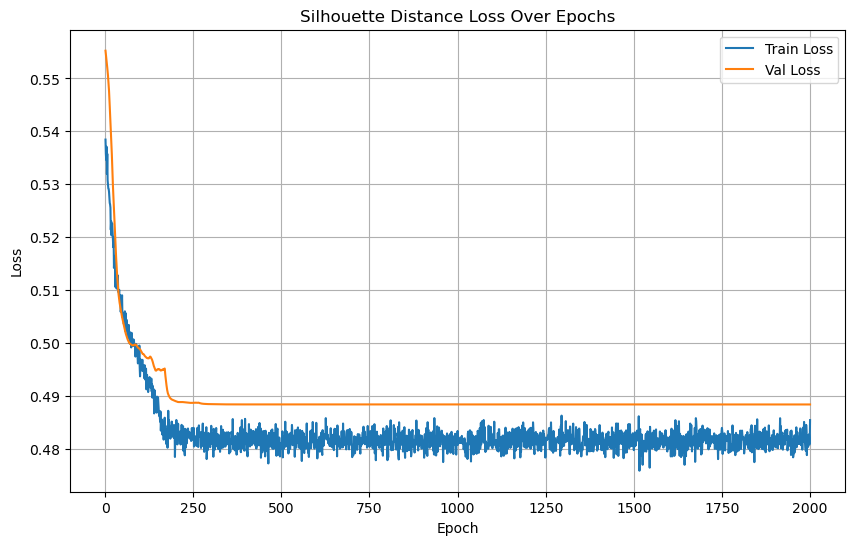

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/77], Loss: 0.3707
Test Batch [20/77], Loss: 0.0674
Test Batch [30/77], Loss: 0.1491


Test Batch [40/77], Loss: 0.5000
Test Batch [50/77], Loss: 0.1715
Test Batch [60/77], Loss: 0.3586
Test Batch [70/77], Loss: 0.5000



Test Loss: 0.3267


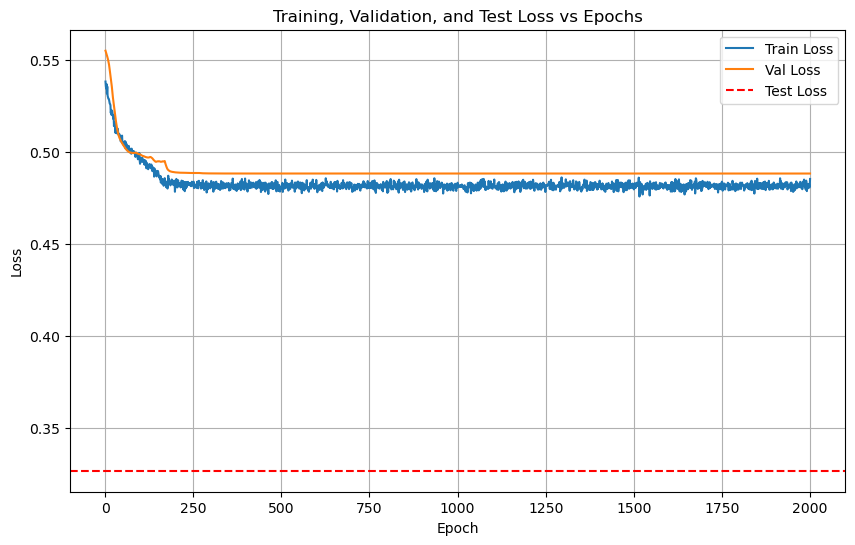

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/77 for test dataset.


  Processed batch 20/77 for test dataset.


  Processed batch 30/77 for test dataset.
  Processed batch 40/77 for test dataset.
  Processed batch 50/77 for test dataset.


  Processed batch 60/77 for test dataset.
  Processed batch 70/77 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 56.92%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.00      0.00      0.00         5
           2       0.67      0.40      0.50         5
           3       0.60      0.60      0.60         5
           4       0.67      0.40      0.50         5
           5       0.43      0.60      0.50         5
           6       0.43      0.60      0.50         5
           7       0.50      0.60      0.55         5
           8       0.62      1.00      0.77         5
           9       0.33      0.20      0.25         5
          10       1.00      1.00      1.00         5
          11       1.00      0.60      0.75         5
          12       0.50      0.80      0.62         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6003  |  Val Loss: 2.5692
Validation loss improved from inf to 2.5692.
[Epoch 2/1000] Train Loss: 2.5905  |  Val Loss: 2.5638
Validation loss improved from 2.5692 to 2.5638.
[Epoch 3/1000] Train Loss: 2.5822  |  Val Loss: 2.5590
Validation loss improved from 2.5638 to 2.5590.
[Epoch 4/1000] Train Loss: 2.5744  |  Val Loss: 2.5544
Validation loss improved from 2.5590 to 2.5544.
[Epoch 5/1000] Train Loss: 2.5667  |  Val Loss: 2.5501
Validation loss improved from 2.5544 to 2.5501.
[Epoch 6/1000] Train Loss: 2.5598  |  Val Loss: 2.5460
Validation loss improved from 2.5501 to 2.5460.
[Epoch 7/1000] Train Loss: 2.5538  |  Val Loss: 2.5421
Validation loss improved from 2.5460 to 2.5421.
[Epoch 8/1000] Train Loss: 2.5476  |  Val Loss: 2.5386
Validation loss improved from 2.5421 to 2.5386.
[Epoch 9/1000] Train Loss: 2.5422  |  Val Loss: 2.5351
Validation loss improved from 2.5386 to 2.5351.


[Epoch 10/1000] Train Loss: 2.5366  |  Val Loss: 2.5313
Validation loss improved from 2.5351 to 2.5313.
[Epoch 11/1000] Train Loss: 2.5317  |  Val Loss: 2.5281
Validation loss improved from 2.5313 to 2.5281.
[Epoch 12/1000] Train Loss: 2.5269  |  Val Loss: 2.5251
Validation loss improved from 2.5281 to 2.5251.
[Epoch 13/1000] Train Loss: 2.5225  |  Val Loss: 2.5221
Validation loss improved from 2.5251 to 2.5221.
[Epoch 14/1000] Train Loss: 2.5183  |  Val Loss: 2.5191
Validation loss improved from 2.5221 to 2.5191.
[Epoch 15/1000] Train Loss: 2.5141  |  Val Loss: 2.5162
Validation loss improved from 2.5191 to 2.5162.


[Epoch 16/1000] Train Loss: 2.5101  |  Val Loss: 2.5132
Validation loss improved from 2.5162 to 2.5132.
[Epoch 17/1000] Train Loss: 2.5058  |  Val Loss: 2.5101
Validation loss improved from 2.5132 to 2.5101.
[Epoch 18/1000] Train Loss: 2.5017  |  Val Loss: 2.5070
Validation loss improved from 2.5101 to 2.5070.
[Epoch 19/1000] Train Loss: 2.4978  |  Val Loss: 2.5035
Validation loss improved from 2.5070 to 2.5035.
[Epoch 20/1000] Train Loss: 2.4931  |  Val Loss: 2.5003
Validation loss improved from 2.5035 to 2.5003.


[Epoch 21/1000] Train Loss: 2.4888  |  Val Loss: 2.4974
Validation loss improved from 2.5003 to 2.4974.
[Epoch 22/1000] Train Loss: 2.4850  |  Val Loss: 2.4947
Validation loss improved from 2.4974 to 2.4947.
[Epoch 23/1000] Train Loss: 2.4811  |  Val Loss: 2.4919
Validation loss improved from 2.4947 to 2.4919.
[Epoch 24/1000] Train Loss: 2.4773  |  Val Loss: 2.4891
Validation loss improved from 2.4919 to 2.4891.
[Epoch 25/1000] Train Loss: 2.4734  |  Val Loss: 2.4862
Validation loss improved from 2.4891 to 2.4862.
[Epoch 26/1000] Train Loss: 2.4694  |  Val Loss: 2.4835
Validation loss improved from 2.4862 to 2.4835.
[Epoch 27/1000] Train Loss: 2.4658  |  Val Loss: 2.4808
Validation loss improved from 2.4835 to 2.4808.
[Epoch 28/1000] Train Loss: 2.4620  |  Val Loss: 2.4782
Validation loss improved from 2.4808 to 2.4782.
[Epoch 29/1000] Train Loss: 2.4584  |  Val Loss: 2.4753
Validation loss improved from 2.4782 to 2.4753.
[Epoch 30/1000] Train Loss: 2.4545  |  Val Loss: 2.4726
Validati

[Epoch 32/1000] Train Loss: 2.4469  |  Val Loss: 2.4668
Validation loss improved from 2.4698 to 2.4668.
[Epoch 33/1000] Train Loss: 2.4425  |  Val Loss: 2.4639
Validation loss improved from 2.4668 to 2.4639.
[Epoch 34/1000] Train Loss: 2.4388  |  Val Loss: 2.4611
Validation loss improved from 2.4639 to 2.4611.
[Epoch 35/1000] Train Loss: 2.4346  |  Val Loss: 2.4583
Validation loss improved from 2.4611 to 2.4583.
[Epoch 36/1000] Train Loss: 2.4308  |  Val Loss: 2.4554
Validation loss improved from 2.4583 to 2.4554.


[Epoch 37/1000] Train Loss: 2.4265  |  Val Loss: 2.4527
Validation loss improved from 2.4554 to 2.4527.
[Epoch 38/1000] Train Loss: 2.4225  |  Val Loss: 2.4502
Validation loss improved from 2.4527 to 2.4502.
[Epoch 39/1000] Train Loss: 2.4188  |  Val Loss: 2.4475
Validation loss improved from 2.4502 to 2.4475.
[Epoch 40/1000] Train Loss: 2.4146  |  Val Loss: 2.4448
Validation loss improved from 2.4475 to 2.4448.


[Epoch 41/1000] Train Loss: 2.4105  |  Val Loss: 2.4420
Validation loss improved from 2.4448 to 2.4420.
[Epoch 42/1000] Train Loss: 2.4063  |  Val Loss: 2.4390
Validation loss improved from 2.4420 to 2.4390.
[Epoch 43/1000] Train Loss: 2.4021  |  Val Loss: 2.4361
Validation loss improved from 2.4390 to 2.4361.
[Epoch 44/1000] Train Loss: 2.3976  |  Val Loss: 2.4329
Validation loss improved from 2.4361 to 2.4329.
[Epoch 45/1000] Train Loss: 2.3927  |  Val Loss: 2.4298
Validation loss improved from 2.4329 to 2.4298.
[Epoch 46/1000] Train Loss: 2.3881  |  Val Loss: 2.4269
Validation loss improved from 2.4298 to 2.4269.
[Epoch 47/1000] Train Loss: 2.3830  |  Val Loss: 2.4239
Validation loss improved from 2.4269 to 2.4239.
[Epoch 48/1000] Train Loss: 2.3781  |  Val Loss: 2.4211
Validation loss improved from 2.4239 to 2.4211.
[Epoch 49/1000] Train Loss: 2.3735  |  Val Loss: 2.4182
Validation loss improved from 2.4211 to 2.4182.


[Epoch 50/1000] Train Loss: 2.3689  |  Val Loss: 2.4152
Validation loss improved from 2.4182 to 2.4152.
[Epoch 51/1000] Train Loss: 2.3641  |  Val Loss: 2.4121
Validation loss improved from 2.4152 to 2.4121.
[Epoch 52/1000] Train Loss: 2.3596  |  Val Loss: 2.4085
Validation loss improved from 2.4121 to 2.4085.
[Epoch 53/1000] Train Loss: 2.3542  |  Val Loss: 2.4054
Validation loss improved from 2.4085 to 2.4054.
[Epoch 54/1000] Train Loss: 2.3492  |  Val Loss: 2.4024
Validation loss improved from 2.4054 to 2.4024.


[Epoch 55/1000] Train Loss: 2.3445  |  Val Loss: 2.3993
Validation loss improved from 2.4024 to 2.3993.
[Epoch 56/1000] Train Loss: 2.3395  |  Val Loss: 2.3962
Validation loss improved from 2.3993 to 2.3962.
[Epoch 57/1000] Train Loss: 2.3343  |  Val Loss: 2.3932
Validation loss improved from 2.3962 to 2.3932.


[Epoch 58/1000] Train Loss: 2.3293  |  Val Loss: 2.3903
Validation loss improved from 2.3932 to 2.3903.
[Epoch 59/1000] Train Loss: 2.3242  |  Val Loss: 2.3871
Validation loss improved from 2.3903 to 2.3871.
[Epoch 60/1000] Train Loss: 2.3190  |  Val Loss: 2.3837
Validation loss improved from 2.3871 to 2.3837.
[Epoch 61/1000] Train Loss: 2.3138  |  Val Loss: 2.3800
Validation loss improved from 2.3837 to 2.3800.
[Epoch 62/1000] Train Loss: 2.3085  |  Val Loss: 2.3763
Validation loss improved from 2.3800 to 2.3763.
[Epoch 63/1000] Train Loss: 2.3035  |  Val Loss: 2.3726
Validation loss improved from 2.3763 to 2.3726.
[Epoch 64/1000] Train Loss: 2.2980  |  Val Loss: 2.3689
Validation loss improved from 2.3726 to 2.3689.
[Epoch 65/1000] Train Loss: 2.2925  |  Val Loss: 2.3654
Validation loss improved from 2.3689 to 2.3654.
[Epoch 66/1000] Train Loss: 2.2873  |  Val Loss: 2.3619
Validation loss improved from 2.3654 to 2.3619.
[Epoch 67/1000] Train Loss: 2.2819  |  Val Loss: 2.3581
Validati

[Epoch 70/1000] Train Loss: 2.2646  |  Val Loss: 2.3452
Validation loss improved from 2.3501 to 2.3452.
[Epoch 71/1000] Train Loss: 2.2587  |  Val Loss: 2.3410
Validation loss improved from 2.3452 to 2.3410.
[Epoch 72/1000] Train Loss: 2.2527  |  Val Loss: 2.3370
Validation loss improved from 2.3410 to 2.3370.
[Epoch 73/1000] Train Loss: 2.2469  |  Val Loss: 2.3339
Validation loss improved from 2.3370 to 2.3339.
[Epoch 74/1000] Train Loss: 2.2421  |  Val Loss: 2.3306
Validation loss improved from 2.3339 to 2.3306.
[Epoch 75/1000] Train Loss: 2.2364  |  Val Loss: 2.3276
Validation loss improved from 2.3306 to 2.3276.


[Epoch 76/1000] Train Loss: 2.2302  |  Val Loss: 2.3246
Validation loss improved from 2.3276 to 2.3246.
[Epoch 77/1000] Train Loss: 2.2245  |  Val Loss: 2.3216
Validation loss improved from 2.3246 to 2.3216.
[Epoch 78/1000] Train Loss: 2.2194  |  Val Loss: 2.3187
Validation loss improved from 2.3216 to 2.3187.
[Epoch 79/1000] Train Loss: 2.2135  |  Val Loss: 2.3150
Validation loss improved from 2.3187 to 2.3150.
[Epoch 80/1000] Train Loss: 2.2080  |  Val Loss: 2.3107
Validation loss improved from 2.3150 to 2.3107.
[Epoch 81/1000] Train Loss: 2.2020  |  Val Loss: 2.3063
Validation loss improved from 2.3107 to 2.3063.
[Epoch 82/1000] Train Loss: 2.1963  |  Val Loss: 2.3029
Validation loss improved from 2.3063 to 2.3029.
[Epoch 83/1000] Train Loss: 2.1909  |  Val Loss: 2.2991
Validation loss improved from 2.3029 to 2.2991.
[Epoch 84/1000] Train Loss: 2.1851  |  Val Loss: 2.2949
Validation loss improved from 2.2991 to 2.2949.
[Epoch 85/1000] Train Loss: 2.1794  |  Val Loss: 2.2905
Validati

[Epoch 89/1000] Train Loss: 2.1574  |  Val Loss: 2.2738
Validation loss improved from 2.2776 to 2.2738.
[Epoch 90/1000] Train Loss: 2.1517  |  Val Loss: 2.2692
Validation loss improved from 2.2738 to 2.2692.
[Epoch 91/1000] Train Loss: 2.1458  |  Val Loss: 2.2651
Validation loss improved from 2.2692 to 2.2651.
[Epoch 92/1000] Train Loss: 2.1405  |  Val Loss: 2.2613
Validation loss improved from 2.2651 to 2.2613.
[Epoch 93/1000] Train Loss: 2.1347  |  Val Loss: 2.2578
Validation loss improved from 2.2613 to 2.2578.


[Epoch 94/1000] Train Loss: 2.1283  |  Val Loss: 2.2545
Validation loss improved from 2.2578 to 2.2545.
[Epoch 95/1000] Train Loss: 2.1226  |  Val Loss: 2.2514
Validation loss improved from 2.2545 to 2.2514.
[Epoch 96/1000] Train Loss: 2.1166  |  Val Loss: 2.2482
Validation loss improved from 2.2514 to 2.2482.
[Epoch 97/1000] Train Loss: 2.1105  |  Val Loss: 2.2442
Validation loss improved from 2.2482 to 2.2442.
[Epoch 98/1000] Train Loss: 2.1044  |  Val Loss: 2.2401
Validation loss improved from 2.2442 to 2.2401.
[Epoch 99/1000] Train Loss: 2.0984  |  Val Loss: 2.2359
Validation loss improved from 2.2401 to 2.2359.
[Epoch 100/1000] Train Loss: 2.0921  |  Val Loss: 2.2316
Validation loss improved from 2.2359 to 2.2316.
[Epoch 101/1000] Train Loss: 2.0858  |  Val Loss: 2.2267
Validation loss improved from 2.2316 to 2.2267.
[Epoch 102/1000] Train Loss: 2.0797  |  Val Loss: 2.2222
Validation loss improved from 2.2267 to 2.2222.
[Epoch 103/1000] Train Loss: 2.0734  |  Val Loss: 2.2178
Vali

[Epoch 108/1000] Train Loss: 2.0406  |  Val Loss: 2.1986
Validation loss improved from 2.2034 to 2.1986.
[Epoch 109/1000] Train Loss: 2.0332  |  Val Loss: 2.1947
Validation loss improved from 2.1986 to 2.1947.
[Epoch 110/1000] Train Loss: 2.0259  |  Val Loss: 2.1903
Validation loss improved from 2.1947 to 2.1903.
[Epoch 111/1000] Train Loss: 2.0194  |  Val Loss: 2.1861
Validation loss improved from 2.1903 to 2.1861.
[Epoch 112/1000] Train Loss: 2.0124  |  Val Loss: 2.1812
Validation loss improved from 2.1861 to 2.1812.
[Epoch 113/1000] Train Loss: 2.0056  |  Val Loss: 2.1739
Validation loss improved from 2.1812 to 2.1739.
[Epoch 114/1000] Train Loss: 1.9990  |  Val Loss: 2.1677
Validation loss improved from 2.1739 to 2.1677.


[Epoch 115/1000] Train Loss: 1.9920  |  Val Loss: 2.1622
Validation loss improved from 2.1677 to 2.1622.
[Epoch 116/1000] Train Loss: 1.9853  |  Val Loss: 2.1579
Validation loss improved from 2.1622 to 2.1579.
[Epoch 117/1000] Train Loss: 1.9787  |  Val Loss: 2.1538
Validation loss improved from 2.1579 to 2.1538.
[Epoch 118/1000] Train Loss: 1.9713  |  Val Loss: 2.1499
Validation loss improved from 2.1538 to 2.1499.
[Epoch 119/1000] Train Loss: 1.9636  |  Val Loss: 2.1471
Validation loss improved from 2.1499 to 2.1471.
[Epoch 120/1000] Train Loss: 1.9560  |  Val Loss: 2.1436
Validation loss improved from 2.1471 to 2.1436.
[Epoch 121/1000] Train Loss: 1.9482  |  Val Loss: 2.1414
Validation loss improved from 2.1436 to 2.1414.
[Epoch 122/1000] Train Loss: 1.9407  |  Val Loss: 2.1431
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 1.9342  |  Val Loss: 2.1423
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Train Loss: 1.9275  |  Val

[Epoch 128/1000] Train Loss: 1.8955  |  Val Loss: 2.1143
Validation loss improved from 2.1221 to 2.1143.
[Epoch 129/1000] Train Loss: 1.8880  |  Val Loss: 2.1043
Validation loss improved from 2.1143 to 2.1043.
[Epoch 130/1000] Train Loss: 1.8804  |  Val Loss: 2.0974
Validation loss improved from 2.1043 to 2.0974.
[Epoch 131/1000] Train Loss: 1.8728  |  Val Loss: 2.0931
Validation loss improved from 2.0974 to 2.0931.
[Epoch 132/1000] Train Loss: 1.8650  |  Val Loss: 2.0897
Validation loss improved from 2.0931 to 2.0897.
[Epoch 133/1000] Train Loss: 1.8570  |  Val Loss: 2.0863
Validation loss improved from 2.0897 to 2.0863.
[Epoch 134/1000] Train Loss: 1.8495  |  Val Loss: 2.0808
Validation loss improved from 2.0863 to 2.0808.


[Epoch 135/1000] Train Loss: 1.8419  |  Val Loss: 2.0759
Validation loss improved from 2.0808 to 2.0759.
[Epoch 136/1000] Train Loss: 1.8345  |  Val Loss: 2.0732
Validation loss improved from 2.0759 to 2.0732.
[Epoch 137/1000] Train Loss: 1.8270  |  Val Loss: 2.0689
Validation loss improved from 2.0732 to 2.0689.
[Epoch 138/1000] Train Loss: 1.8196  |  Val Loss: 2.0643
Validation loss improved from 2.0689 to 2.0643.
[Epoch 139/1000] Train Loss: 1.8118  |  Val Loss: 2.0588
Validation loss improved from 2.0643 to 2.0588.
[Epoch 140/1000] Train Loss: 1.8041  |  Val Loss: 2.0530
Validation loss improved from 2.0588 to 2.0530.
[Epoch 141/1000] Train Loss: 1.7965  |  Val Loss: 2.0458
Validation loss improved from 2.0530 to 2.0458.
[Epoch 142/1000] Train Loss: 1.7892  |  Val Loss: 2.0325
Validation loss improved from 2.0458 to 2.0325.
[Epoch 143/1000] Train Loss: 1.7821  |  Val Loss: 2.0235
Validation loss improved from 2.0325 to 2.0235.


[Epoch 144/1000] Train Loss: 1.7751  |  Val Loss: 2.0168
Validation loss improved from 2.0235 to 2.0168.
[Epoch 145/1000] Train Loss: 1.7672  |  Val Loss: 2.0108
Validation loss improved from 2.0168 to 2.0108.
[Epoch 146/1000] Train Loss: 1.7595  |  Val Loss: 2.0047
Validation loss improved from 2.0108 to 2.0047.
[Epoch 147/1000] Train Loss: 1.7520  |  Val Loss: 1.9993
Validation loss improved from 2.0047 to 1.9993.
[Epoch 148/1000] Train Loss: 1.7444  |  Val Loss: 1.9958
Validation loss improved from 1.9993 to 1.9958.
[Epoch 149/1000] Train Loss: 1.7363  |  Val Loss: 1.9912
Validation loss improved from 1.9958 to 1.9912.
[Epoch 150/1000] Train Loss: 1.7286  |  Val Loss: 1.9876
Validation loss improved from 1.9912 to 1.9876.
[Epoch 151/1000] Train Loss: 1.7214  |  Val Loss: 1.9870
Validation loss improved from 1.9876 to 1.9870.
[Epoch 152/1000] Train Loss: 1.7136  |  Val Loss: 1.9859
Validation loss improved from 1.9870 to 1.9859.


[Epoch 153/1000] Train Loss: 1.7063  |  Val Loss: 1.9832
Validation loss improved from 1.9859 to 1.9832.
[Epoch 154/1000] Train Loss: 1.6986  |  Val Loss: 1.9791
Validation loss improved from 1.9832 to 1.9791.
[Epoch 155/1000] Train Loss: 1.6906  |  Val Loss: 1.9743
Validation loss improved from 1.9791 to 1.9743.
[Epoch 156/1000] Train Loss: 1.6824  |  Val Loss: 1.9687
Validation loss improved from 1.9743 to 1.9687.
[Epoch 157/1000] Train Loss: 1.6751  |  Val Loss: 1.9630
Validation loss improved from 1.9687 to 1.9630.
[Epoch 158/1000] Train Loss: 1.6676  |  Val Loss: 1.9575
Validation loss improved from 1.9630 to 1.9575.
[Epoch 159/1000] Train Loss: 1.6605  |  Val Loss: 1.9516
Validation loss improved from 1.9575 to 1.9516.
[Epoch 160/1000] Train Loss: 1.6532  |  Val Loss: 1.9455
Validation loss improved from 1.9516 to 1.9455.
[Epoch 161/1000] Train Loss: 1.6453  |  Val Loss: 1.9388
Validation loss improved from 1.9455 to 1.9388.
[Epoch 162/1000] Train Loss: 1.6376  |  Val Loss: 1.933

[Epoch 165/1000] Train Loss: 1.6145  |  Val Loss: 1.9163
Validation loss improved from 1.9214 to 1.9163.
[Epoch 166/1000] Train Loss: 1.6069  |  Val Loss: 1.9159
Validation loss improved from 1.9163 to 1.9159.
[Epoch 167/1000] Train Loss: 1.5997  |  Val Loss: 1.9133
Validation loss improved from 1.9159 to 1.9133.
[Epoch 168/1000] Train Loss: 1.5931  |  Val Loss: 1.9091
Validation loss improved from 1.9133 to 1.9091.
[Epoch 169/1000] Train Loss: 1.5861  |  Val Loss: 1.9017
Validation loss improved from 1.9091 to 1.9017.
[Epoch 170/1000] Train Loss: 1.5778  |  Val Loss: 1.8960
Validation loss improved from 1.9017 to 1.8960.
[Epoch 171/1000] Train Loss: 1.5708  |  Val Loss: 1.8905
Validation loss improved from 1.8960 to 1.8905.
[Epoch 172/1000] Train Loss: 1.5637  |  Val Loss: 1.8900
Validation loss improved from 1.8905 to 1.8900.


[Epoch 173/1000] Train Loss: 1.5571  |  Val Loss: 1.8880
Validation loss improved from 1.8900 to 1.8880.
[Epoch 174/1000] Train Loss: 1.5503  |  Val Loss: 1.8844
Validation loss improved from 1.8880 to 1.8844.
[Epoch 175/1000] Train Loss: 1.5432  |  Val Loss: 1.8799
Validation loss improved from 1.8844 to 1.8799.
[Epoch 176/1000] Train Loss: 1.5362  |  Val Loss: 1.8739
Validation loss improved from 1.8799 to 1.8739.
[Epoch 177/1000] Train Loss: 1.5294  |  Val Loss: 1.8674
Validation loss improved from 1.8739 to 1.8674.
[Epoch 178/1000] Train Loss: 1.5228  |  Val Loss: 1.8620
Validation loss improved from 1.8674 to 1.8620.
[Epoch 179/1000] Train Loss: 1.5161  |  Val Loss: 1.8577
Validation loss improved from 1.8620 to 1.8577.
[Epoch 180/1000] Train Loss: 1.5094  |  Val Loss: 1.8541
Validation loss improved from 1.8577 to 1.8541.
[Epoch 181/1000] Train Loss: 1.5027  |  Val Loss: 1.8540
Validation loss improved from 1.8541 to 1.8540.
[Epoch 182/1000] Train Loss: 1.4961  |  Val Loss: 1.853

[Epoch 185/1000] Train Loss: 1.4765  |  Val Loss: 1.8380
Validation loss improved from 1.8432 to 1.8380.
[Epoch 186/1000] Train Loss: 1.4701  |  Val Loss: 1.8336
Validation loss improved from 1.8380 to 1.8336.
[Epoch 187/1000] Train Loss: 1.4634  |  Val Loss: 1.8303
Validation loss improved from 1.8336 to 1.8303.
[Epoch 188/1000] Train Loss: 1.4568  |  Val Loss: 1.8270
Validation loss improved from 1.8303 to 1.8270.
[Epoch 189/1000] Train Loss: 1.4502  |  Val Loss: 1.8228
Validation loss improved from 1.8270 to 1.8228.
[Epoch 190/1000] Train Loss: 1.4437  |  Val Loss: 1.8183
Validation loss improved from 1.8228 to 1.8183.
[Epoch 191/1000] Train Loss: 1.4387  |  Val Loss: 1.8143
Validation loss improved from 1.8183 to 1.8143.
[Epoch 192/1000] Train Loss: 1.4341  |  Val Loss: 1.8082
Validation loss improved from 1.8143 to 1.8082.
[Epoch 193/1000] Train Loss: 1.4281  |  Val Loss: 1.8005
Validation loss improved from 1.8082 to 1.8005.


[Epoch 194/1000] Train Loss: 1.4213  |  Val Loss: 1.7974
Validation loss improved from 1.8005 to 1.7974.
[Epoch 195/1000] Train Loss: 1.4152  |  Val Loss: 1.7945
Validation loss improved from 1.7974 to 1.7945.
[Epoch 196/1000] Train Loss: 1.4093  |  Val Loss: 1.7918
Validation loss improved from 1.7945 to 1.7918.
[Epoch 197/1000] Train Loss: 1.4037  |  Val Loss: 1.7891
Validation loss improved from 1.7918 to 1.7891.
[Epoch 198/1000] Train Loss: 1.3975  |  Val Loss: 1.7886
Validation loss improved from 1.7891 to 1.7886.
[Epoch 199/1000] Train Loss: 1.3918  |  Val Loss: 1.7958
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 200/1000] Train Loss: 1.3875  |  Val Loss: 1.8028
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 201/1000] Train Loss: 1.3830  |  Val Loss: 1.8055
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 202/1000] Train Loss: 1.3767  |  Val Loss: 1.8035
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 203/1000] Train Loss: 1.

[Epoch 205/1000] Train Loss: 1.3577  |  Val Loss: 1.7932
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 206/1000] Train Loss: 1.3531  |  Val Loss: 1.7967
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 207/1000] Train Loss: 1.3485  |  Val Loss: 1.7959
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 208/1000] Train Loss: 1.3443  |  Val Loss: 1.7948
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 209/1000] Train Loss: 1.3396  |  Val Loss: 1.7864
Validation loss improved from 1.7886 to 1.7864.
[Epoch 210/1000] Train Loss: 1.3336  |  Val Loss: 1.7784
Validation loss improved from 1.7864 to 1.7784.
[Epoch 211/1000] Train Loss: 1.3274  |  Val Loss: 1.7693
Validation loss improved from 1.7784 to 1.7693.
[Epoch 212/1000] Train Loss: 1.3213  |  Val Loss: 1.7638
Validation loss improved from 1.7693 to 1.7638.
[Epoch 213/1000] Train Loss: 1.3148  |  Val Loss: 1.7761
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 214/1000] Train Loss: 1.3129  |  Val Loss: 1.7880
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 215/1000] Train Loss: 1.3105  |  Val Loss: 1.7888
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 216/1000] Train Loss: 1.3063  |  Val Loss: 1.7817
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 217/1000] Train Loss: 1.3005  |  Val Loss: 1.7720
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 218/1000] Train Loss: 1.2947  |  Val Loss: 1.7616
Validation loss improved from 1.7638 to 1.7616.
[Epoch 219/1000] Train Loss: 1.2883  |  Val Loss: 1.7537
Validation loss improved from 1.7616 to 1.7537.
[Epoch 220/1000] Train Loss: 1.2828  |  Val Loss: 1.7463
Validation loss improved from 1.7537 to 1.7463.
[Epoch 221/1000] Train Loss: 1.2781  |  Val Loss: 1.7385
Validation loss improved from 1.7463 to 1.7385.
[Epoch 222/1000] Train Loss: 1.2733  |  Val Loss: 1.7317
Validation loss improved from 1.7385 to 1.7317.
[Epoch 223/1000] Train Loss: 1.

[Epoch 225/1000] Train Loss: 1.2601  |  Val Loss: 1.7285
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 226/1000] Train Loss: 1.2564  |  Val Loss: 1.7317
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 227/1000] Train Loss: 1.2525  |  Val Loss: 1.7314
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 228/1000] Train Loss: 1.2479  |  Val Loss: 1.7312
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 229/1000] Train Loss: 1.2433  |  Val Loss: 1.7292
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 230/1000] Train Loss: 1.2389  |  Val Loss: 1.7264
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 231/1000] Train Loss: 1.2347  |  Val Loss: 1.7247
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 232/1000] Train Loss: 1.2303  |  Val Loss: 1.7225
Validation loss improved from 1.7239 to 1.7225.


[Epoch 233/1000] Train Loss: 1.2263  |  Val Loss: 1.7199
Validation loss improved from 1.7225 to 1.7199.
[Epoch 234/1000] Train Loss: 1.2219  |  Val Loss: 1.7191
Validation loss improved from 1.7199 to 1.7191.
[Epoch 235/1000] Train Loss: 1.2183  |  Val Loss: 1.7145
Validation loss improved from 1.7191 to 1.7145.
[Epoch 236/1000] Train Loss: 1.2143  |  Val Loss: 1.7124
Validation loss improved from 1.7145 to 1.7124.
[Epoch 237/1000] Train Loss: 1.2105  |  Val Loss: 1.7108
Validation loss improved from 1.7124 to 1.7108.
[Epoch 238/1000] Train Loss: 1.2067  |  Val Loss: 1.7077
Validation loss improved from 1.7108 to 1.7077.
[Epoch 239/1000] Train Loss: 1.2026  |  Val Loss: 1.7028
Validation loss improved from 1.7077 to 1.7028.
[Epoch 240/1000] Train Loss: 1.1989  |  Val Loss: 1.7020
Validation loss improved from 1.7028 to 1.7020.
[Epoch 241/1000] Train Loss: 1.1949  |  Val Loss: 1.7013
Validation loss improved from 1.7020 to 1.7013.
[Epoch 242/1000] Train Loss: 1.1907  |  Val Loss: 1.702

[Epoch 243/1000] Train Loss: 1.1870  |  Val Loss: 1.7025
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 244/1000] Train Loss: 1.1834  |  Val Loss: 1.6990
Validation loss improved from 1.7013 to 1.6990.
[Epoch 245/1000] Train Loss: 1.1796  |  Val Loss: 1.6957
Validation loss improved from 1.6990 to 1.6957.
[Epoch 246/1000] Train Loss: 1.1767  |  Val Loss: 1.6922
Validation loss improved from 1.6957 to 1.6922.
[Epoch 247/1000] Train Loss: 1.1732  |  Val Loss: 1.6885
Validation loss improved from 1.6922 to 1.6885.
[Epoch 248/1000] Train Loss: 1.1702  |  Val Loss: 1.6864
Validation loss improved from 1.6885 to 1.6864.
[Epoch 249/1000] Train Loss: 1.1664  |  Val Loss: 1.6847
Validation loss improved from 1.6864 to 1.6847.
[Epoch 250/1000] Train Loss: 1.1632  |  Val Loss: 1.6808
Validation loss improved from 1.6847 to 1.6808.
[Epoch 251/1000] Train Loss: 1.1600  |  Val Loss: 1.6783
Validation loss improved from 1.6808 to 1.6783.
[Epoch 252/1000] Train Loss: 1.1571  |  Val Loss:

[Epoch 253/1000] Train Loss: 1.1536  |  Val Loss: 1.6798
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 254/1000] Train Loss: 1.1502  |  Val Loss: 1.6808
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 255/1000] Train Loss: 1.1466  |  Val Loss: 1.6812
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 256/1000] Train Loss: 1.1435  |  Val Loss: 1.6800
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 257/1000] Train Loss: 1.1400  |  Val Loss: 1.6788
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 258/1000] Train Loss: 1.1368  |  Val Loss: 1.6770
Validation loss improved from 1.6783 to 1.6770.
[Epoch 259/1000] Train Loss: 1.1336  |  Val Loss: 1.6767
Validation loss improved from 1.6770 to 1.6767.
[Epoch 260/1000] Train Loss: 1.1304  |  Val Loss: 1.6788
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 261/1000] Train Loss: 1.1267  |  Val Loss: 1.6857
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 262/10

[Epoch 264/1000] Train Loss: 1.1171  |  Val Loss: 1.6872
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 265/1000] Train Loss: 1.1140  |  Val Loss: 1.6874
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 266/1000] Train Loss: 1.1109  |  Val Loss: 1.6819
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 267/1000] Train Loss: 1.1074  |  Val Loss: 1.6798
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 268/1000] Train Loss: 1.1045  |  Val Loss: 1.6778
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 269/1000] Train Loss: 1.1018  |  Val Loss: 1.6755
Validation loss improved from 1.6767 to 1.6755.
[Epoch 270/1000] Train Loss: 1.0993  |  Val Loss: 1.6755
Validation loss improved from 1.6755 to 1.6755.
[Epoch 271/1000] Train Loss: 1.0967  |  Val Loss: 1.6768
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 272/1000] Train Loss: 1.0937  |  Val Loss: 1.6749
Validation loss improved from 1.6755 to 1.6749.


[Epoch 273/1000] Train Loss: 1.0905  |  Val Loss: 1.6735
Validation loss improved from 1.6749 to 1.6735.
[Epoch 274/1000] Train Loss: 1.0876  |  Val Loss: 1.6731
Validation loss improved from 1.6735 to 1.6731.
[Epoch 275/1000] Train Loss: 1.0845  |  Val Loss: 1.6713
Validation loss improved from 1.6731 to 1.6713.
[Epoch 276/1000] Train Loss: 1.0815  |  Val Loss: 1.6688
Validation loss improved from 1.6713 to 1.6688.
[Epoch 277/1000] Train Loss: 1.0786  |  Val Loss: 1.6683
Validation loss improved from 1.6688 to 1.6683.
[Epoch 278/1000] Train Loss: 1.0755  |  Val Loss: 1.6734
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 279/1000] Train Loss: 1.0733  |  Val Loss: 1.6797
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 280/1000] Train Loss: 1.0707  |  Val Loss: 1.6824
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 281/1000] Train Loss: 1.0680  |  Val Loss: 1.6839
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 282/1000] Train Loss: 1.

[Epoch 284/1000] Train Loss: 1.0604  |  Val Loss: 1.6809
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 285/1000] Train Loss: 1.0580  |  Val Loss: 1.6794
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 286/1000] Train Loss: 1.0556  |  Val Loss: 1.6780
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 287/1000] Train Loss: 1.0530  |  Val Loss: 1.6790
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 288/1000] Train Loss: 1.0506  |  Val Loss: 1.6857
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 289/1000] Train Loss: 1.0484  |  Val Loss: 1.6883
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 290/1000] Train Loss: 1.0459  |  Val Loss: 1.6890
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 291/1000] Train Loss: 1.0435  |  Val Loss: 1.6866
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 292/1000] Train Loss: 1.0406  |  Val Loss: 1.6826
!! Validation loss did NOT improve !! Patience: 15

[Epoch 295/1000] Train Loss: 1.0323  |  Val Loss: 1.6638
Validation loss improved from 1.6680 to 1.6638.
[Epoch 296/1000] Train Loss: 1.0299  |  Val Loss: 1.6630
Validation loss improved from 1.6638 to 1.6630.
[Epoch 297/1000] Train Loss: 1.0276  |  Val Loss: 1.6623
Validation loss improved from 1.6630 to 1.6623.
[Epoch 298/1000] Train Loss: 1.0256  |  Val Loss: 1.6623
Validation loss improved from 1.6623 to 1.6623.
[Epoch 299/1000] Train Loss: 1.0234  |  Val Loss: 1.6626
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 300/1000] Train Loss: 1.0211  |  Val Loss: 1.6626
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 301/1000] Train Loss: 1.0187  |  Val Loss: 1.6672
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 302/1000] Train Loss: 1.0164  |  Val Loss: 1.6691
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 303/1000] Train Loss: 1.0146  |  Val Loss: 1.6718
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 304/1000] Train Loss: 1.0123  |  Val Loss: 1.6730
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 305/1000] Train Loss: 1.0101  |  Val Loss: 1.6746
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 306/1000] Train Loss: 1.0080  |  Val Loss: 1.6740
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 307/1000] Train Loss: 1.0058  |  Val Loss: 1.6747
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 308/1000] Train Loss: 1.0041  |  Val Loss: 1.6743
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 309/1000] Train Loss: 1.0016  |  Val Loss: 1.6748
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 310/1000] Train Loss: 0.9992  |  Val Loss: 1.6785
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 311/1000] Train Loss: 0.9972  |  Val Loss: 1.6819
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 312/1000] Train Loss: 0.9953  |  Val Loss: 1.6835
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 315/1000] Train Loss: 0.9899  |  Val Loss: 1.6803
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 316/1000] Train Loss: 0.9892  |  Val Loss: 1.6805
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 317/1000] Train Loss: 0.9870  |  Val Loss: 1.6836
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 318/1000] Train Loss: 0.9845  |  Val Loss: 1.6933
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 319/1000] Train Loss: 0.9827  |  Val Loss: 1.6989
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 320/1000] Train Loss: 0.9811  |  Val Loss: 1.6995
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 321/1000] Train Loss: 0.9791  |  Val Loss: 1.6977
!! Validation loss did NOT improve !! Patience: 23/100


[Epoch 322/1000] Train Loss: 0.9766  |  Val Loss: 1.6928
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 323/1000] Train Loss: 0.9735  |  Val Loss: 1.6857
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 324/1000] Train Loss: 0.9718  |  Val Loss: 1.6787
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 325/1000] Train Loss: 0.9697  |  Val Loss: 1.6740
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 326/1000] Train Loss: 0.9681  |  Val Loss: 1.6724
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 327/1000] Train Loss: 0.9663  |  Val Loss: 1.6715
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 328/1000] Train Loss: 0.9644  |  Val Loss: 1.6713
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 329/1000] Train Loss: 0.9623  |  Val Loss: 1.6749
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 330/1000] Train Loss: 0.9609  |  Val Loss: 1.6827
!! Validation loss did NOT improve !! Patience:

[Epoch 332/1000] Train Loss: 0.9572  |  Val Loss: 1.6867
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 333/1000] Train Loss: 0.9558  |  Val Loss: 1.6873
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 334/1000] Train Loss: 0.9542  |  Val Loss: 1.6868
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 335/1000] Train Loss: 0.9522  |  Val Loss: 1.6892
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 336/1000] Train Loss: 0.9502  |  Val Loss: 1.6911
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 337/1000] Train Loss: 0.9486  |  Val Loss: 1.6939
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 338/1000] Train Loss: 0.9474  |  Val Loss: 1.7025
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 339/1000] Train Loss: 0.9459  |  Val Loss: 1.7090
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 340/1000] Train Loss: 0.9446  |  Val Loss: 1.7111
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 341/1000] Train Loss: 0.9427  |  Val Loss: 1.7076
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 342/1000] Train Loss: 0.9409  |  Val Loss: 1.7009
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 343/1000] Train Loss: 0.9389  |  Val Loss: 1.6964
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 344/1000] Train Loss: 0.9372  |  Val Loss: 1.6941
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 345/1000] Train Loss: 0.9357  |  Val Loss: 1.6944
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 346/1000] Train Loss: 0.9345  |  Val Loss: 1.6951
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 347/1000] Train Loss: 0.9331  |  Val Loss: 1.6974
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 348/1000] Train Loss: 0.9316  |  Val Loss: 1.6982
!! Validation loss did NOT improve !! Patience:

[Epoch 352/1000] Train Loss: 0.9251  |  Val Loss: 1.7146
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 353/1000] Train Loss: 0.9233  |  Val Loss: 1.7150
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 354/1000] Train Loss: 0.9221  |  Val Loss: 1.7130
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 355/1000] Train Loss: 0.9207  |  Val Loss: 1.7124
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 356/1000] Train Loss: 0.9194  |  Val Loss: 1.7124
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 357/1000] Train Loss: 0.9180  |  Val Loss: 1.7140
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 358/1000] Train Loss: 0.9169  |  Val Loss: 1.7174
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 359/1000] Train Loss: 0.9155  |  Val Loss: 1.7202
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 360/1000] Train Loss: 0.9142  |  Val Loss: 1.7224
!! Validation loss did NOT improve !! Patience:

[Epoch 361/1000] Train Loss: 0.9124  |  Val Loss: 1.7231
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 362/1000] Train Loss: 0.9106  |  Val Loss: 1.7306
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 363/1000] Train Loss: 0.9098  |  Val Loss: 1.7363
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 364/1000] Train Loss: 0.9087  |  Val Loss: 1.7366
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 365/1000] Train Loss: 0.9071  |  Val Loss: 1.7364
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 366/1000] Train Loss: 0.9057  |  Val Loss: 1.7358
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 367/1000] Train Loss: 0.9043  |  Val Loss: 1.7374
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 368/1000] Train Loss: 0.9022  |  Val Loss: 1.7359
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 369/1000] Train Loss: 0.9008  |  Val Loss: 1.7343
!! Validation loss did NOT improve !! Patience:

[Epoch 370/1000] Train Loss: 0.8993  |  Val Loss: 1.7334
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 371/1000] Train Loss: 0.8978  |  Val Loss: 1.7328
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 372/1000] Train Loss: 0.8967  |  Val Loss: 1.7302
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 373/1000] Train Loss: 0.8957  |  Val Loss: 1.7250
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 374/1000] Train Loss: 0.8941  |  Val Loss: 1.7214
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 375/1000] Train Loss: 0.8927  |  Val Loss: 1.7191
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 376/1000] Train Loss: 0.8919  |  Val Loss: 1.7181
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 377/1000] Train Loss: 0.8908  |  Val Loss: 1.7213
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 378/1000] Train Loss: 0.8895  |  Val Loss: 1.7218
!! Validation loss did NOT improve !! Patience:

[Epoch 383/1000] Train Loss: 0.8830  |  Val Loss: 1.7490
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 384/1000] Train Loss: 0.8815  |  Val Loss: 1.7594
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 385/1000] Train Loss: 0.8800  |  Val Loss: 1.7685
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 386/1000] Train Loss: 0.8787  |  Val Loss: 1.7729
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 387/1000] Train Loss: 0.8772  |  Val Loss: 1.7730
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 388/1000] Train Loss: 0.8757  |  Val Loss: 1.7712
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 389/1000] Train Loss: 0.8745  |  Val Loss: 1.7725
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 390/1000] Train Loss: 0.8731  |  Val Loss: 1.7754
!! Validation loss did NOT improve !! Patience: 92/100


[Epoch 391/1000] Train Loss: 0.8722  |  Val Loss: 1.7772
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 392/1000] Train Loss: 0.8705  |  Val Loss: 1.7743
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 393/1000] Train Loss: 0.8694  |  Val Loss: 1.7742
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 394/1000] Train Loss: 0.8684  |  Val Loss: 1.7712
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 395/1000] Train Loss: 0.8670  |  Val Loss: 1.7659
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 396/1000] Train Loss: 0.8660  |  Val Loss: 1.7618
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 397/1000] Train Loss: 0.8643  |  Val Loss: 1.7625
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 398/1000] Train Loss: 0.8629  |  Val Loss: 1.7664
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 398 !!
No improvement for 100 epochs.


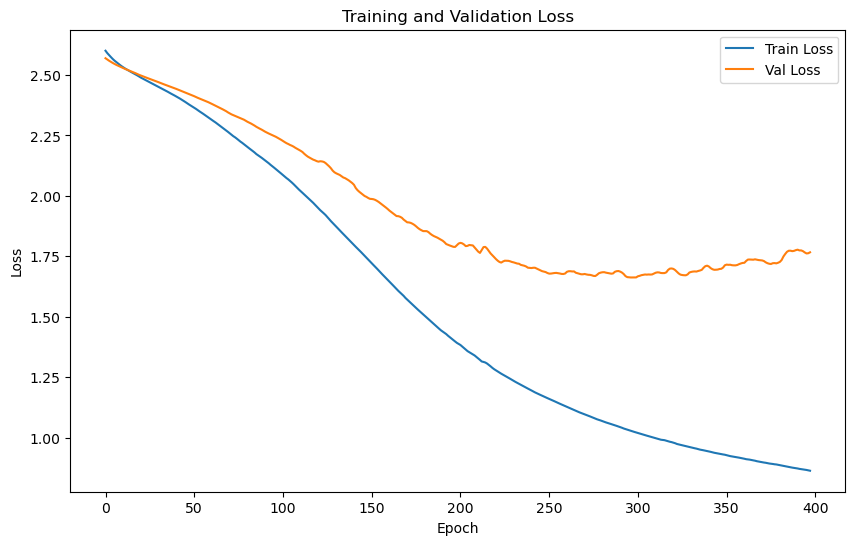

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.9276 | Test Accuracy: 54.87%


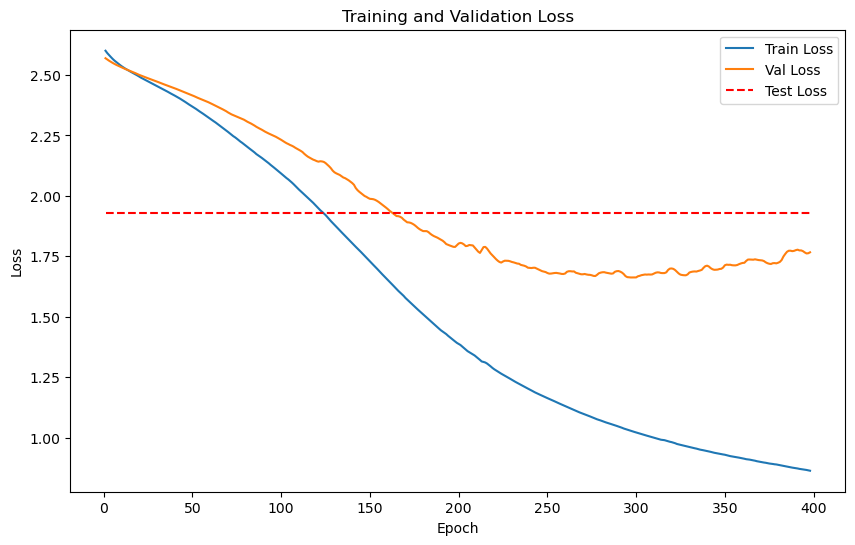

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


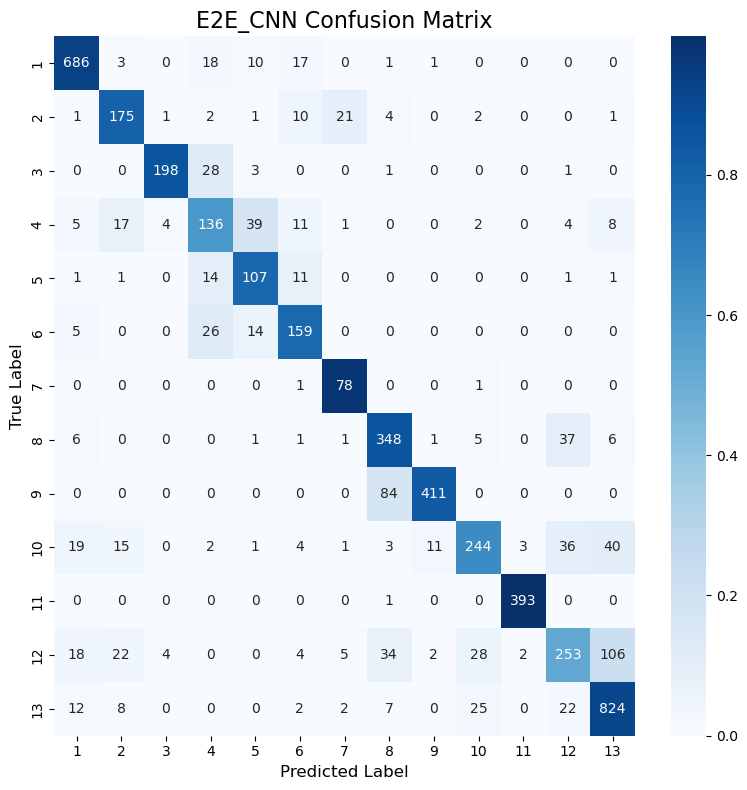

Classification Accuracy: 82.11%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


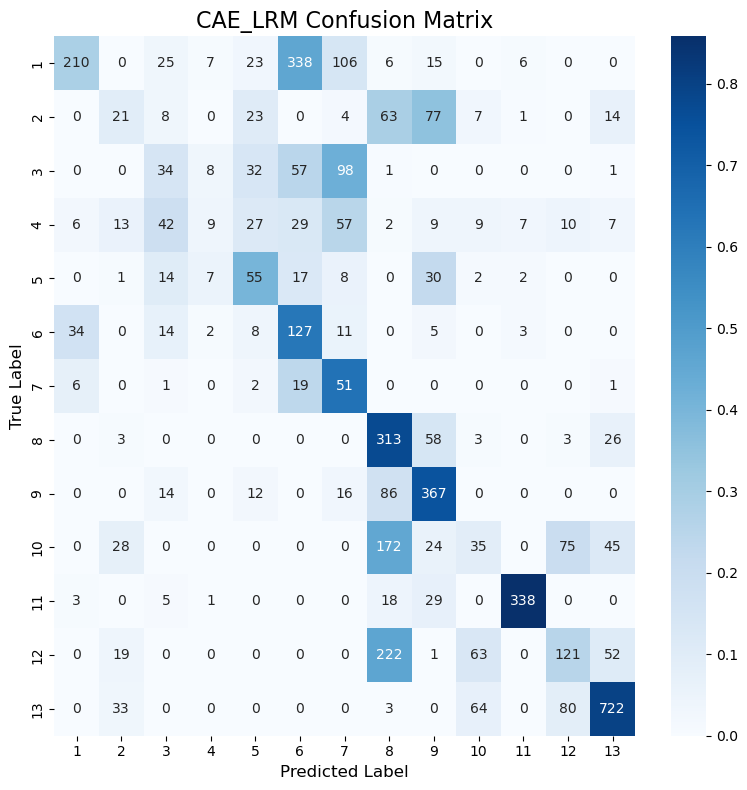

Classification Accuracy: 49.18%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


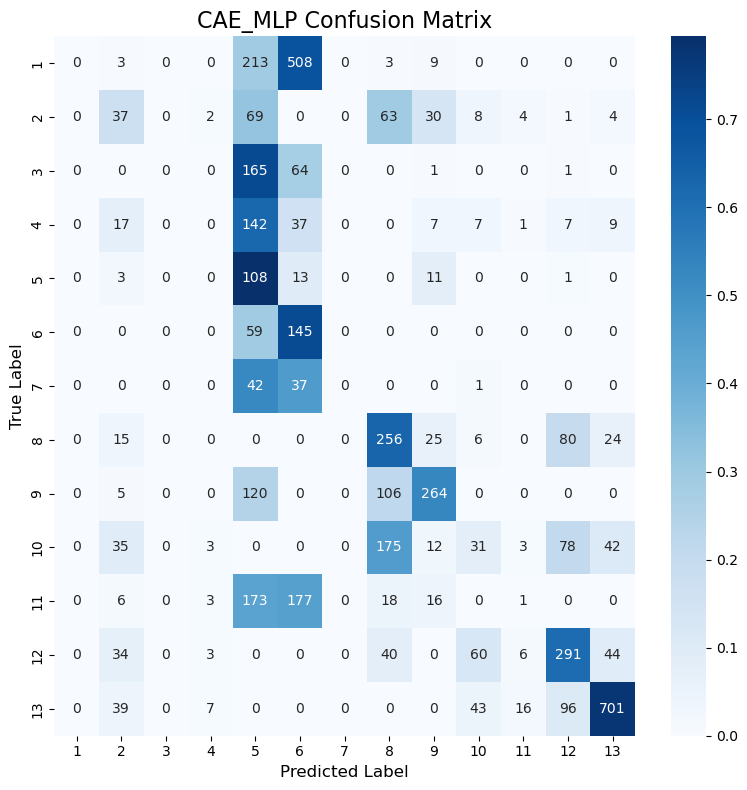

Classification Accuracy: 37.54%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


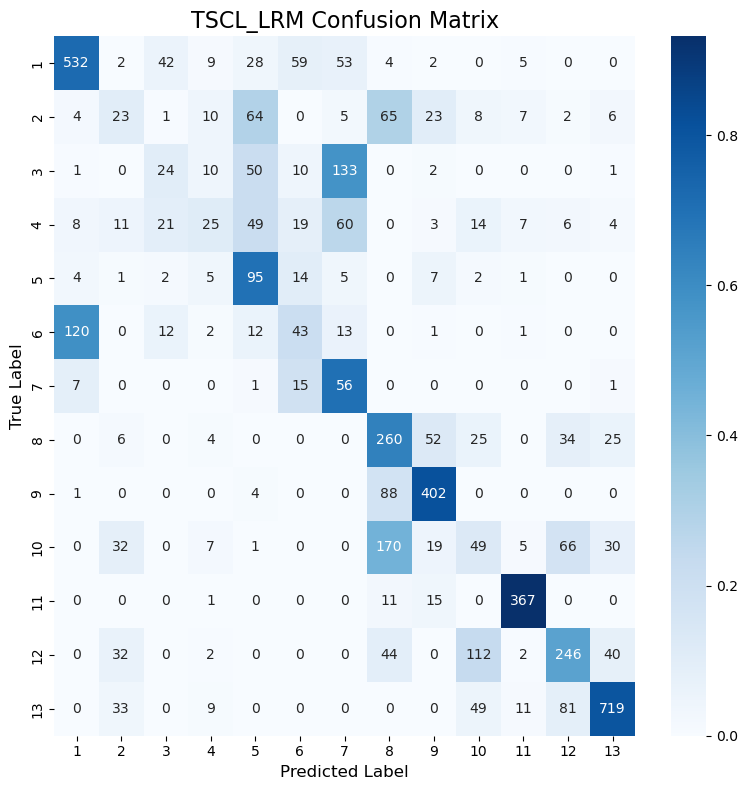

Classification Accuracy: 58.15%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


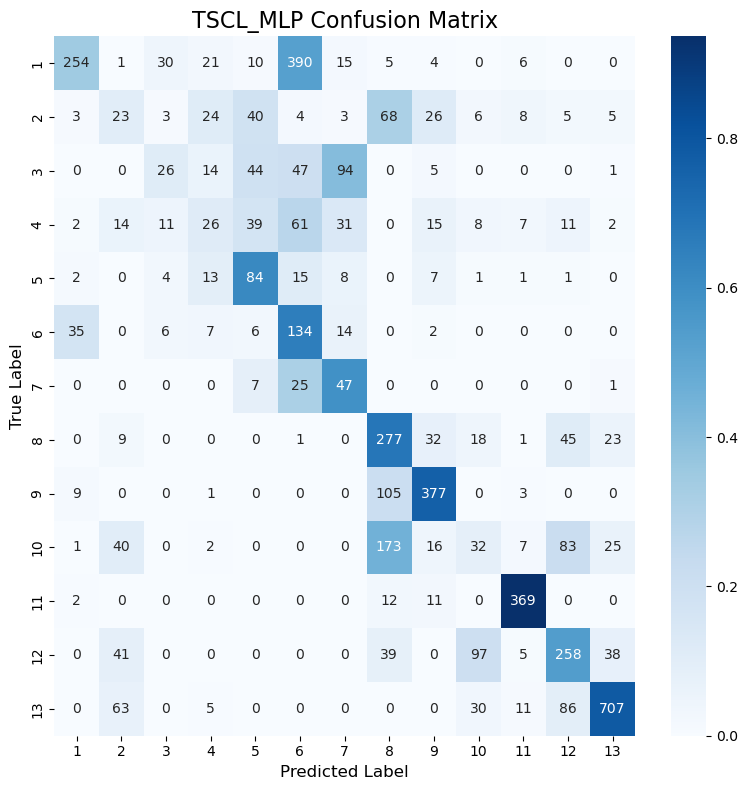

Classification Accuracy: 53.50%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


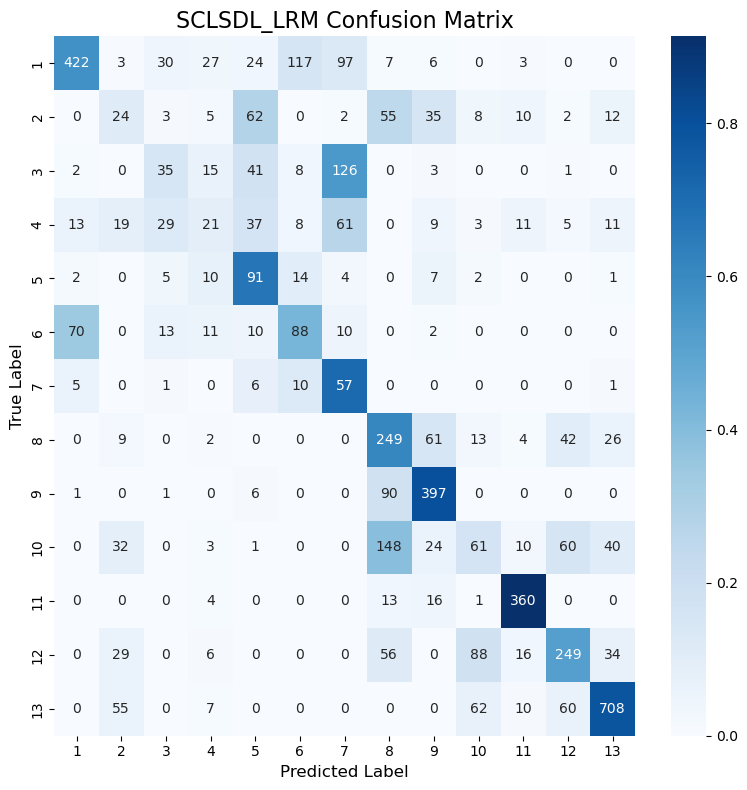

Classification Accuracy: 56.53%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


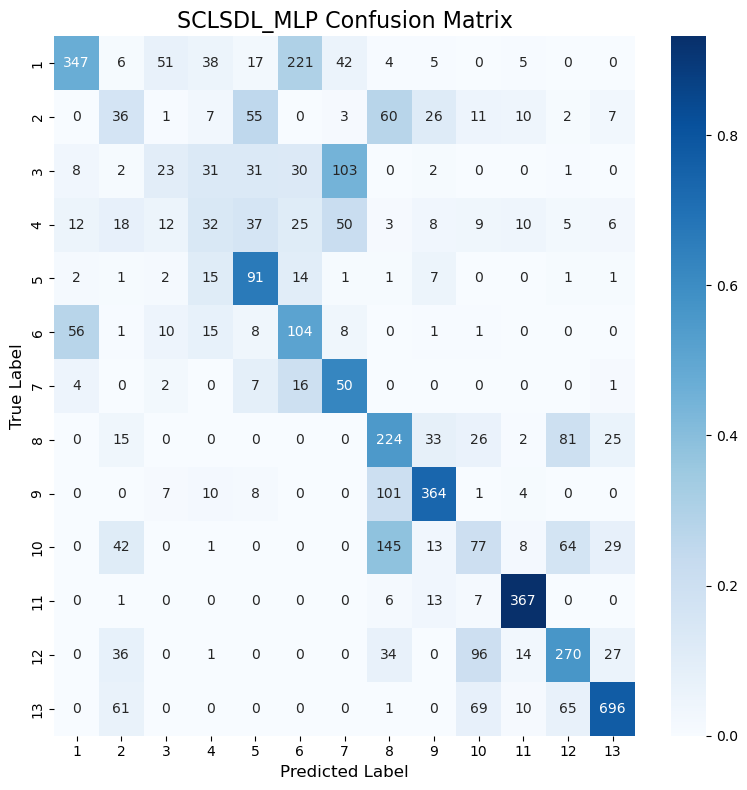

Classification Accuracy: 54.87%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          82.11
1    LRM (CAE)          49.18
2    MLP (CAE)          37.54
3     TSCL LRM          58.15
4     TSCL MLP          53.50
5  SCL_SDL LRM          56.53
6  SCL_SDL MLP          54.87

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          82.11
3     TSCL LRM          58.15
5  SCL_SDL LRM          56.53
6  SCL_SDL MLP          54.87
4     TSCL MLP          53.50
1    LRM (CAE)          49.18
2    MLP (CAE)          37.54
